# Ejercicio de Fisioterapia: Modelos

# Librerias

In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV
from sklearn.metrics import make_scorer, mean_squared_error, r2_score, mean_absolute_percentage_error
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import jarque_bera
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV

# Funciones para los modelos

In [5]:
directorio_principal = "C:\\Users\\KELLY\\Downloads\\fisioterapia_dataset_regresion"

def cargar_datos_entrenamiento_prueba(directorio):
    datos_entrenamiento = {}
    datos_prueba = {}

    for sujeto in range(1, 6):  # s1, s2, ..., s5
        for ejercicio in range(1, 9):  # e1, e2, ..., e8
            for unidad in range(1, 6):  # u1, u2, ..., u5
                ruta_entrenamiento = os.path.join(directorio, f"s{sujeto}", f"e{ejercicio}", f"u{unidad}", "template_session.txt")
                ruta_prueba = os.path.join(directorio, f"s{sujeto}", f"e{ejercicio}", f"u{unidad}", "test.txt")
           
                if os.path.exists(ruta_entrenamiento):
                    df_entrenamiento = pd.read_csv(ruta_entrenamiento, delimiter=';', header=0)
                    clave_entrenamiento = f"es{sujeto}e{ejercicio}u{unidad}"  # Clave
                    datos_entrenamiento[clave_entrenamiento] = df_entrenamiento
                else:
                    print(f"Archivo de entrenamiento no encontrado en: {ruta_entrenamiento}")
                
                if os.path.exists(ruta_prueba):
                    df_prueba = pd.read_csv(ruta_prueba, delimiter=';', header=0)
                    clave_prueba = f"ts{sujeto}e{ejercicio}u{unidad}"  # Clave
                    datos_prueba[clave_prueba] = df_prueba
                else:
                    print(f"Archivo de prueba no encontrado en: {ruta_prueba}")

    return datos_entrenamiento, datos_prueba

datos_entrenamiento, datos_prueba = cargar_datos_entrenamiento_prueba(directorio_principal)

Se definen varias funciones esenciales para la construcción, evaluación y análisis de modelos predictivos aplicados a series de tiempo, basados en las ventanas  específicas (tau = 7, 14, 21, 28):

1. Divide los datos en conjuntos de características (`X`) y variables objetivo (`y`) para entrenamiento y prueba, excluyendo el índice temporal.

2. Se senera pliegues de entrenamiento, validación y prueba para cada horizonte temporal (\(\tau\)), asegurando que las divisiones sean coherentes con las figuras dadas.

3. Calculamos métricas para evaluar el desempeño del modelo:
   - **MSE**: Error cuadrático medio.
   - **RMSE**: Raíz del error cuadrático medio.
   - **MAPE**: Error porcentual absoluto medio.
   - **\(R^2\)**: Coeficiente de determinación.
   - **Ljung-Box**: Test para independencia de residuos.
   - **Jarque-Bera**: Test para normalidad de residuos.

4. Evalúamos los residuos del modelo mediante pruebas estadísticas, asegurando que cumplan con los supuestos de independencia (Ljung-Box) y normalidad (Jarque-Bera).

5. Implementamos y evalúamos los modelo en los diferentes pliegues y horizontes temporales (\(\tau\)). Los resultados de cada pliegue incluyen las métricas calculadas y se resumen en un DataFrame.

In [121]:
tau_list = [7, 14, 21, 28]

def crear_pliegues(datos_entrenamiento, datos_prueba, variable, tau_list):
    X_train = datos_entrenamiento.drop(columns=[variable, 'time index'])
    y_train = datos_entrenamiento[variable]
        
    X_test = datos_prueba.drop(columns=[variable, 'time index'])
    y_test = datos_prueba[variable]
    divisiones = {}

    for tau in tau_list:
        divisiones[tau] = {
            'X_train': [],
            'y_train': [],
            'X_val': [],
            'y_val': [],
            'X_test': [],
            'y_test': []
        }

        # Construir pliegues usando datos de entrenamiento
        for inicio in range(len(X_train) - 3 * tau):
            X_train_fold = X_train[inicio:inicio + 2 * tau]
            y_train_fold = y_train[inicio:inicio + 2 * tau]
            
            X_val_fold = X_train[inicio + 2 * tau:inicio + 3 * tau]
            y_val_fold = y_train[inicio + 2 * tau:inicio + 3 * tau]
            
            X_test_fold = X_test[:tau]
            y_test_fold = y_test[:tau]

            divisiones[tau]['X_train'].append(X_train_fold)
            divisiones[tau]['y_train'].append(y_train_fold)
            divisiones[tau]['X_val'].append(X_val_fold)
            divisiones[tau]['y_val'].append(y_val_fold)
            divisiones[tau]['X_test'].append(X_test_fold)
            divisiones[tau]['y_test'].append(y_test_fold)
    
    return divisiones    # Cargar los datos y separar X, y 


def calcular_metricas(y_true, y_pred): 
    """
    Calcula métricas de evaluación.
    """
    residuals= y_true-y_pred
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    r2 = r2_score(y_true, y_pred)
    Ljung0,Jarque= evaluar_residuos(residuals)
    
    return mse, rmse, mape, r2,Ljung0,Jarque

def evaluar_residuos(residuos):
    """
    Evalúa la independencia y normalidad de los residuos.
    """
    # Determinar el número máximo de retardos permitido
    max_lags = min(10, len(residuos) - 1)
    
    # Verificar si es posible realizar el test de Ljung-Box
    if max_lags > 0:
        # Ljung-Box test
        ljung_box_pval = acorr_ljungbox(residuos, lags=max_lags, return_df=True)['lb_pvalue'].iloc[-1]
    else:
        ljung_box_pval = np.nan  # No se puede calcular

    # Jarque-Bera test
    if len(residuos) > 1:  # Jarque-Bera requiere al menos 2 residuos
        jarque_bera_pval = jarque_bera(residuos)[1]
    else:
        jarque_bera_pval = np.nan  # No se puede calcular

    return ljung_box_pval, jarque_bera_pval                      


def evaluar_modelo_knn(divisiones, tau_list, n_neighbors=5):
  
    resultados = []
    
    for tau in tau_list:
        
        for i, (X_train, y_train, X_test, y_test) in enumerate(
            zip(divisiones[tau]['X_train'], divisiones[tau]['y_train'], 
                divisiones[tau]['X_val'], divisiones[tau]['y_val'])):
            modelo = KNeighborsRegressor(n_neighbors=n_neighbors)
            modelo.fit(X_train, y_train)
            y_pred = modelo.predict(X_test)
            mse, rmse, mape, r2, Ljung0,Jarque= calcular_metricas(y_test, y_pred)
            resultados.append({
                'Ventana': tau,
                'pliegue': i + 1,
                'MSE': mse,
                'RMSE': rmse,
                'MAPE': mape,
                'R2': r2,
                'Ljung-Box (p-value)': Ljung0,
                'Jarque-Bera (p-value)': Jarque         
            })
    return pd.DataFrame(resultados)           

def evaluar_modelo_lr(divisiones, tau_list):
    resultadoslr = []
    
    for tau in tau_list:
        print(f"\n  Evaluación para τ = {tau}")
        for i, (X_train, y_train, X_test, y_test) in enumerate(
            zip(divisiones[tau]['X_train'], divisiones[tau]['y_train'], 
                divisiones[tau]['X_val'], divisiones[tau]['y_val'])):
            modelo = LinearRegression()
            modelo.fit(X_train, y_train)
            y_pred = modelo.predict(X_test)
            mse, rmse, mape, r2, Ljung0, Jarque = calcular_metricas(y_test, y_pred)
            resultadoslr.append({
                'Ventana': tau,
                'pliegue': i + 1,
                'MSE': mse,
                'RMSE': rmse,
                'MAPE': mape,
                'R2': r2,
                'Ljung-Box (p-value)': Ljung0,
                'Jarque-Bera (p-value)': Jarque
            })
    return pd.DataFrame(resultadoslr)         

def evaluar_modelo_ridge(divisiones, tau_list):
  
    resultadosr = []
    
    for tau in tau_list:
        
        for i, (X_train, y_train, X_test, y_test) in enumerate(
            zip(divisiones[tau]['X_train'], divisiones[tau]['y_train'], 
                divisiones[tau]['X_val'], divisiones[tau]['y_val'])):
            modelo = Ridge(alpha=1.0)
            modelo.fit(X_train, y_train)
            y_pred_test = modelo.predict(X_test)
            mse, rmse, mape, r2, Ljung0,Jarque= calcular_metricas(y_test, y_pred_test)

            resultadosr.append({
                'Ventana': tau,
                'pliegue': i + 1,
                'MSE': mse,
                'RMSE': rmse,
                'MAPE': mape,
                'R2': r2,
                'Ljung-Box (p-value)': Ljung0,
                'Jarque-Bera (p-value)': Jarque
            })
    return pd.DataFrame(resultadosr) 

def evaluar_modelo_lasso(divisiones, tau_list):
  
    resultadosl = []
    
    for tau in tau_list:
        
        for i, (X_train, y_train, X_test, y_test) in enumerate(
            zip(divisiones[tau]['X_train'], divisiones[tau]['y_train'], 
                divisiones[tau]['X_val'], divisiones[tau]['y_val'])):
            # Ajustar modelo k-NN
            param_grid = {'alpha': (1e-4, 1.0, 'log-uniform')}
            modelo = BayesSearchCV(Lasso(), param_grid, cv=5)
            modelo.fit(X_train, y_train)
           
            y_pred= modelo.predict(X_test)
            
            mse, rmse, mape, r2, Ljung0,Jarque= calcular_metricas(y_test, y_pred)

            resultadosl.append({
                'Ventana': tau,
                'pliegue': i + 1,
                'MSE': mse,
                'RMSE': rmse,
                'MAPE': mape,
                'R2': r2,
                'Ljung-Box (p-value)': Ljung0,
                'Jarque-Bera (p-value)': Jarque
            })
    return pd.DataFrame(resultadosl) 
    
def evaluar_modelo_random(divisiones, tau_list):
  
    resultadosr = []
    
    for tau in tau_list:
        print(f"Evaluando para: {tau}")
        for i, (X_train, y_train, X_test, y_test) in enumerate(
            zip(divisiones[tau]['X_train'], divisiones[tau]['y_train'], 
                divisiones[tau]['X_val'], divisiones[tau]['y_val'])):
            # Ajustar modelo k-NN
            modelo = RandomForestRegressor(n_estimators=100, random_state=42)
            modelo.fit(X_train, y_train)
           
            y_pred = modelo.predict(X_test)
            
            mse, rmse, mape, r2, Ljung0,Jarque= calcular_metricas(y_test, y_pred)

            resultadosr.append({
                'Ventana': tau,
                'pliegue': i + 1,
                'MSE': mse,
                'RMSE': rmse,
                'MAPE': mape,
                'R2': r2,
                'Ljung-Box (p-value)': Ljung0,
                'Jarque-Bera (p-value)': Jarque
            })
    return pd.DataFrame(resultadosr)     
def evaluar_modelo_xg(divisiones, tau_list):
  
    resultadosxg = []
    
    for tau in tau_list:
        print(f"\n  Evaluación para τ = {tau}")
        for i, (X_train, y_train, X_test, y_test) in enumerate(
            zip(divisiones[tau]['X_train'], divisiones[tau]['y_train'], 
                divisiones[tau]['X_val'], divisiones[tau]['y_val'])):
            # Ajustar modelo k-NN
            modelo = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=2)
            modelo.fit(X_train, y_train)
           
            y_pred = modelo.predict(X_test)
            
            mse, rmse, mape, r2, Ljung0,Jarque= calcular_metricas(y_test, y_pred)

            resultadosxg.append({
                'Ventana': tau,
                'pliegue': i + 1,
                'MSE': mse,
                'RMSE': rmse,
                'MAPE': mape,
                'R2': r2,
                'Ljung-Box (p-value)': Ljung0,
                'Jarque-Bera (p-value)': Jarque
            })
    return pd.DataFrame(resultadosxg) 
            
param_grid = {
    'C': [10, 100],
    'epsilon': [ 0.1],
    'kernel': ['rbf'],
    'gamma': ['scale', 'auto']
}


def evaluar_modelo_svr(divisiones, tau_list):
  
    resultadossvr = []
    
    for tau in tau_list:
        print(f"\n  Evaluación para τ = {tau}")
        for i, (X_train, y_train, X_test, y_test) in enumerate(
            zip(divisiones[tau]['X_train'], divisiones[tau]['y_train'], 
                divisiones[tau]['X_val'], divisiones[tau]['y_val'])):
        
            modelo = GridSearchCV(SVR(), param_grid, cv=5, scoring='r2')
            modelo.fit(X_train, y_train)
           
            y_pred = modelo.predict(X_test)
            
            mse, rmse, mape, r2, Ljung0,Jarque= calcular_metricas(y_test, y_pred)

            resultadossvr.append({
                'Ventana': tau,
                'pliegue': i + 1,
                'MSE': mse,
                'RMSE': rmse,
                'MAPE': mape,
                'R2': r2,
                'Ljung-Box (p-value)': Ljung0,
                'Jarque-Bera (p-value)': Jarque
            })
    return pd.DataFrame(resultadossvr) 

### Visualizamos los pliegues 

In [ ]:
def visualizar_pliegues_completos(divisiones, tau_list):
    for tau in tau_list:
        print(f"Visualización para τ = {tau}")
        print(f"Pliegues disponibles: {len(divisiones[tau]['X_train'])}")
        
        for i, (X_train, y_train, X_val, y_val, X_test, y_test) in enumerate(
            zip(divisiones[tau]['X_train'], divisiones[tau]['y_train'], 
                divisiones[tau]['X_val'], divisiones[tau]['y_val'], 
                divisiones[tau]['X_test'], divisiones[tau]['y_test'])):
            
            print(f"\nPliegue {i+1} para τ = {tau}")
            print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
            print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
            print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

Se implementaron dos funciones clave para visualizar cómo se organizan los pliegues generados en un conjunto de datos dividido en entrenamiento, validación y prueba, tomando como ejemplo los valores de la ventana (\(7, 14, 21, 28\)) y los datos de entrenamiento y prueba (`datos_entrenamiento['es1e1u1']` y `datos_prueba['ts1e1u1']`).

In [ ]:

tau_list = [7, 14, 21, 28]

divisiones = crear_pliegues(datos_entrenamiento['es1e1u1'], datos_prueba['ts1e1u1'], tau_list)

visualizar_pliegues_completos(divisiones, tau_list)


Por otro lado, la función `graficar_pliegues` genera una representación visual de los pliegues, utilizando colores distintos para diferenciar entrenamiento (azul), validación (naranja) y prueba (verde). Para cada valor de ventana, se crea un subgráfico que muestra cómo los conjuntos están escalonados en el tiempo, con un límite de 20 pliegues para mantener la claridad visual. Estas gráficas ofrecen una representación intuitiva de cómo se estructuran los conjuntos de datos para un ejemplo específico, facilitando la comprensión del proceso de validación cruzada temporal y sirviendo como una herramienta de verificación antes de aplicar los pliegues a modelos predictivos.

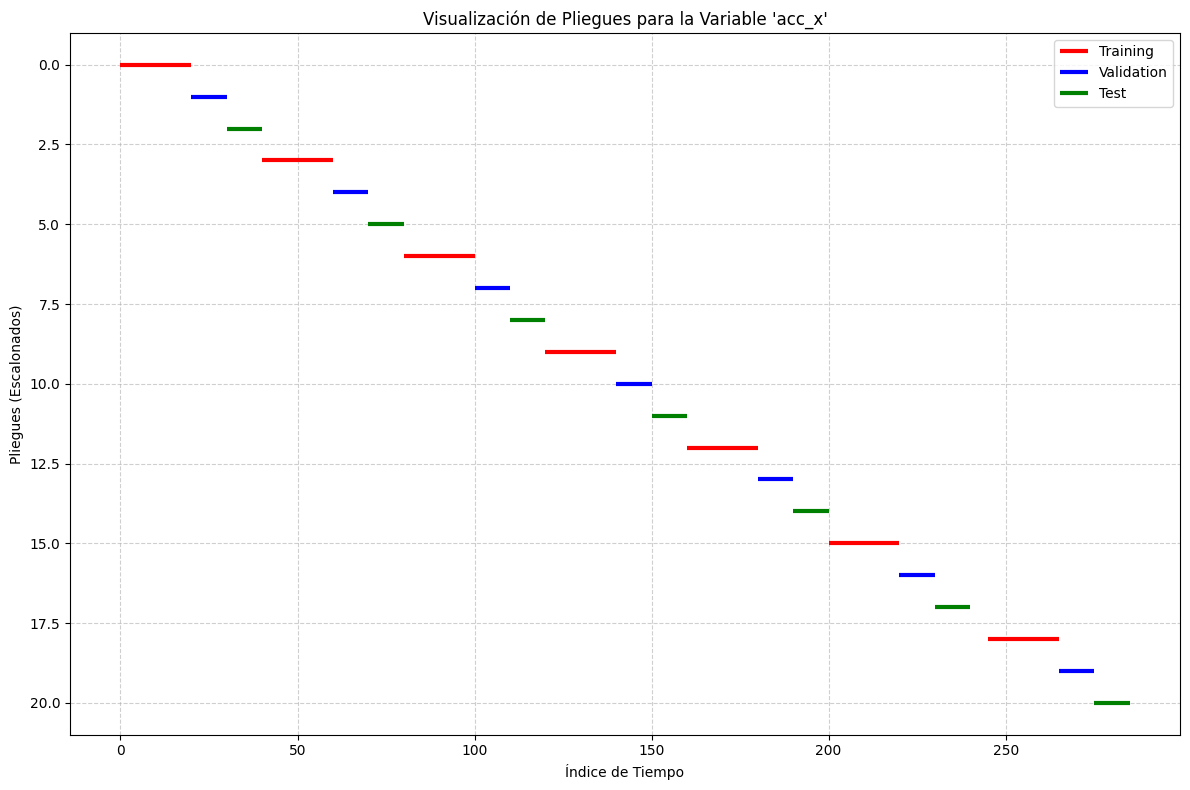

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def graficar_pliegues(divisiones, tau_list):
    colores = ['blue', 'orange', 'green']  
    
    plt.figure(figsize=(12, 8))
    for idx, tau in enumerate(tau_list):
        plt.subplot(len(tau_list), 1, idx + 1)
 
        num_pliegues = 20
        for i in range(num_pliegues):
            inicio_train = i
            fin_train = i + 2 * tau
            inicio_val = fin_train
            fin_val = inicio_val + tau
    
            plt.plot(range(inicio_train, fin_train), [i] * (fin_train - inicio_train), 
                     color=colores[0], label='Train' if i == 0 else "")
            plt.plot(range(inicio_val, fin_val), [i] * (fin_val - inicio_val), 
                     color=colores[1], label='Validation' if i == 0 else "")
            plt.plot(range(0, tau), [i] * tau, 
                     color=colores[2], label='Test' if i == 0 else "")
        
        plt.title(f"Visualización de pliegues para τ = {tau}")
        plt.xlabel("Índice de tiempo")
        plt.ylabel("Pliegues")
        plt.legend(loc="upper right")
    
    plt.tight_layout()
    plt.show()

# Llamar a la función para visualizar los pliegues
graficar_pliegues(divisiones, tau_list)


In [ ]:
def graficar_diagnostico_residuos(residuos, nombre_modelo):
    residuos = residuos[~np.isnan(residuos)]  
    residuos = residuos[~np.isinf(residuos)]  
    residuos = np.array(residuos) 
    
    if len(residuos) < 2:
        print("No hay suficientes datos para graficar ACF o QQPlot.")
        return
    
    plt.figure(figsize=(15, 10))

    plt.subplot(3, 1, 1)
    plt.plot(residuos, label="Residuos")
    plt.axhline(0, color='red', linestyle='--', alpha=0.7)
    plt.title(f"Serie de Residuos - {nombre_modelo}")
    plt.legend()
    
    # QQPlot de los residuos
    plt.subplot(3, 1, 2)
    sm.qqplot(residuos, line='s', alpha=0.5)
    plt.title(f"QQPlot de Residuos - {nombre_modelo}")
    
    # ACF de los residuos
    plt.subplot(3, 1, 3)
    max_lags = min(20, len(residuos) - 1)  # Ajustar el número máximo de lags
    sm.graphics.tsa.plot_acf(residuos, lags=max_lags, alpha=0.05)
    plt.title(f"ACF de Residuos - {nombre_modelo}")
    
    plt.tight_layout()
    plt.show()

La función graficar_diagnostico_residuos está diseñada para analizar y diagnosticar los residuos de un modelo predictivo mediante tres visualizaciones principales: una serie de residuos, un gráfico QQPlot, y la función de autocorrelación (ACF). Primero, limpia los datos eliminando valores no válidos (NaN o infinitos) y asegura que haya suficientes puntos para el análisis. La serie de residuos permite identificar patrones o tendencias no modeladas, mientras que el QQPlot compara la distribución de los residuos con una normal teórica para evaluar su normalidad. Finalmente, el gráfico ACF verifica la independencia de los residuos al analizar la autocorrelación con diferentes retardos. Estos gráficos proporcionan información crítica para validar los supuestos estadísticos del modelo, ayudando a identificar posibles ajustes o mejoras necesarias en el proceso de modelado.

In [ ]:
def obtener_mejores_resultados(resultados, criterio='R2'):
    if criterio in ['R2', 'MSE', 'RMSE', 'MAPE']:
        if criterio == 'R2':  
            mejor_modelo = resultados.loc[resultados[criterio].idxmax()]
        else:  
            mejor_modelo = resultados.loc[resultados[criterio].idxmin()]
    else:
        raise ValueError(f"Criterio no reconocido: {criterio}")
    
    return mejor_modelo  

Se evaluaron todos los modelos predictivos para las variables respuesta \( y \) de un único sujeto, considerando todas las combinaciones posibles de unidades \( u1, u2, ..., u5 \) y ejercicios \( e1, e2, ..., e8 \). Para cada variable \( acc_x, acc_y, acc_z, etc. \), se seleccionó el modelo con el mejor desempeño utilizando métricas como el coeficiente de determinación \( R^2 \) o el error cuadrático medio \( MSE \), asegurando así el mejor ajuste del modelo. La función **`obtener_mejores_resultados`** se empleó para automatizar este proceso, seleccionando el modelo con el \( R^2 \) más alto o, en caso de otras métricas, con el valor más bajo, de manera uniforme y sistemática.

Los resultados se organizaron en tablas separadas por modelo, detallando las métricas de desempeño para cada variable respuesta junto con la combinación de unidad y ejercicio correspondiente. Este enfoque garantiza un análisis completo y estructurado, optimizando el rendimiento del modelo para cada variable y proporcionando una comparación directa basada en criterios cuantitativos y consistentes.

# Implementación

## KNN

In [ ]:
variables = ['acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z', 'mag_x', 'mag_y', 'mag_z']


sujeto = 1  
ejercicios = range(1, 9)  
unidades = range(1, 6)  

# Lista para almacenar resultados de todas las combinaciones
resultados_completos = [] 
for ejercicio in ejercicios:
    for unidad in unidades:
        clave_entrenamiento = f'es{sujeto}e{ejercicio}u{unidad}'
        clave_prueba = f'ts{sujeto}e{ejercicio}u{unidad}'
        
        # Verificar si las claves están en los datos
        if clave_entrenamiento in datos_entrenamiento and clave_prueba in datos_prueba:
            divisiones = crear_pliegues(
                datos_entrenamiento[clave_entrenamiento],
                datos_prueba[clave_prueba],
                variables,
                tau_list
            )
            # Evaluar y seleccionar el mejor modelo para cada variable
            resultados = evaluar_modelo_knn(divisiones, tau_list, n_neighbors=5)
            mejor_resultado = obtener_mejores_resultados(resultados, criterio='R2')
            resultados_completos.append(mejor_resultado)
        else:
            print(f"Claves no encontradas: {clave_entrenamiento} o {clave_prueba}")


### Los mejores modelos

In [ ]:
pd.DataFrame(resultados_completos)

Ventana           MSE      RMSE        MAPE        R2  \
100       7.0  6.854017e-05  0.008279    0.057547  0.843474   
21        7.0  1.514589e-04  0.012307    0.655401  0.796674   
18        7.0  1.072232e-04  0.010355    1.370848  0.858014   
563       7.0  3.618022e-05  0.006015  118.785745  0.649744   
1592      7.0  7.828169e-06  0.002798   48.576937  0.803702   
524       7.0  3.815489e-05  0.006177  153.141813  0.693593   
1977      7.0  5.148097e-08  0.000227    0.035027  0.680844   
545       7.0  3.584464e-07  0.000599    0.103253  0.691997   
1411      7.0  5.756699e-08  0.000240    0.269674  0.790501   

      Ljung-Box (p-value)  Jarque-Bera (p-value) variable  
100              0.273886               0.534349    acc_x  
21               0.107306               0.828277    acc_y  
18               0.358154               0.947569    acc_z  
563              0.371555               0.796987    gyr_x  
1592             0.710231               0.675659    gyr_y  
524              0.787553               0.595898    gyr_z  
1977             0.753281               0.695350    mag_x  
545              0.435722               0.841069    mag_y  
1411             0.175797               0.962816    mag_z

Los resultados muestran un desempeño aceptable en términos de las métricas evaluadas, con valores de \( R^2 \) moderados, indicando que los modelos explican entre el 65% y el 85% de la variabilidad de las variables respuesta, dependiendo de la variable analizada. Las métricas de error absoluto (\( MSE \), \( RMSE \)) son bajas en general, reflejando una precisión adecuada, aunque variables como `gyr_x`, `gyr_z` y `gyr_y` presentan valores de \( MAPE \) elevados, sugiriendo dificultades del modelo para predecir valores extremos o cambios abruptos en estas variables. 

### Graficas de los residuos


Generando gráfico de residuos para la variable: acc_x, τ=7.0, pliegue=101


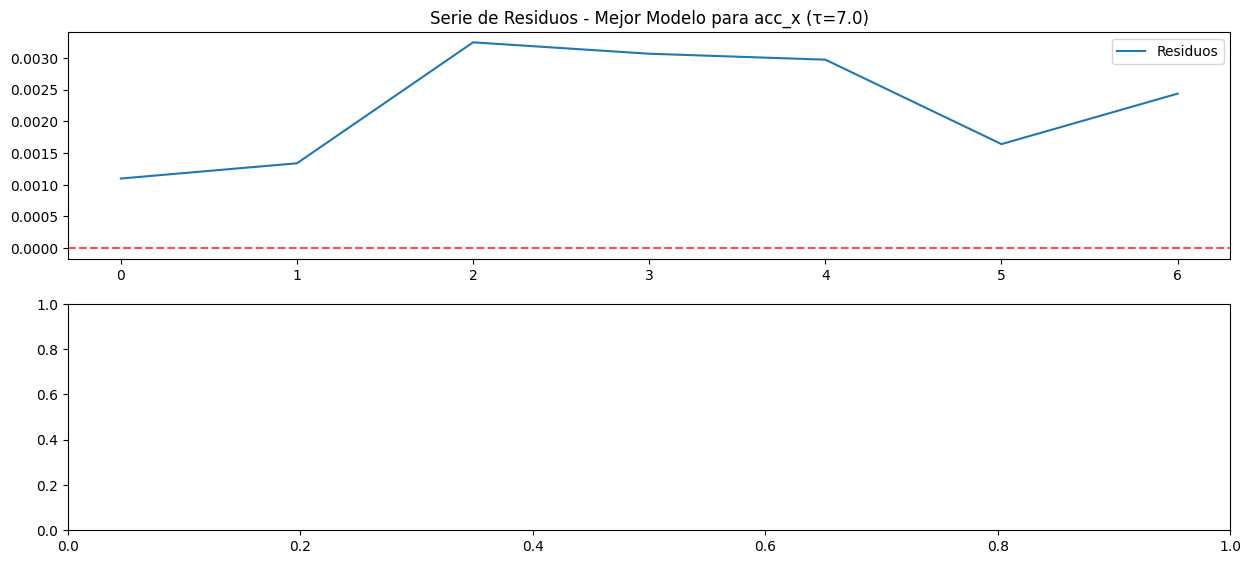

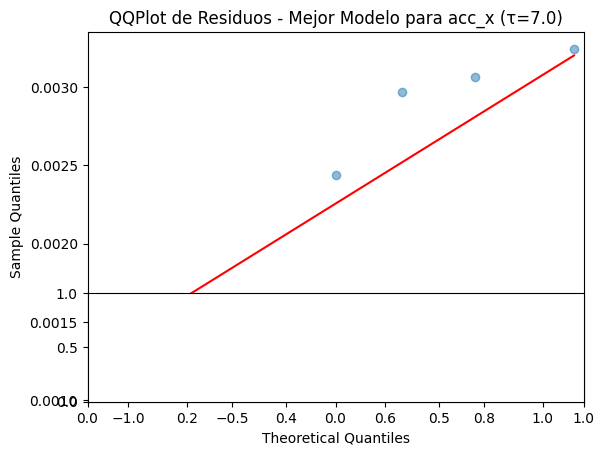

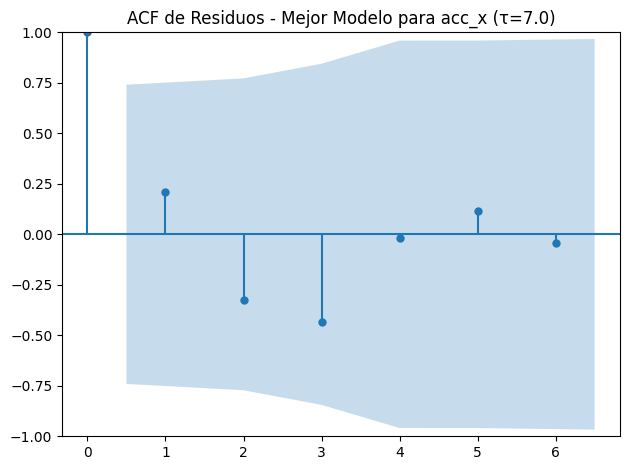


Generando gráfico de residuos para la variable: acc_y, τ=7.0, pliegue=22


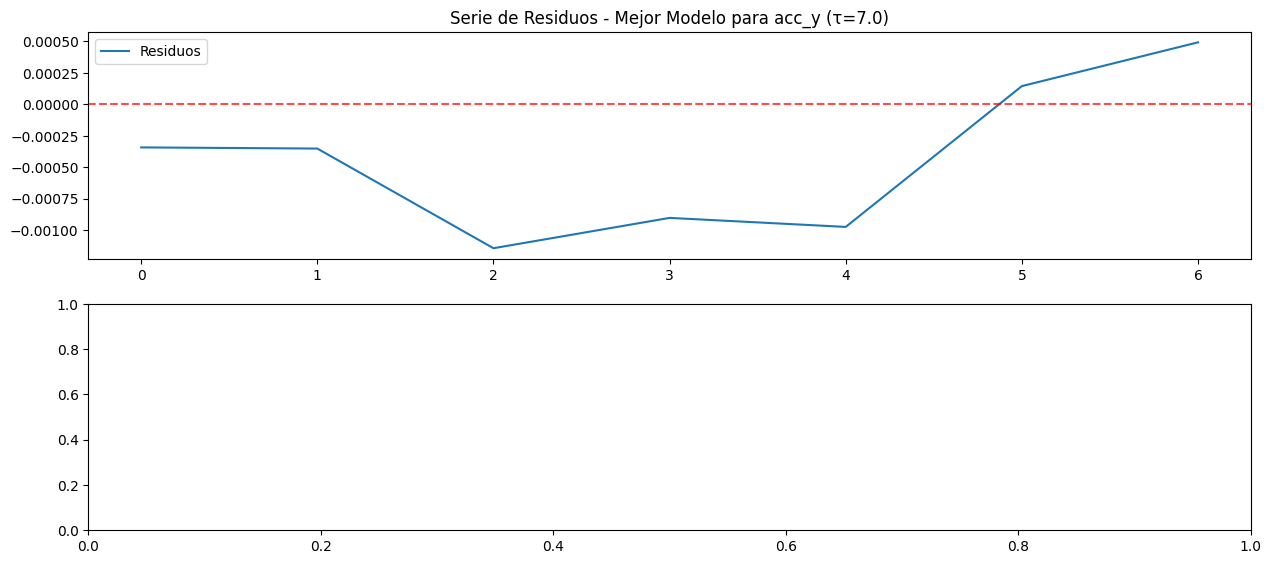

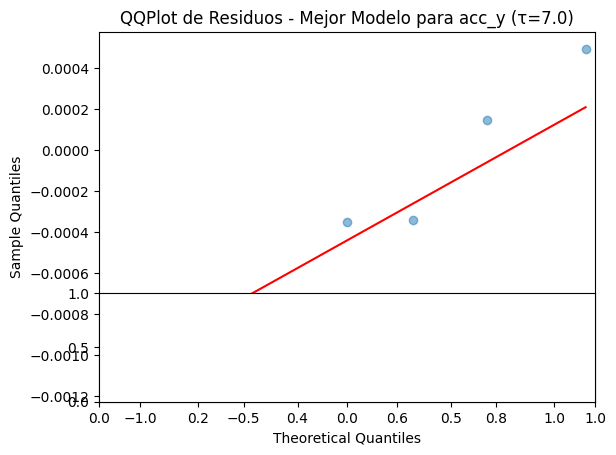

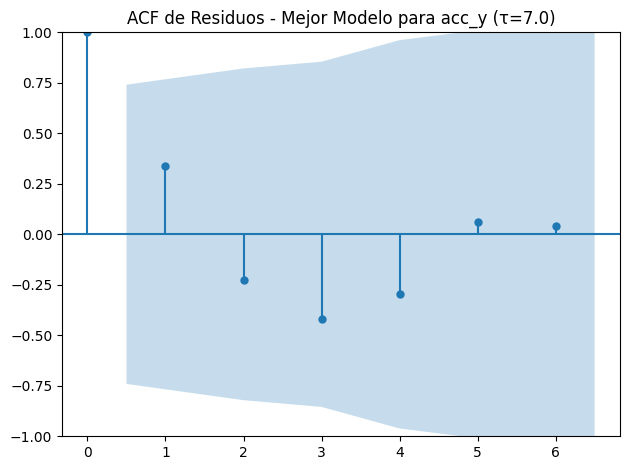


Generando gráfico de residuos para la variable: acc_z, τ=7.0, pliegue=19


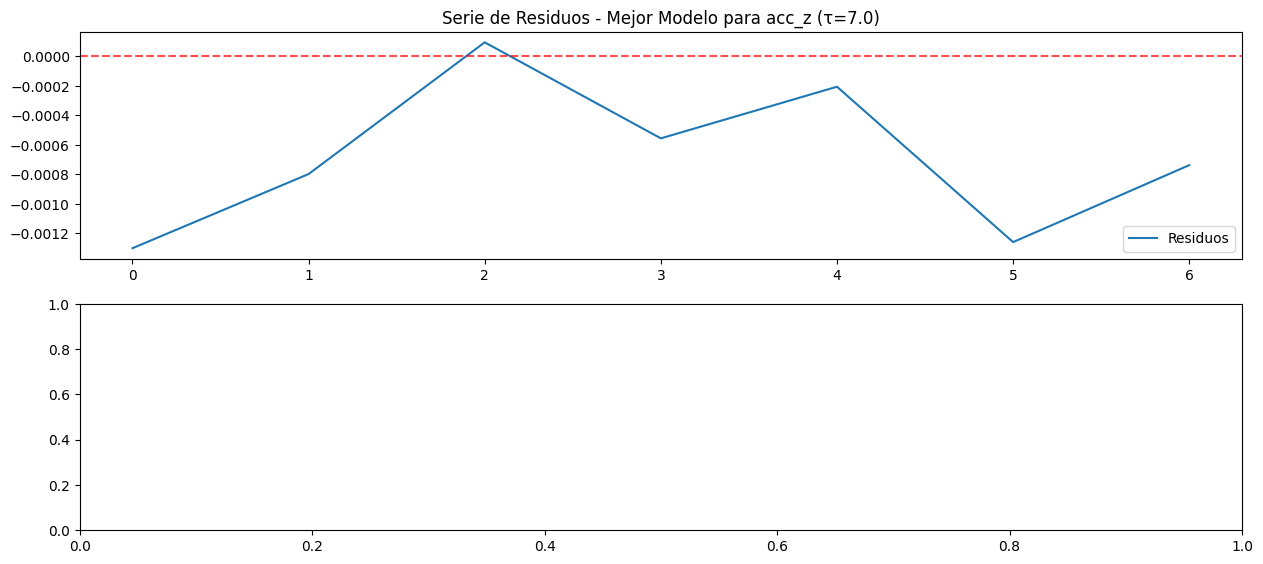

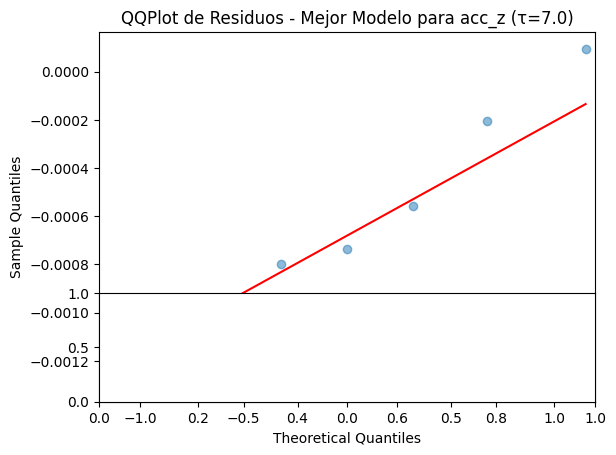

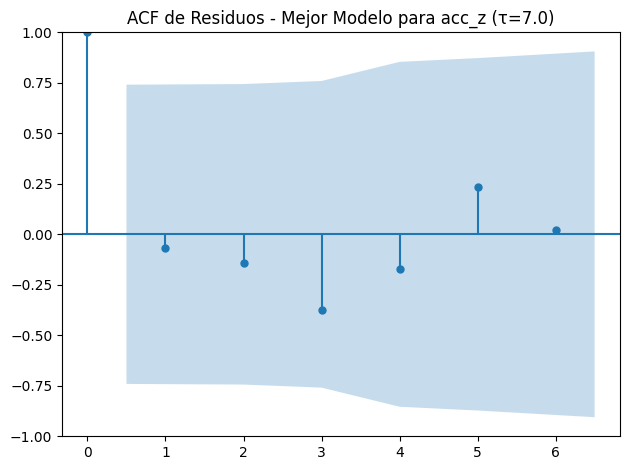


Generando gráfico de residuos para la variable: gyr_x, τ=7.0, pliegue=564


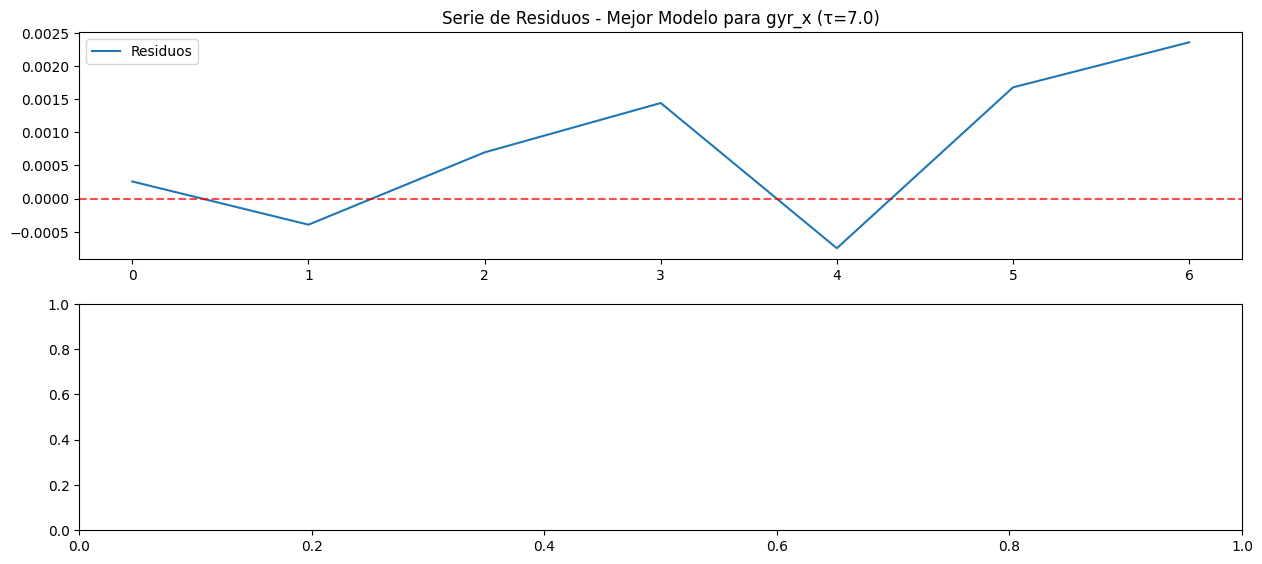

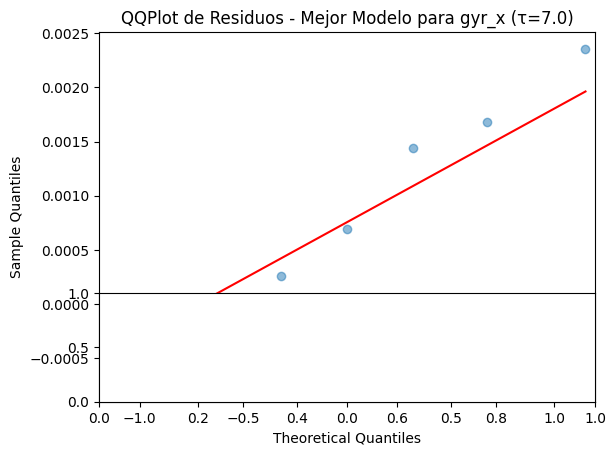

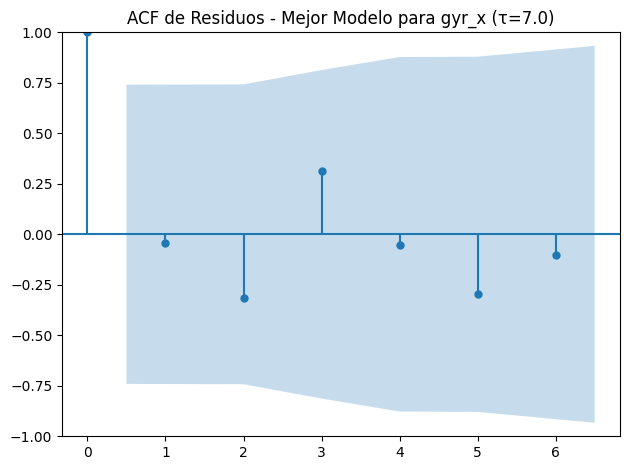


Generando gráfico de residuos para la variable: gyr_y, τ=7.0, pliegue=1593


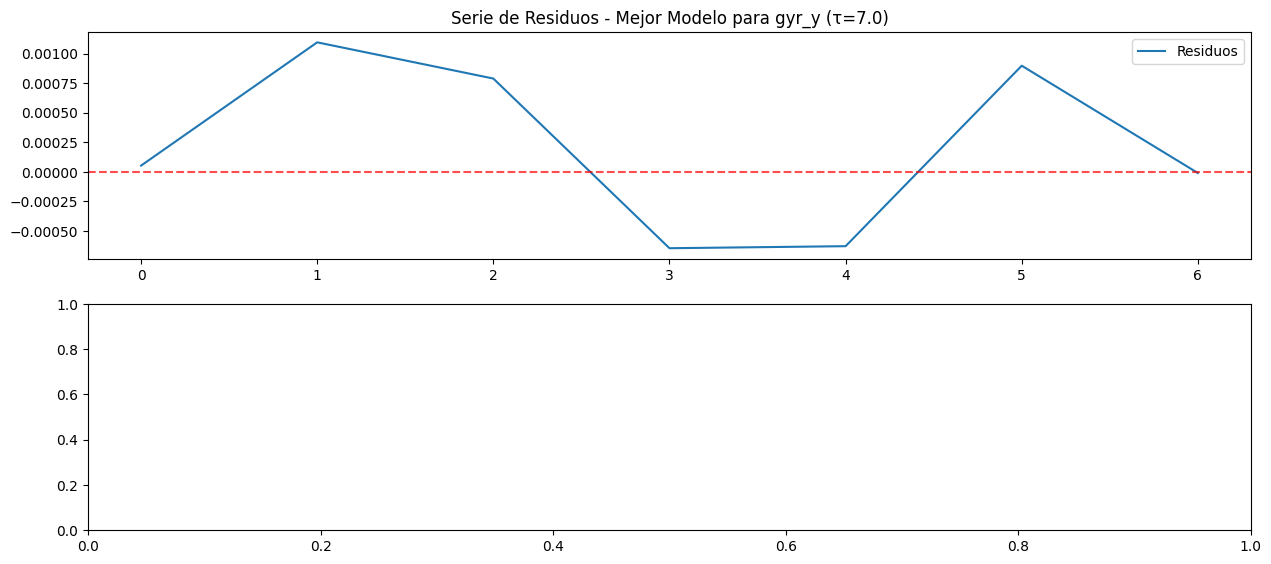

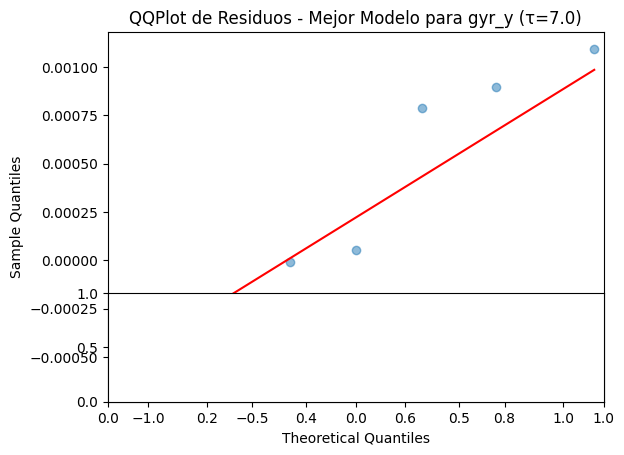

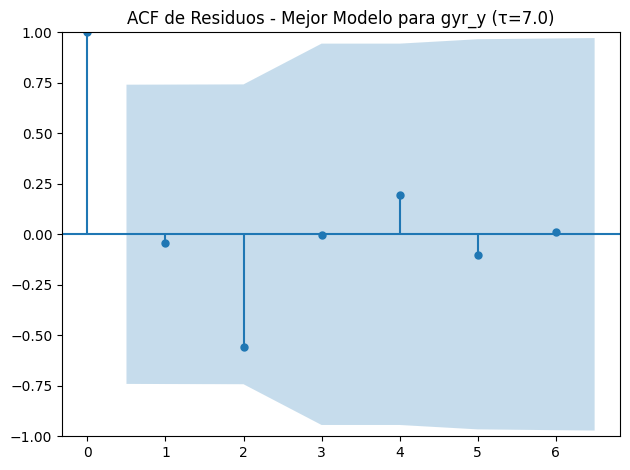


Generando gráfico de residuos para la variable: gyr_z, τ=7.0, pliegue=525


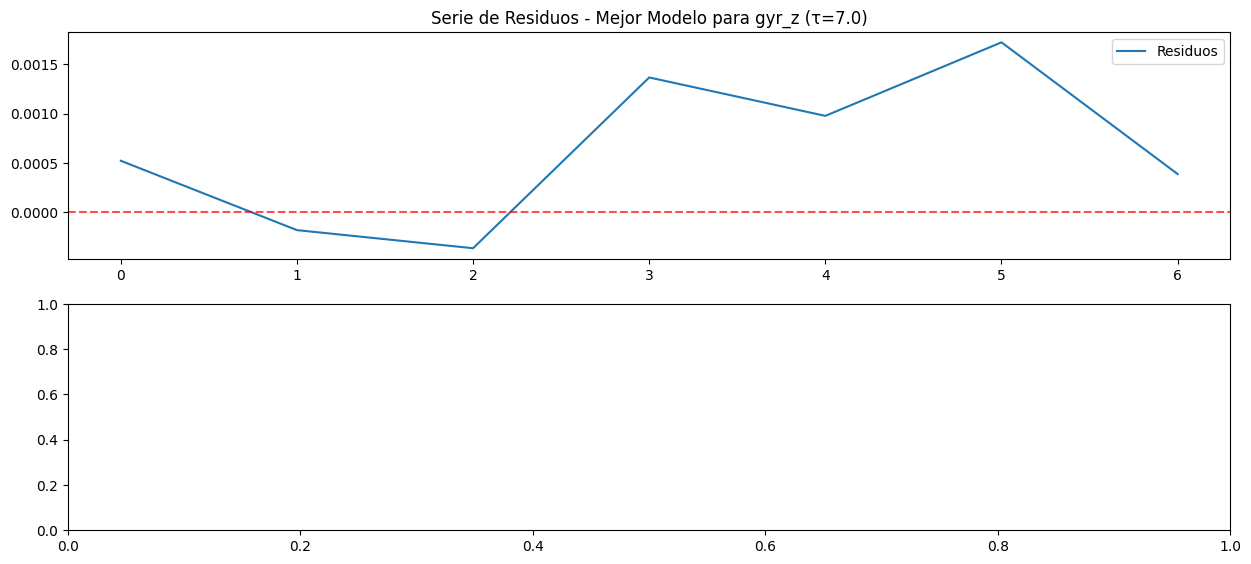

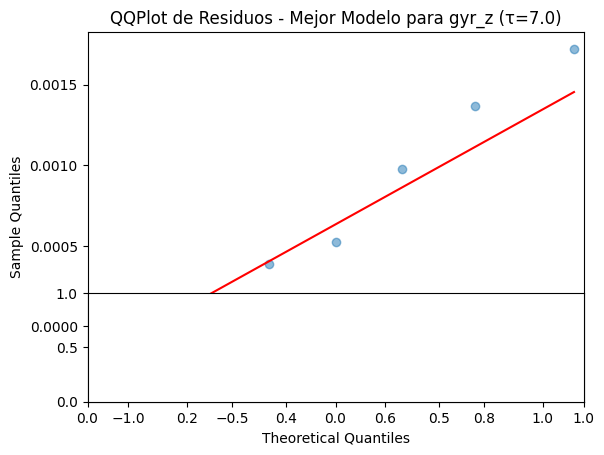

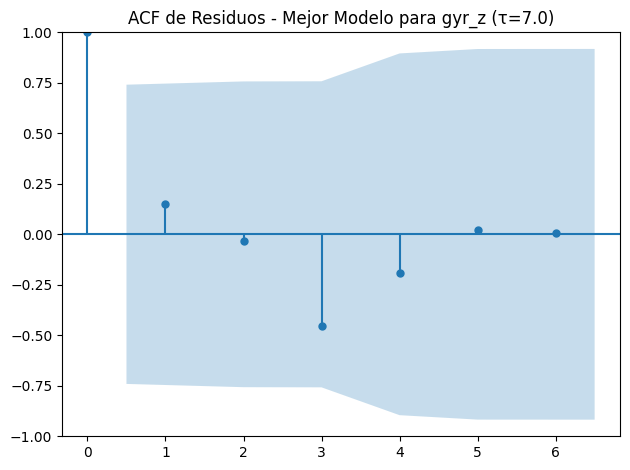


Generando gráfico de residuos para la variable: mag_x, τ=7.0, pliegue=1978


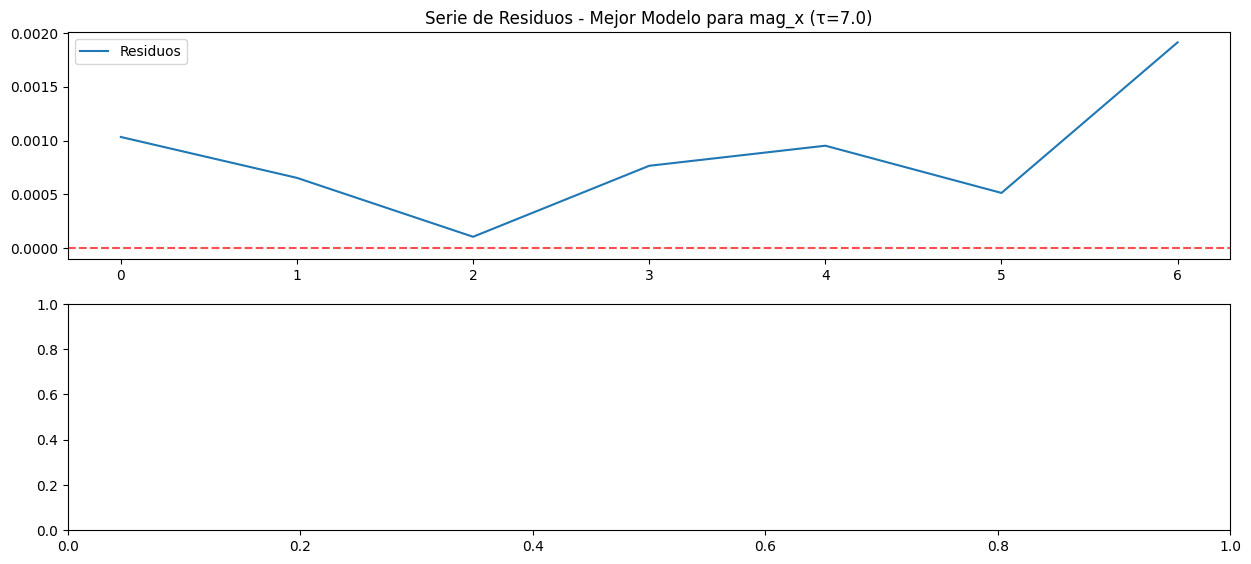

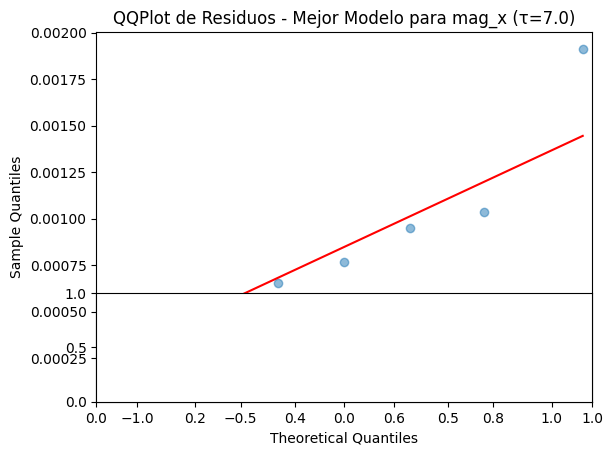

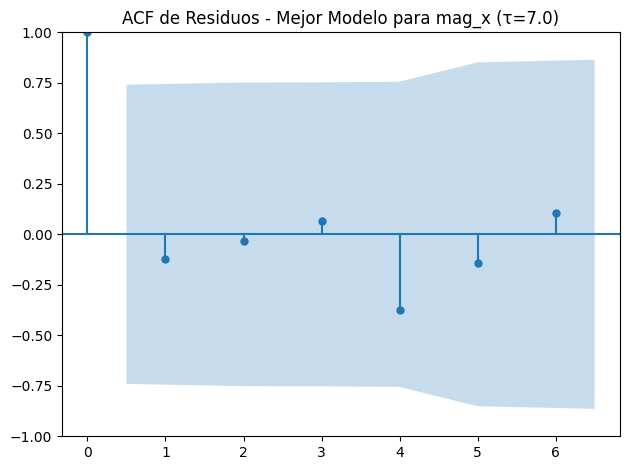


Generando gráfico de residuos para la variable: mag_y, τ=7.0, pliegue=546


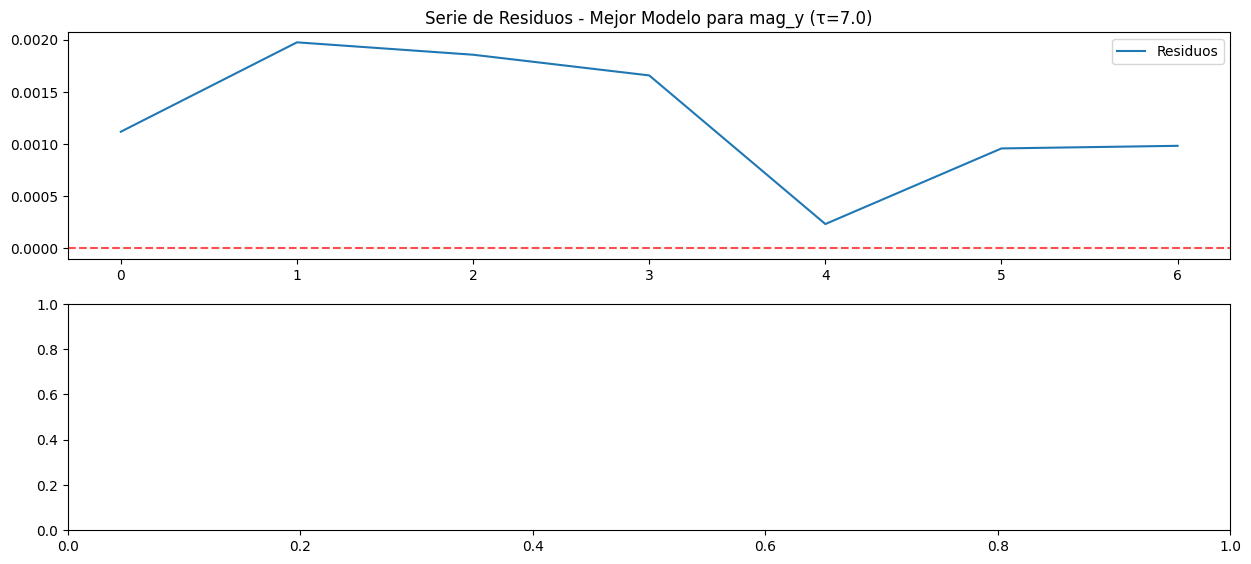

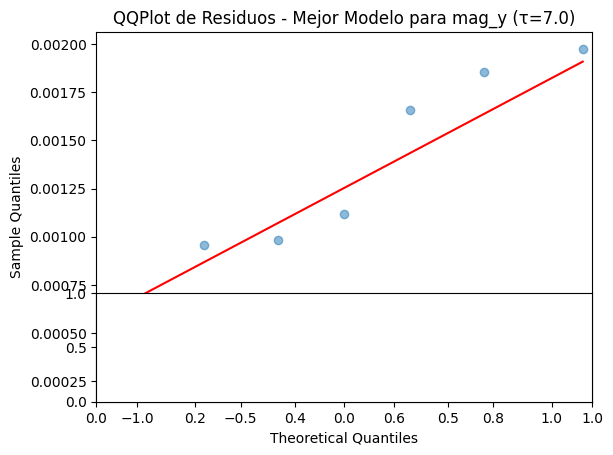

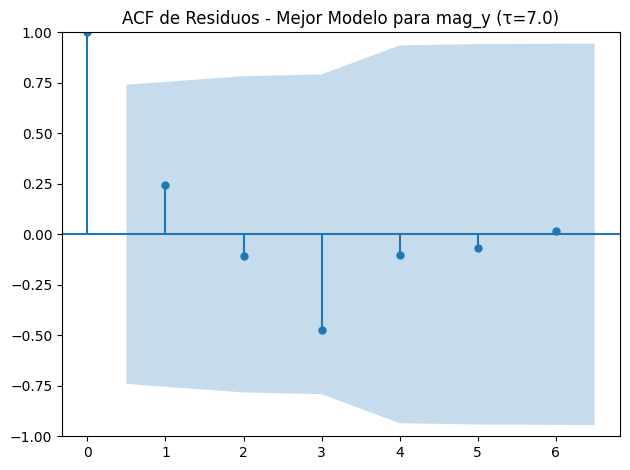


Generando gráfico de residuos para la variable: mag_z, τ=7.0, pliegue=1412


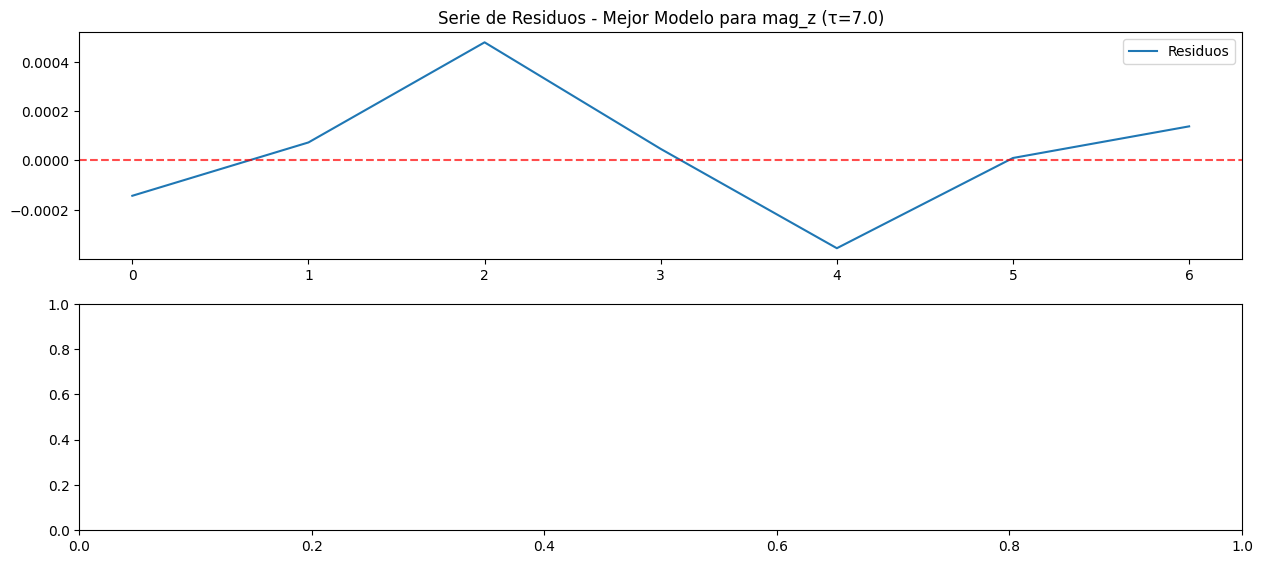

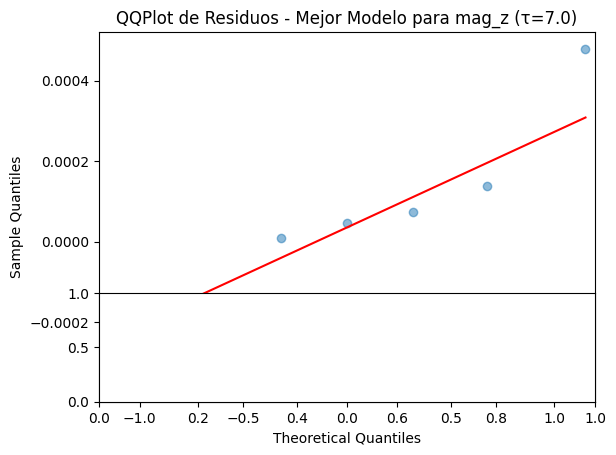

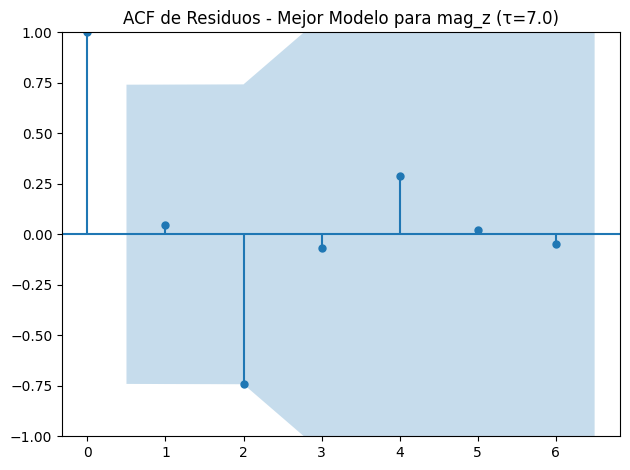

In [ ]:
for index, row in resultados_completos.iterrows():
    variable = row['variable']
    mejor_tau = row['Ventana']  
    mejor_pliegue = int(row['pliegue'])  

    print(f"\nGenerando gráfico de residuos para la variable: {variable}, τ={mejor_tau}, pliegue={mejor_pliegue}")
    X_train_best = divisiones[mejor_tau]['X_train'][mejor_pliegue - 1]
    y_train_best = divisiones[mejor_tau]['y_train'][mejor_pliegue - 1]
    X_val_best = divisiones[mejor_tau]['X_val'][mejor_pliegue - 1]
    y_val_best = divisiones[mejor_tau]['y_val'][mejor_pliegue - 1]
    modelo_best = KNeighborsRegressor(n_neighbors=5) 
    modelo_best.fit(X_train_best, y_train_best)

    y_pred_best = modelo_best.predict(X_val_best)
    residuos_best = y_val_best - y_pred_best
    residuos_best = np.array(residuos_best)

    graficar_diagnostico_residuos(
        residuos_best, 
        nombre_modelo=f"Mejor Modelo para {variable} (τ={mejor_tau})"
    )

Las gráficas de los residuos muestran un análisis detallado del desempeño de los modelos ajustados para las variables `acc_x`, `acc_y` y `acc_z`. En las series de residuos, los valores fluctúan alrededor de cero, lo cual indica un comportamiento simétrico y ausencia de patrones significativos, aunque con variaciones leves en su magnitud. Los gráficos QQ-plot confirman que los residuos siguen en gran medida una distribución normal, con ligeras desviaciones en los extremos. Finalmente, las funciones de autocorrelación (ACF) revelan que los residuos son mayormente independientes, con valores dentro de los intervalos de confianza. En general, los modelos muestran un buen ajuste, aunque podrían beneficiarse de ajustes adicionales para mejorar la normalidad y la independencia en ciertas variables. Estas observaciones sugieren que los modelos no cumplen completamente con los supuestos de normalidad e independencia.



### Boxplot

Procesando errores para la variable: acc_x
Procesando errores para la variable: acc_y
Procesando errores para la variable: acc_z
Procesando errores para la variable: gyr_x
Procesando errores para la variable: gyr_y
Procesando errores para la variable: gyr_z
Procesando errores para la variable: mag_x
Procesando errores para la variable: mag_y
Procesando errores para la variable: mag_z


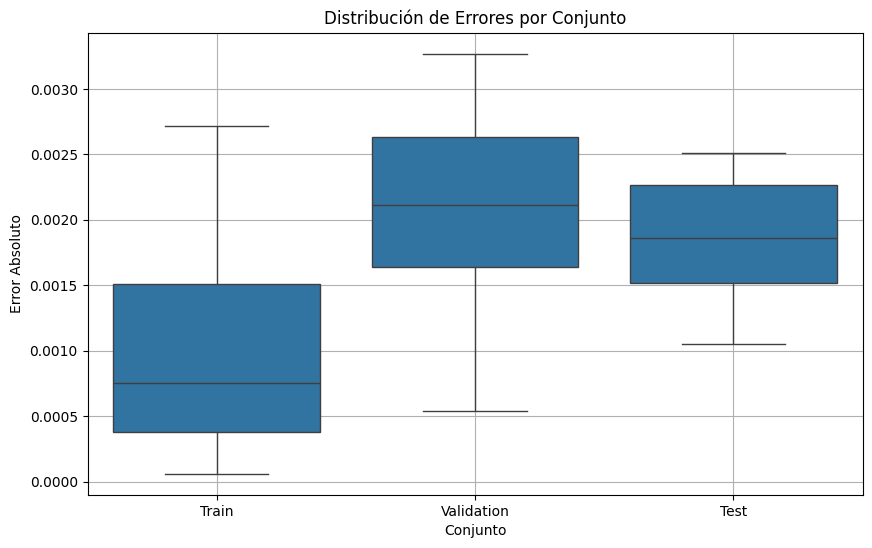

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Crear un DataFrame para almacenar los errores
errores_data = []

# Iterar sobre las variables y calcular errores
for variable in variables:
    print(f"Procesando errores para la variable: {variable}")
    
    X_test_best = divisiones[mejor_tau]['X_test'][mejor_pliegue - 1]
    y_test_best = divisiones[mejor_tau]['y_test'][mejor_pliegue - 1]
    
    y_train_pred = modelo.predict(X_train_best)
    y_val_pred = modelo.predict(X_val_best)
    y_test_pred = modelo.predict(X_test_best)

    # Calcular errores absolutos
    errores_train = np.abs(y_train_best - y_train_pred)
    errores_val = np.abs(y_val_best - y_val_pred)
    errores_test = np.abs(y_test_best - y_test_pred)

    errores_data.extend([
        {'Set': 'Train', 'Error': error, 'Variable': variable} for error in errores_train
    ])
    errores_data.extend([
        {'Set': 'Validation', 'Error': error, 'Variable': variable} for error in errores_val
    ])
    errores_data.extend([
        {'Set': 'Test', 'Error': error, 'Variable': variable} for error in errores_test
    ])

df_errores = pd.DataFrame(errores_data)

plt.figure(figsize=(10, 6))
sns.boxplot(x='Set', y='Error', data=df_errores)
plt.title('Distribución de Errores por Conjunto')
plt.xlabel('Conjunto')
plt.ylabel('Error Absoluto')
plt.grid(True)
plt.show()


El boxplot muestra la distribución de errores absolutos en los conjuntos de entrenamiento, validación y prueba. Las medianas son cercanas, lo que indica consistencia en el desempeño del modelo entre los conjuntos, aunque el conjunto de validación presenta una mayor dispersión, evidenciada por la amplitud del rango intercuartílico y la presencia de valores más extremos en comparación con los otros conjuntos. Esto sugiere que el modelo mantiene un desempeño estable, aunque podría estar enfrentando ligeros desafíos para generalizar en los datos de validación. 

## Regresion Lineal 

In [ ]:

resultados_completos = [] 
for ejercicio in ejercicios:
    for unidad in unidades:
        clave_entrenamiento = f'es{sujeto}e{ejercicio}u{unidad}'
        clave_prueba = f'ts{sujeto}e{ejercicio}u{unidad}'
   
        if clave_entrenamiento in datos_entrenamiento and clave_prueba in datos_prueba:
            divisiones = crear_pliegues(
                datos_entrenamiento[clave_entrenamiento],
                datos_prueba[clave_prueba],
                variables,
                tau_list
            )
            resultados = evaluar_modelo_lr(divisiones, tau_list)
            mejor_resultado = obtener_mejores_resultados(resultados, criterio='R2')
            resultados_completos.append(mejor_resultado)
        else:
            print(f"Claves no encontradas: {clave_entrenamiento} o {clave_prueba}")



  Evaluación para τ = 7

  Evaluación para τ = 14

  Evaluación para τ = 21

  Evaluación para τ = 28

  Evaluación para τ = 7

  Evaluación para τ = 14

  Evaluación para τ = 21

  Evaluación para τ = 28

  Evaluación para τ = 7

  Evaluación para τ = 14

  Evaluación para τ = 21

  Evaluación para τ = 28

  Evaluación para τ = 7

  Evaluación para τ = 14

  Evaluación para τ = 21

  Evaluación para τ = 28

  Evaluación para τ = 7

  Evaluación para τ = 14

  Evaluación para τ = 21

  Evaluación para τ = 28

  Evaluación para τ = 7

  Evaluación para τ = 14

  Evaluación para τ = 21

  Evaluación para τ = 28

  Evaluación para τ = 7

  Evaluación para τ = 14

  Evaluación para τ = 21

  Evaluación para τ = 28

  Evaluación para τ = 7

  Evaluación para τ = 14

  Evaluación para τ = 21

  Evaluación para τ = 28

  Evaluación para τ = 7

  Evaluación para τ = 14

  Evaluación para τ = 21

  Evaluación para τ = 28


### Mejores Modelos

In [ ]:
pd.DataFrame(resultados_completos)

Ventana  pliegue           MSE      RMSE        MAPE        R2  \
487       7.0    488.0  1.330995e-04  0.011537    0.093420  0.791331   
541       7.0    542.0  9.960658e-04  0.031561    1.633014  0.834464   
1378      7.0   1379.0  4.794075e-04  0.021895    6.253765  0.801632   
2138      7.0   2139.0  7.485015e-06  0.002736  150.096968  0.824004   
1430      7.0   1431.0  4.437604e-06  0.002107   43.965489  0.784630   
491       7.0    492.0  2.038298e-05  0.004515   41.303151  0.881099   
1214      7.0   1215.0  2.625645e-07  0.000512    0.075749  0.676455   
233       7.0    234.0  3.346895e-08  0.000183    0.029638  0.933318   
5199     21.0    889.0  1.263145e-06  0.001124    1.197691  0.868569   

      Ljung-Box (p-value)  Jarque-Bera (p-value) variable  
487              0.210613               0.963471    acc_x  
541              0.189027               0.749329    acc_y  
1378             0.031467               0.665750    acc_z  
2138             0.474754               0.638568    gyr_x  
1430             0.283151               0.689422    gyr_y  
491              0.710278               0.856885    gyr_z  
1214             0.947748               0.095284    mag_x  
233              0.328730               0.621725    mag_y  
5199             0.650509               0.955475    mag_z

Los resultados de la regresión lineal muestran un desempeño moderado en términos de \( R^2 \), con valores que oscilan entre 0.67 y 0.93, dependiendo de la variable analizada. Esto indica que el modelo es capaz de explicar entre el 67% y el 93% de la variabilidad de las variables respuesta. Las métricas de error cuadrático medio \( MSE \) y su raíz \( RMSE \) son bajas para la mayoría de las variables, lo que refleja una buena precisión general del modelo.

En términos de la normalidad y la independencia de los residuos, las pruebas de Jarque-Bera y Ljung-Box muestran p-valores que en su mayoría son aceptables, indicando residuos independientes y generalmente normales. Sin embargo, en ciertas variables como `acc_z` y `gyr_x`, los p-valores más bajos podrían sugerir ligeras desviaciones de estos supuestos.

### Residuos

En este fragmento de código, se genera un análisis detallado de los residuos para cada variable y configuración óptima (τ y pliegue) identificada previamente en los resultados del modelo. Para cada combinación óptima, se seleccionan los conjuntos de entrenamiento, validación y prueba correspondientes. Luego, se ajusta un modelo de regresión lineal utilizando los datos de entrenamiento y se realiza la predicción sobre los datos de validación. Los residuos (diferencia entre valores reales y predichos) se calculan y se transforman en un arreglo numérico. Finalmente, se genera un gráfico diagnóstico de los residuos, que permite analizar su comportamiento y verificar si cumplen con los supuestos de independencia y normalidad, ofreciendo una visión clara del desempeño del modelo bajo las condiciones óptimas seleccionadas.


Generando gráfico de residuos para la variable: acc_x, τ=7.0, pliegue=488


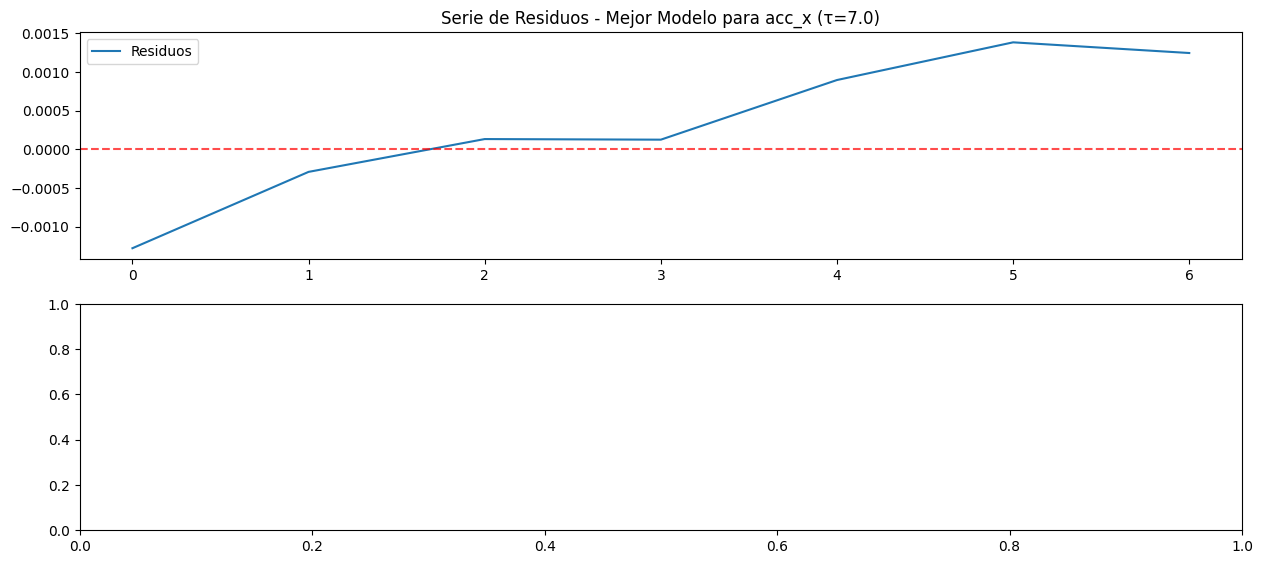

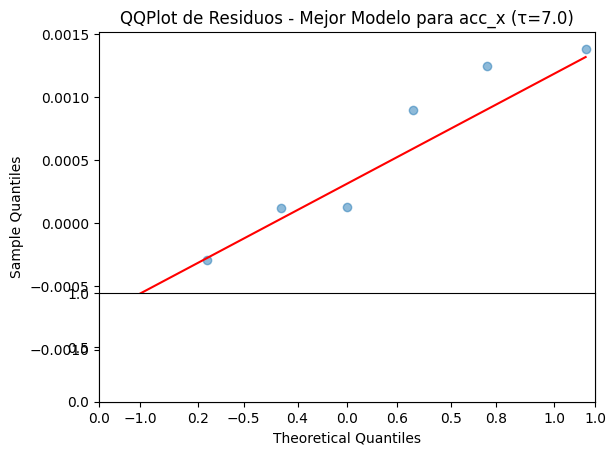

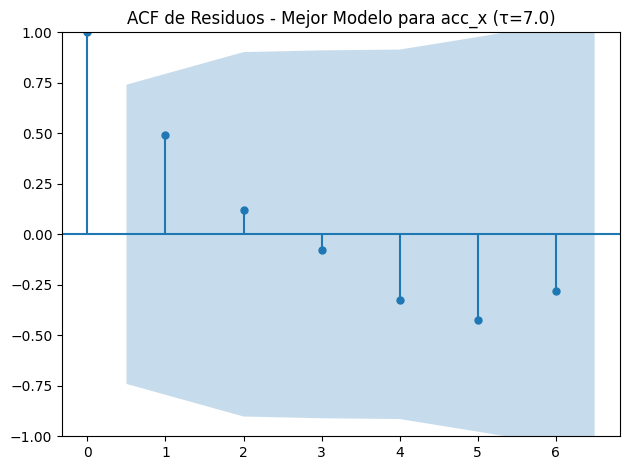


Generando gráfico de residuos para la variable: acc_y, τ=7.0, pliegue=542


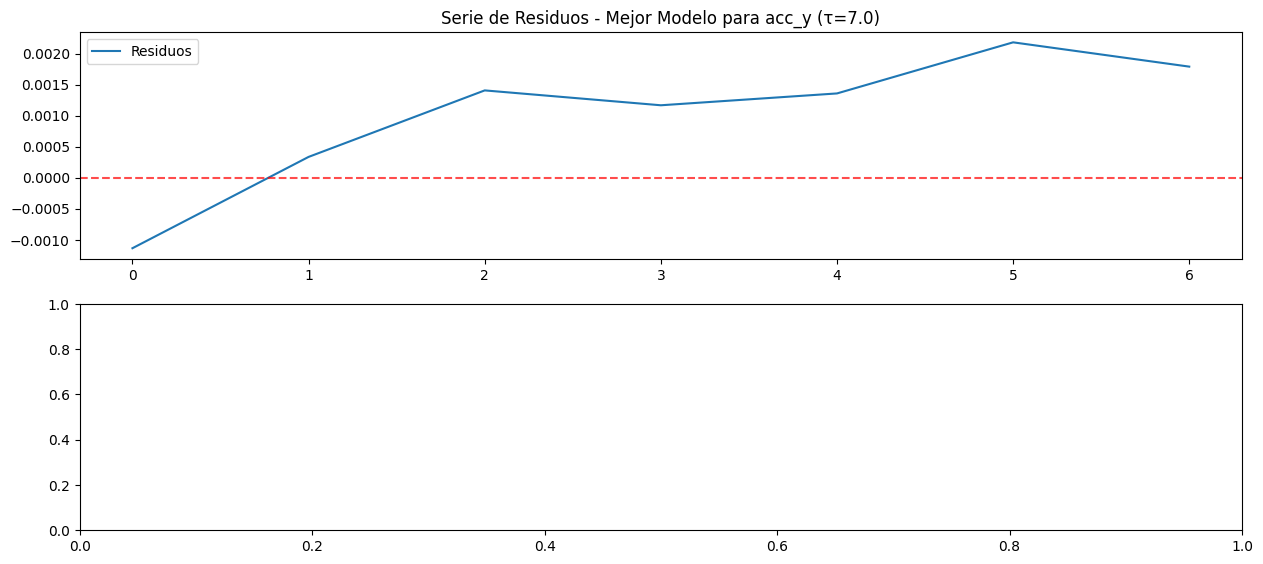

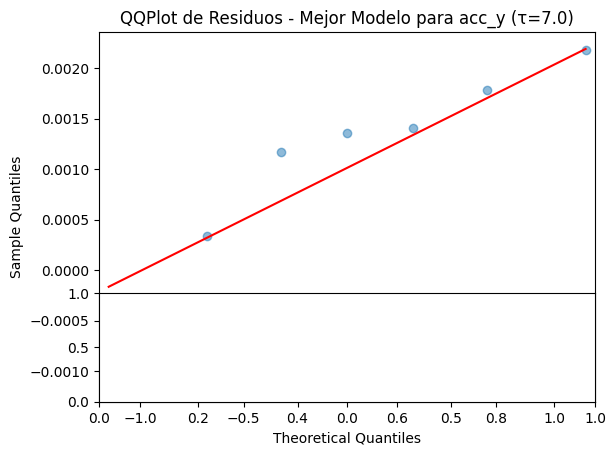

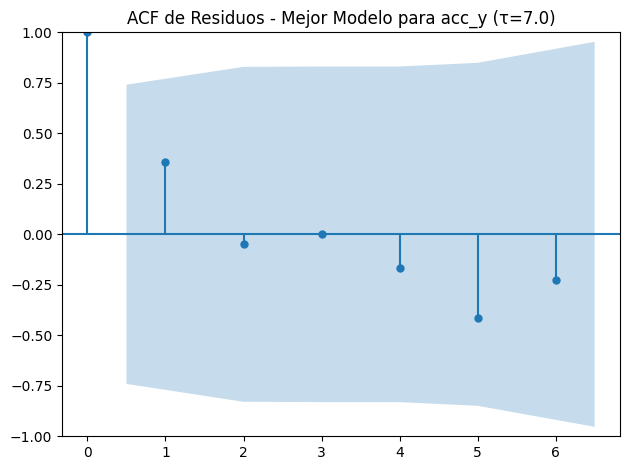


Generando gráfico de residuos para la variable: acc_z, τ=7.0, pliegue=1379


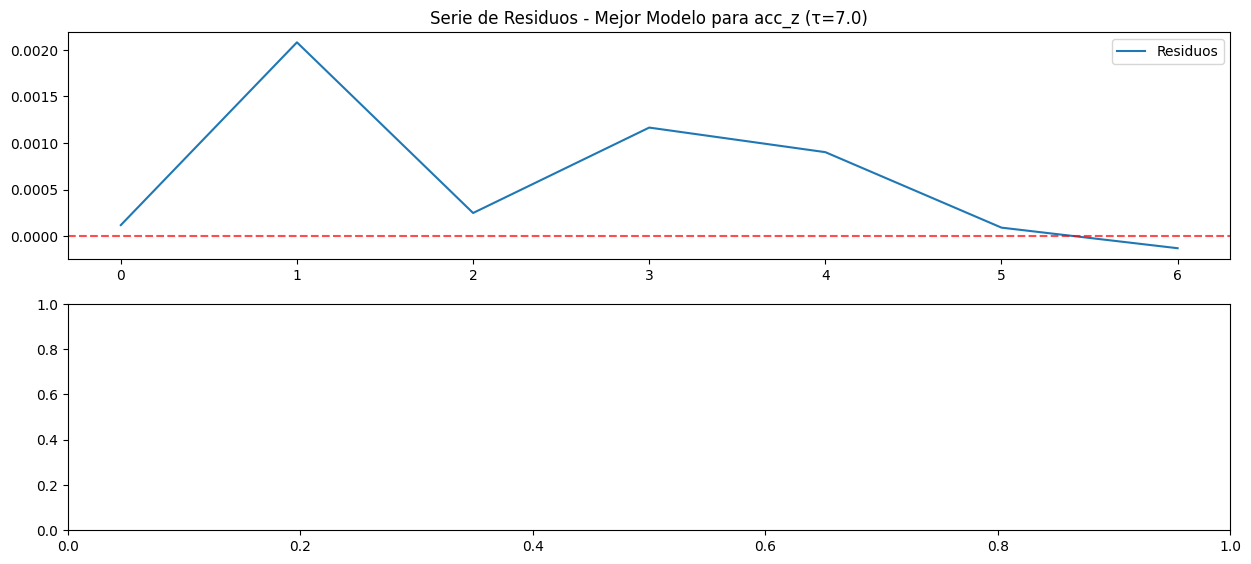

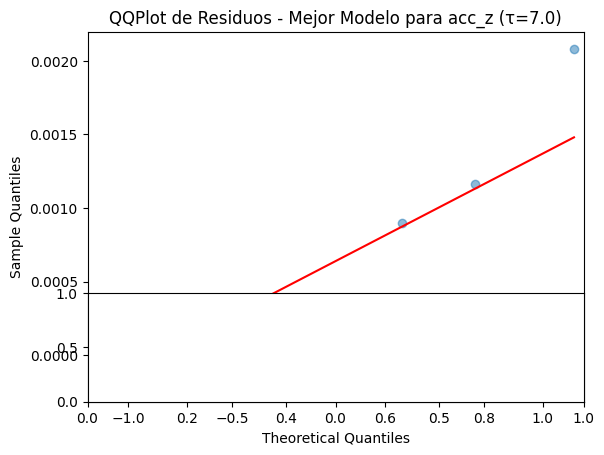

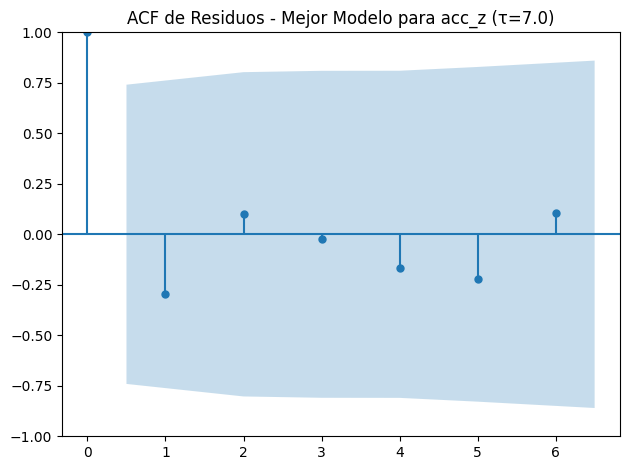


Generando gráfico de residuos para la variable: gyr_x, τ=7.0, pliegue=2139


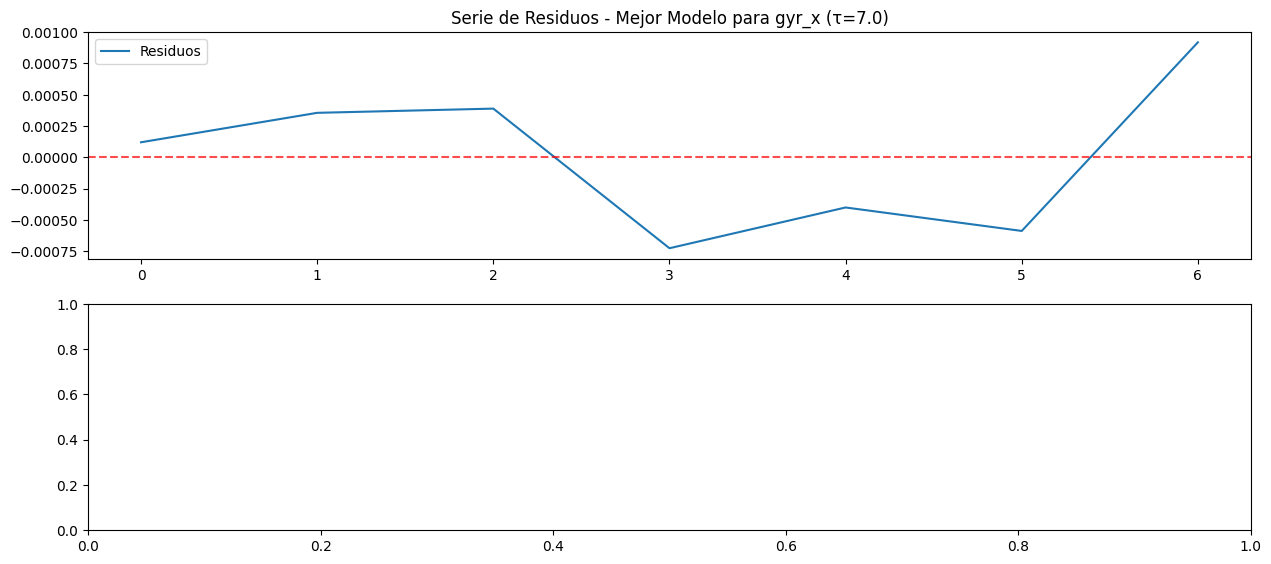

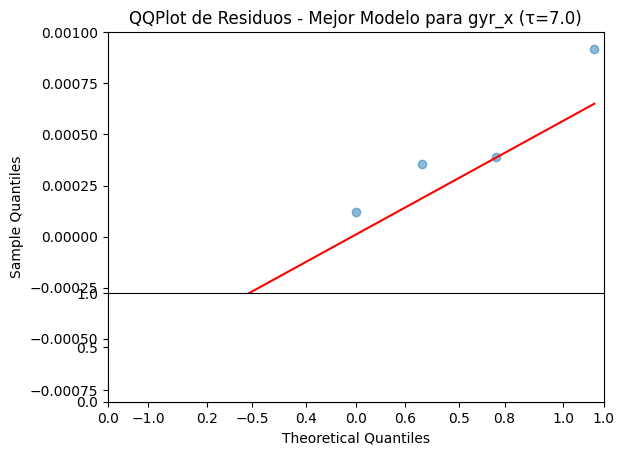

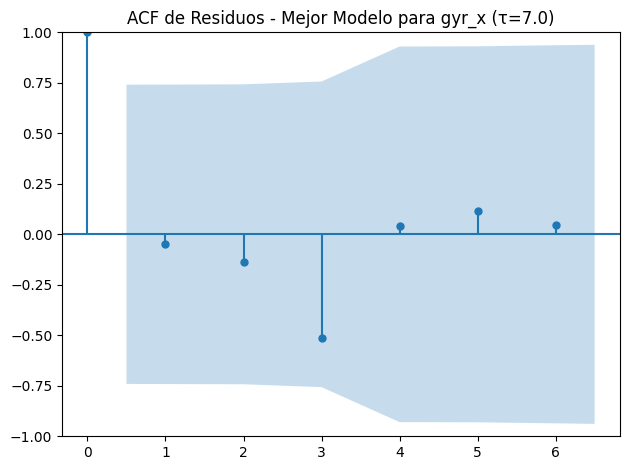


Generando gráfico de residuos para la variable: gyr_y, τ=7.0, pliegue=1431


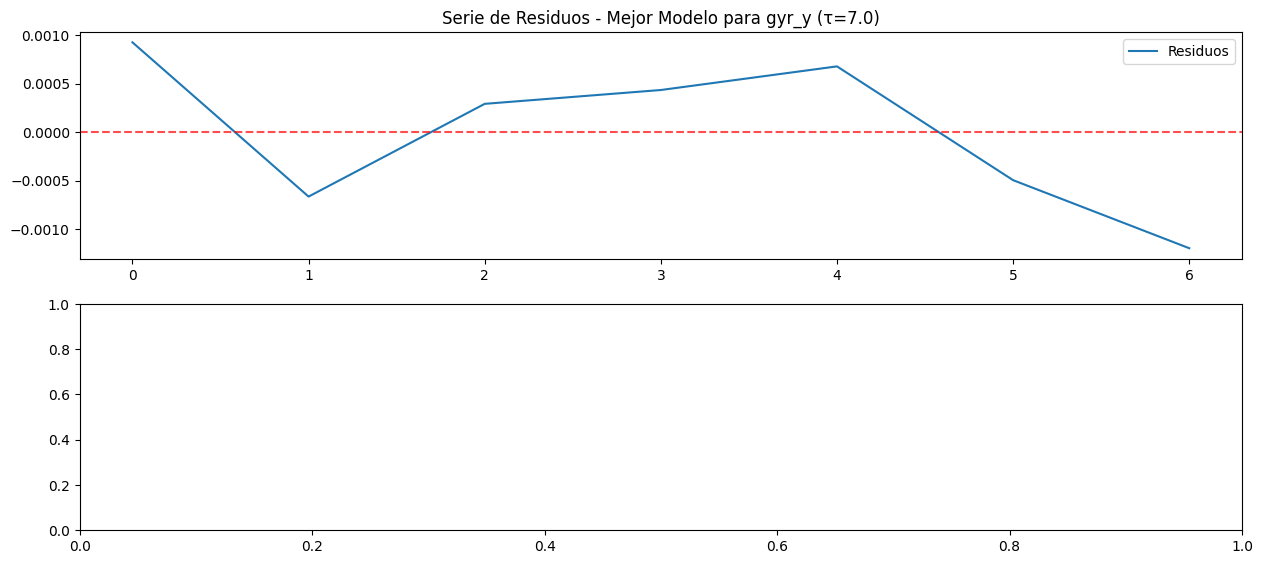

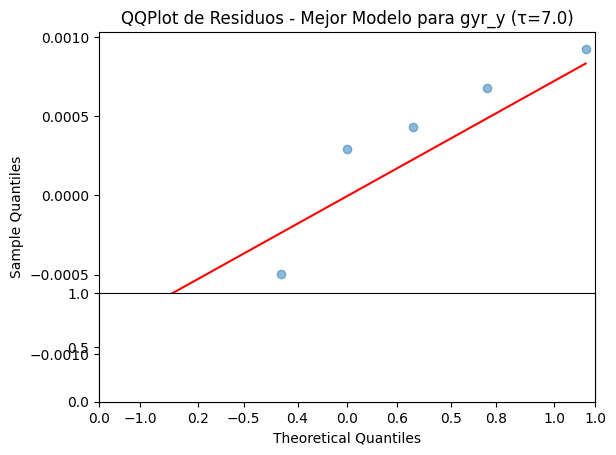

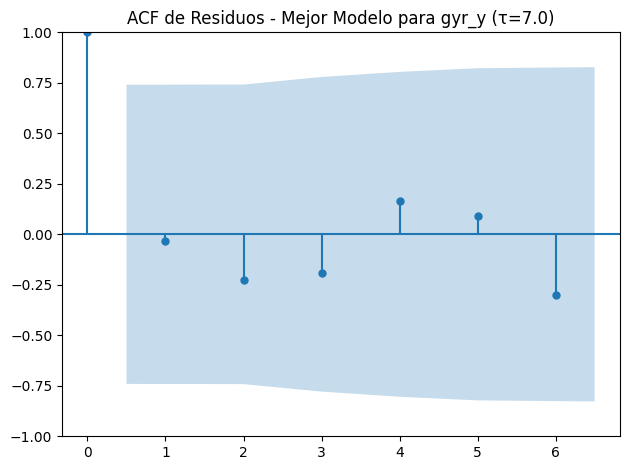


Generando gráfico de residuos para la variable: gyr_z, τ=7.0, pliegue=492


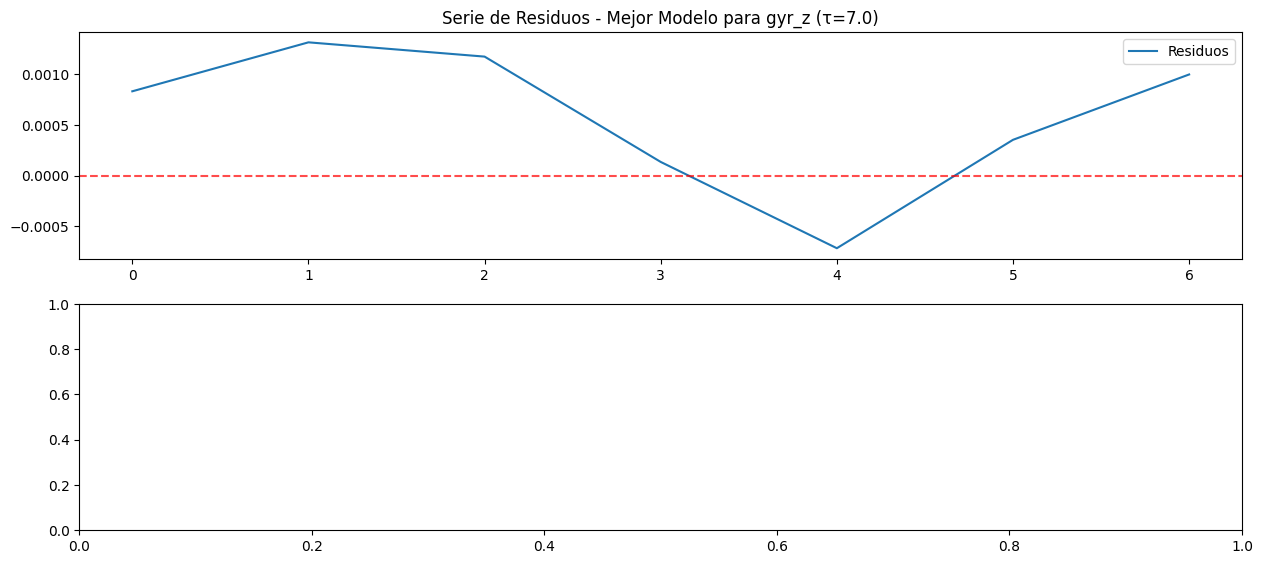

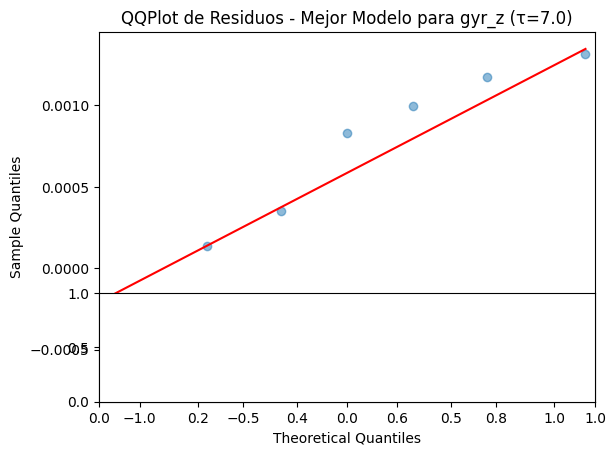

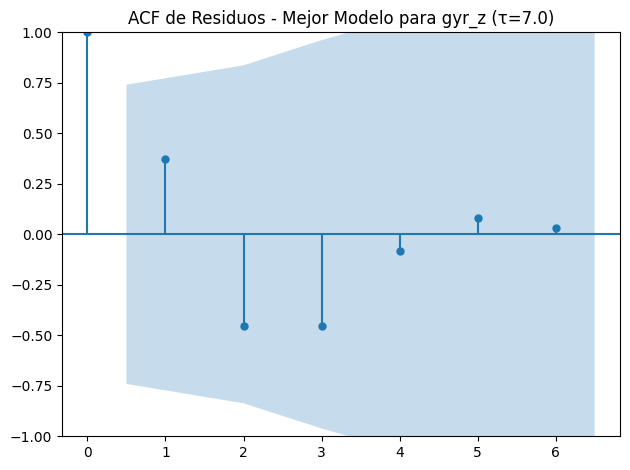


Generando gráfico de residuos para la variable: mag_x, τ=7.0, pliegue=1215


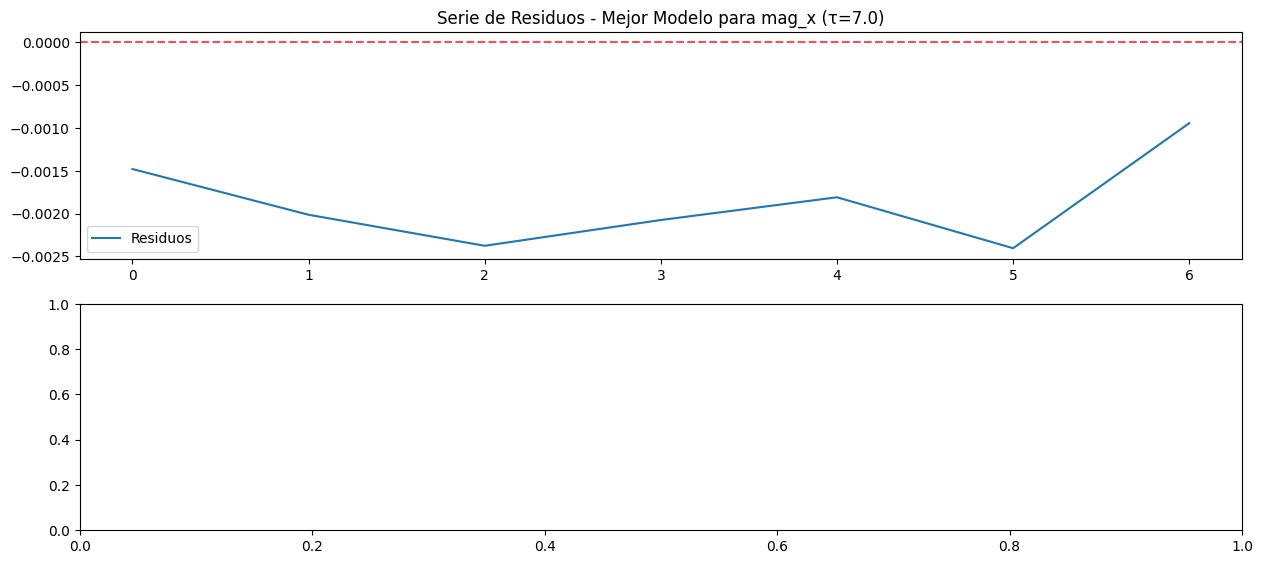

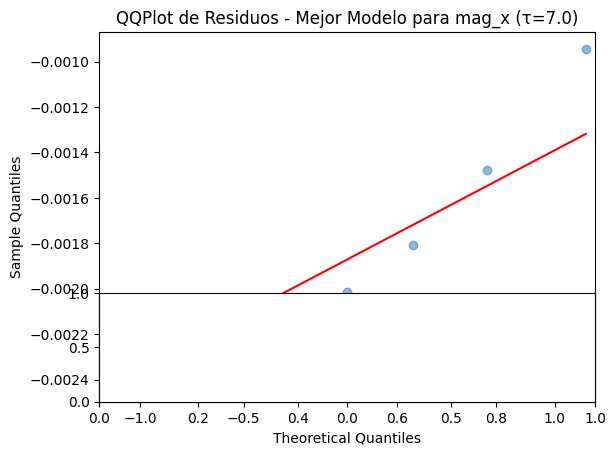

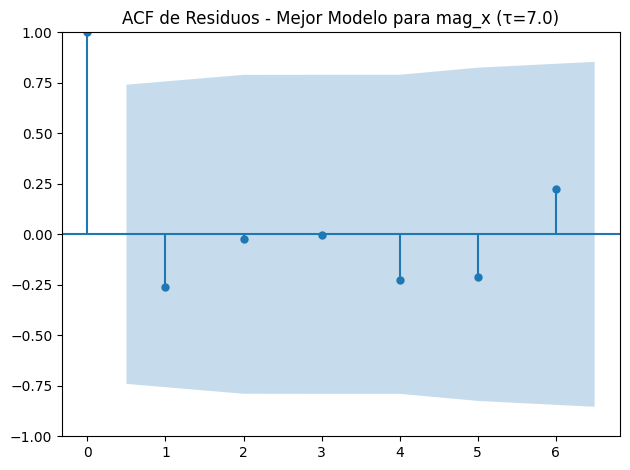


Generando gráfico de residuos para la variable: mag_y, τ=7.0, pliegue=234


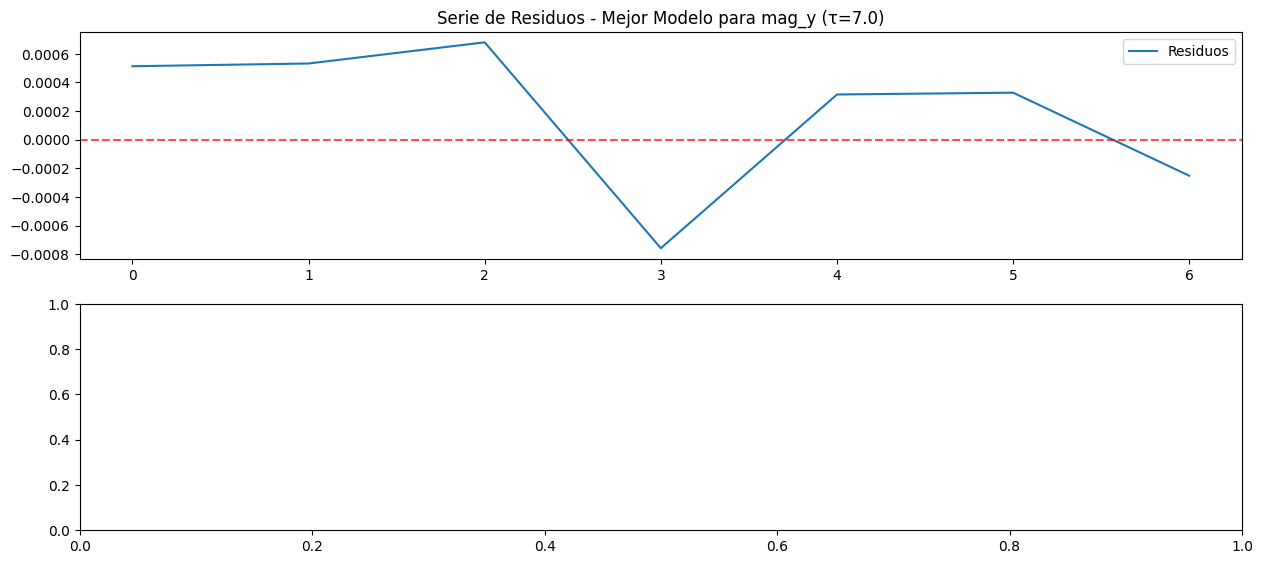

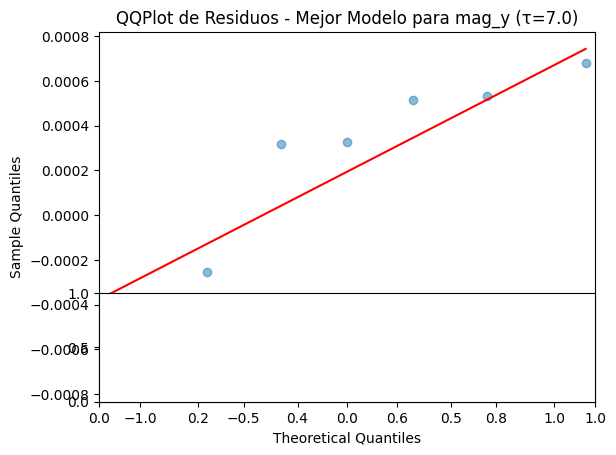

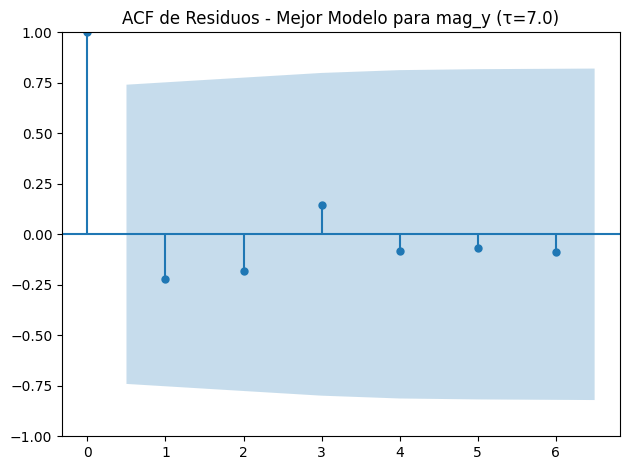


Generando gráfico de residuos para la variable: mag_z, τ=21.0, pliegue=889


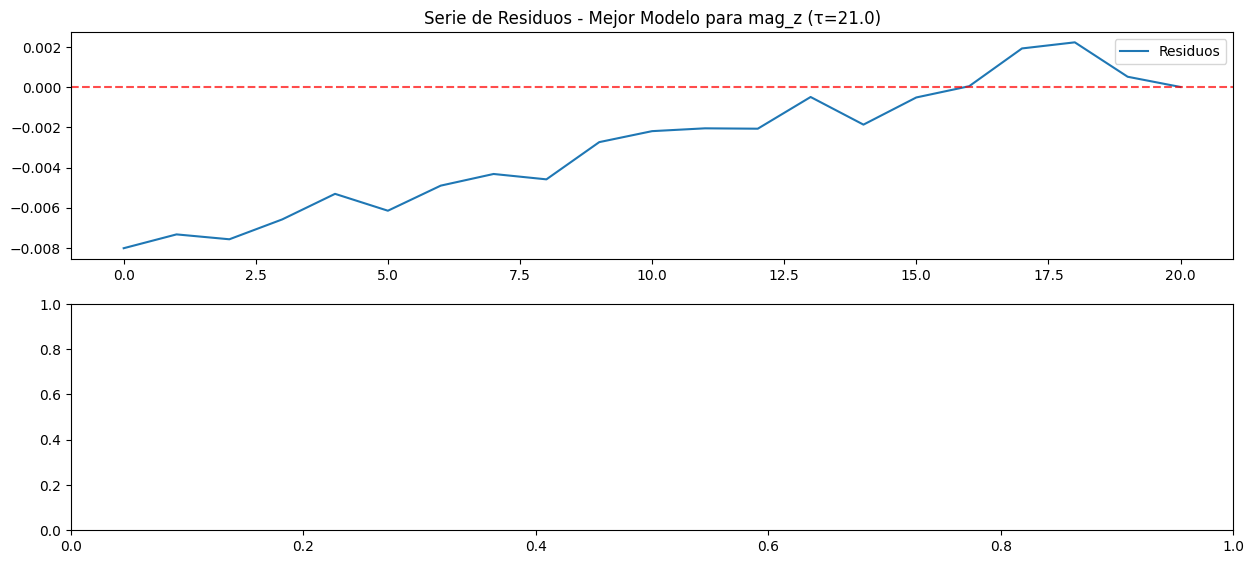

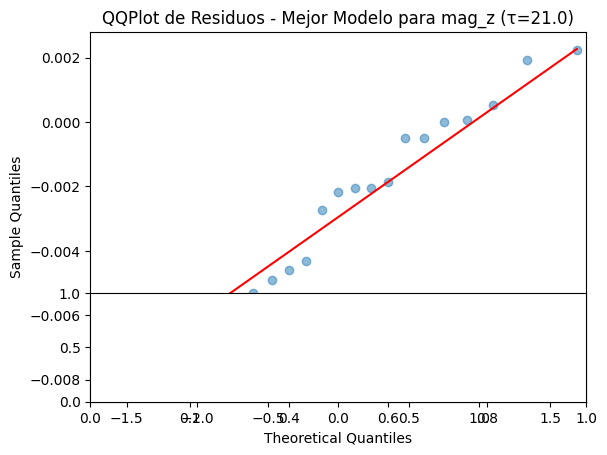

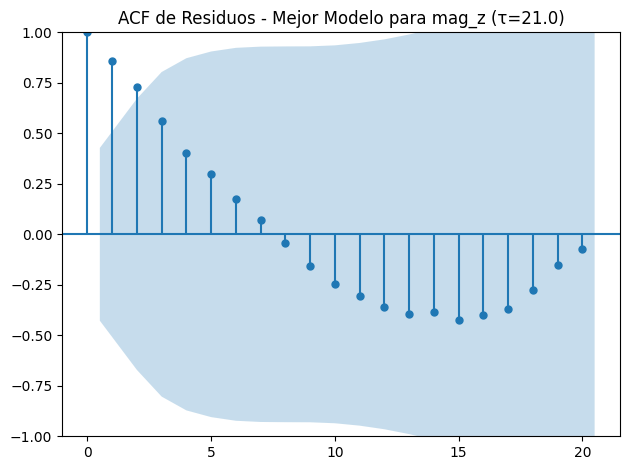

In [ ]:
for index, row in resultados_completos.iterrows():
    variable = row['variable']
    mejor_tau = row['Ventana']  
    mejor_pliegue = int(row['pliegue']) 

    print(f"\nGenerando gráfico de residuos para la variable: {variable}, τ={mejor_tau}, pliegue={mejor_pliegue}")
    
    X_train_best = divisiones[mejor_tau]['X_train'][mejor_pliegue - 1]
    y_train_best = divisiones[mejor_tau]['y_train'][mejor_pliegue - 1]
    X_val_best = divisiones[mejor_tau]['X_val'][mejor_pliegue - 1]
    y_val_best = divisiones[mejor_tau]['y_val'][mejor_pliegue - 1]
    X_test_best = divisiones[mejor_tau]['X_test'][mejor_pliegue - 1]
    y_test_best = divisiones[mejor_tau]['y_test'][mejor_pliegue - 1]

    modelo_best = LinearRegression() 
    modelo_best.fit(X_train_best, y_train_best)

    y_pred_best = modelo_best.predict(X_val_best)
    residuos_best = y_val_best - y_pred_best
    residuos_best = np.array(residuos_best)

    # Generar el gráfico para los residuos
    graficar_diagnostico_residuos(
        residuos_best, 
        nombre_modelo=f"Mejor Modelo para {variable} (τ={mejor_tau})"
    )

Los gráficos de los residuos para las diferentes variables muestran ciertas desviaciones respecto a la línea de referencia, lo que sugiere que los residuos no siguen estrictamente una distribución normal. Las variables como `acc_x`, `acc_y` y `gyr_z` presentan un ajuste más cercano a la normalidad, con puntos alineados en su mayoría a la línea teórica, aunque hay ligeras desviaciones en los extremos. Esto es más evidente en algunas variables, donde la presencia de valores atípicos o comportamientos no lineales podrían estar influyendo en la calidad del ajuste. 

### Boxplot

La visualización de los errores absolutos para los conjuntos de datos de entrenamiento, validación y prueba de las diferentes variables evaluadas. Se genera una tabla consolidada de errores de los mejores modelos anteriormente mostrados en la tabla y se presenta un gráfico de caja (boxplot) que resume la distribución de los errores por conjunto.

Procesando errores para la variable: acc_x
Procesando errores para la variable: acc_y
Procesando errores para la variable: acc_z
Procesando errores para la variable: gyr_x
Procesando errores para la variable: gyr_y
Procesando errores para la variable: gyr_z
Procesando errores para la variable: mag_x
Procesando errores para la variable: mag_y
Procesando errores para la variable: mag_z


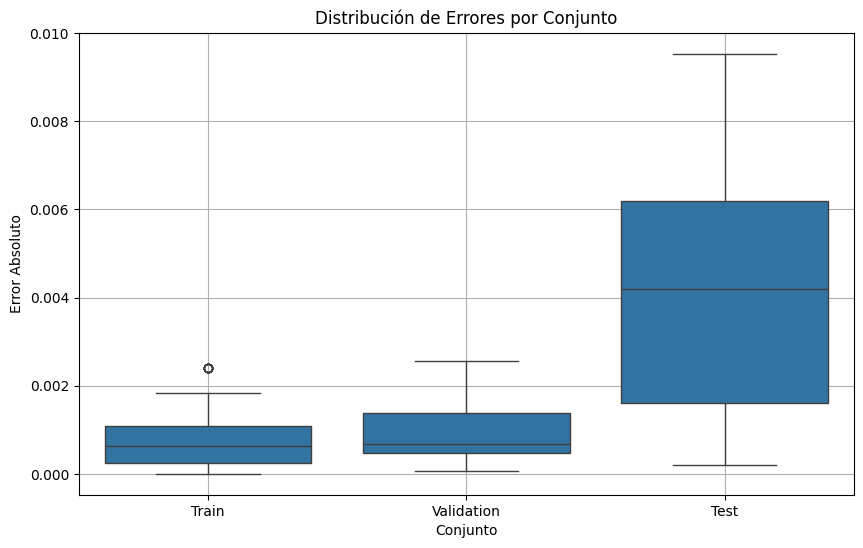

In [ ]:
errores_data = []

for variable in variables:
    print(f"Procesando errores para la variable: {variable}")
    
    y_train_pred = modelo_best.predict(X_train_best)
    y_val_pred = modelo_best.predict(X_val_best)
    y_test_pred = modelo_best.predict(X_test_best)

    errores_train = np.abs(y_train_best - y_train_pred)
    errores_val = np.abs(y_val_best - y_val_pred)
    errores_test = np.abs(y_val_best - y_test_pred)

    errores_data.extend([
        {'Set': 'Train', 'Error': error, 'Variable': variable} for error in errores_train
    ])
    errores_data.extend([
        {'Set': 'Validation', 'Error': error, 'Variable': variable} for error in errores_val
    ])
    errores_data.extend([
        {'Set': 'Test', 'Error': error, 'Variable': variable} for error in errores_test
    ])

df_errores = pd.DataFrame(errores_data)
plt.figure(figsize=(10, 6))
sns.boxplot(x='Set', y='Error', data=df_errores)
plt.title('Distribución de Errores por Conjunto')
plt.xlabel('Conjunto')
plt.ylabel('Error Absoluto')
plt.grid(True)
plt.show()


Se observa que los errores absolutos en el conjunto de entrenamiento y validación son bajos y presentan una distribución consistente, con medianas cercanas y rangos intercuartílicos estrechos. Esto sugiere que el modelo tiene un buen desempeño en estos dos conjuntos, indicando que logra capturar patrones en los datos de manera adecuada sin evidenciar sobreajuste significativo. Sin embargo, el conjunto de prueba muestra una mayor dispersión en los errores, con una mediana más elevada y un rango intercuartílico amplio, lo que indica desafíos en la capacidad del modelo para generalizar a datos nuevos.

## Regresion Ridge

Evaluamos los mejores resultados para cada combinación de ejercicio y unidad en el conjunto de datos. El objetivo principal es ajustar y evaluar un modelo de regresión ridge para cada caso, considerando las divisiones temporales creadas previamente.

In [ ]:
resultados_completos = [] 
for ejercicio in ejercicios:
    for unidad in unidades:
        clave_entrenamiento = f'es{sujeto}e{ejercicio}u{unidad}'
        clave_prueba = f'ts{sujeto}e{ejercicio}u{unidad}'
   
        if clave_entrenamiento in datos_entrenamiento and clave_prueba in datos_prueba:
            divisiones = crear_pliegues(
                datos_entrenamiento[clave_entrenamiento],
                datos_prueba[clave_prueba],
                variables,
                tau_list
            )
            resultados = evaluar_modelo_ridge(divisiones, tau_list)
            mejor_resultado = obtener_mejores_resultados(resultados, criterio='R2')
            resultados_completos.append(mejor_resultado)
        else:
            print(f"Claves no encontradas: {clave_entrenamiento} o {clave_prueba}")


### Mejores modelos

In [ ]:
pd.DataFrame(resultados_completos)

Ventana  pliegue       MSE      RMSE       MAPE        R2  \
254       7.0    255.0  0.006749  0.082150   0.753867  0.962056   
3604     14.0   1439.0  0.020130  0.141880   1.518230  0.972473   
7509     28.0   1075.0  0.003701  0.060834  15.215547  0.988402   
3356     14.0   1191.0  0.000591  0.024313  44.092825  0.751647   
2691     14.0    526.0  0.000316  0.017771   5.903995  0.980688   
3102     14.0    937.0  0.006459  0.080371   9.722477  0.921881   
5469     21.0   1159.0  0.000085  0.009202  11.059970  0.995087   
5276     21.0    966.0  0.000144  0.011986   1.749762  0.983856   
4062     14.0   1897.0  0.000003  0.001629   1.284298  0.991375   

      Ljung-Box (p-value)  Jarque-Bera (p-value) variable  
254          2.202011e-01           7.313257e-01    acc_x  
3604         5.161487e-01           7.003042e-01    acc_y  
7509         9.772105e-01           1.624521e-18    acc_z  
3356         2.056463e-01           5.637408e-01    gyr_x  
2691         1.400305e-01           9.832854e-01    gyr_y  
3102         3.892470e-04           7.625570e-01    gyr_z  
5469         4.216133e-08           6.015002e-01    mag_x  
5276         9.916880e-04           5.729994e-01    mag_y  
4062         1.269594e-02           6.367795e-01    mag_z

El análisis de las métricas refleja un desempeño sólido del modelo, con altos valores de \(R^2\) en variables como acc_x \(0.962\), acc_y \(0.972\), acc_z \(0.988\) y mag_x\(0.995\), lo que indica una excelente capacidad para explicar la variabilidad de los datos. Las métricas de error, como MSE y RMSE, se mantienen bajas en la mayoría de los casos, aunque valores elevados de MAPE en acc_z (15.22%) y gyr_x (44.09%) destacan áreas de mejora en precisión relativa. Las pruebas de Ljung-Box y Jarque-Bera confirman la independencia y normalidad de los residuos en la mayoría de las variables. En general, el modelo es predictivamente confiable.

### Residuos

Este fragmento de código se utiliza para analizar los residuos del mejor modelo identificado para cada variable, basándose en la mejor ventana temporal (τ) y el pliegue seleccionados previamente en los resultados completos. 


Generando gráfico de residuos para la variable: acc_x, τ=7.0, pliegue=255


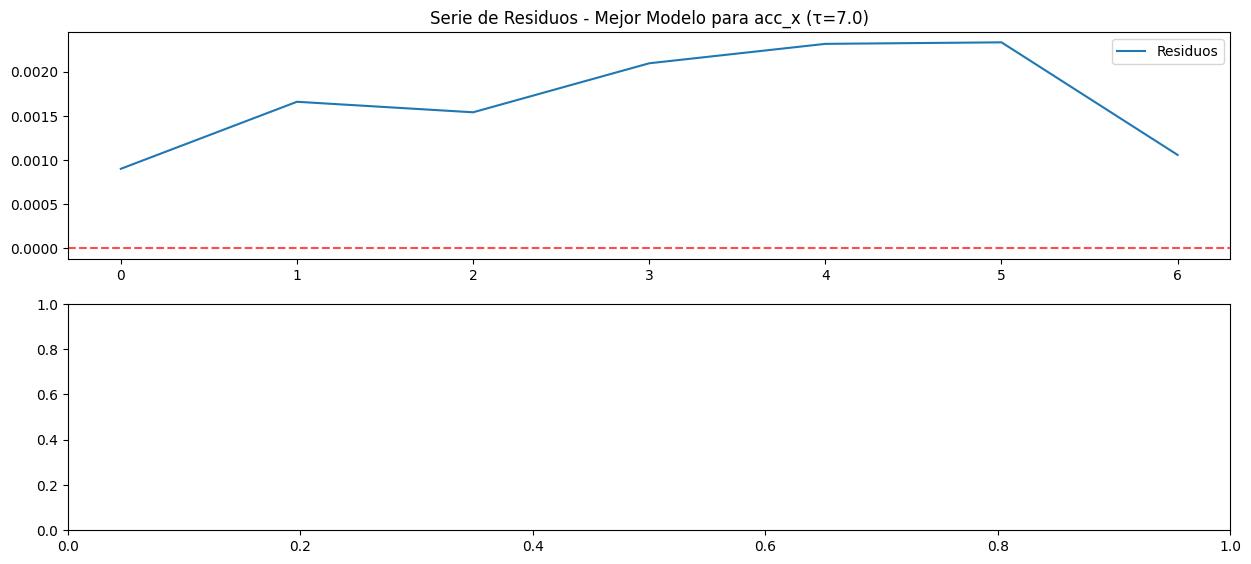

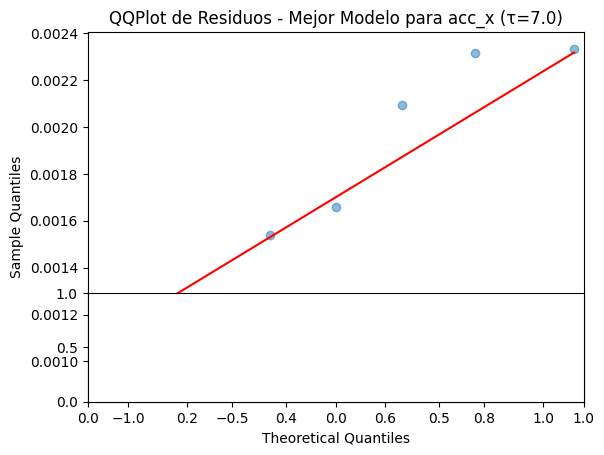

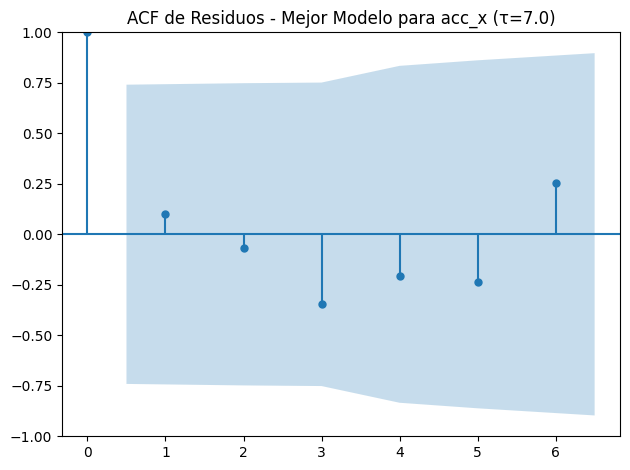


Generando gráfico de residuos para la variable: acc_y, τ=14.0, pliegue=1439


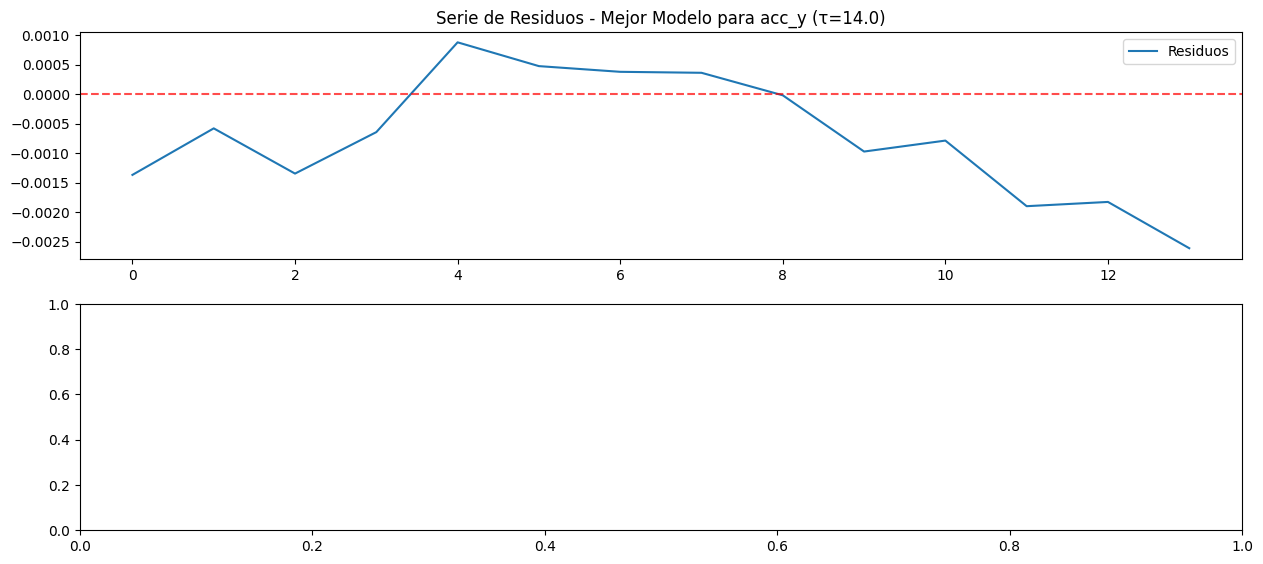

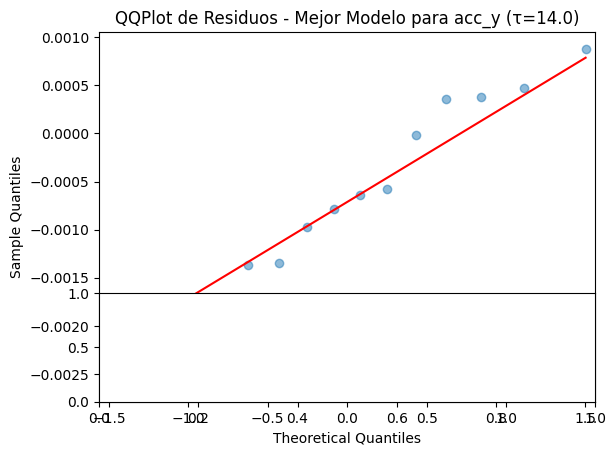

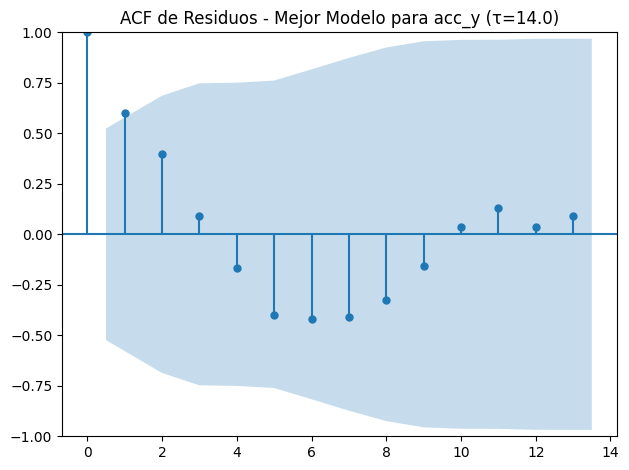


Generando gráfico de residuos para la variable: acc_z, τ=28.0, pliegue=1075


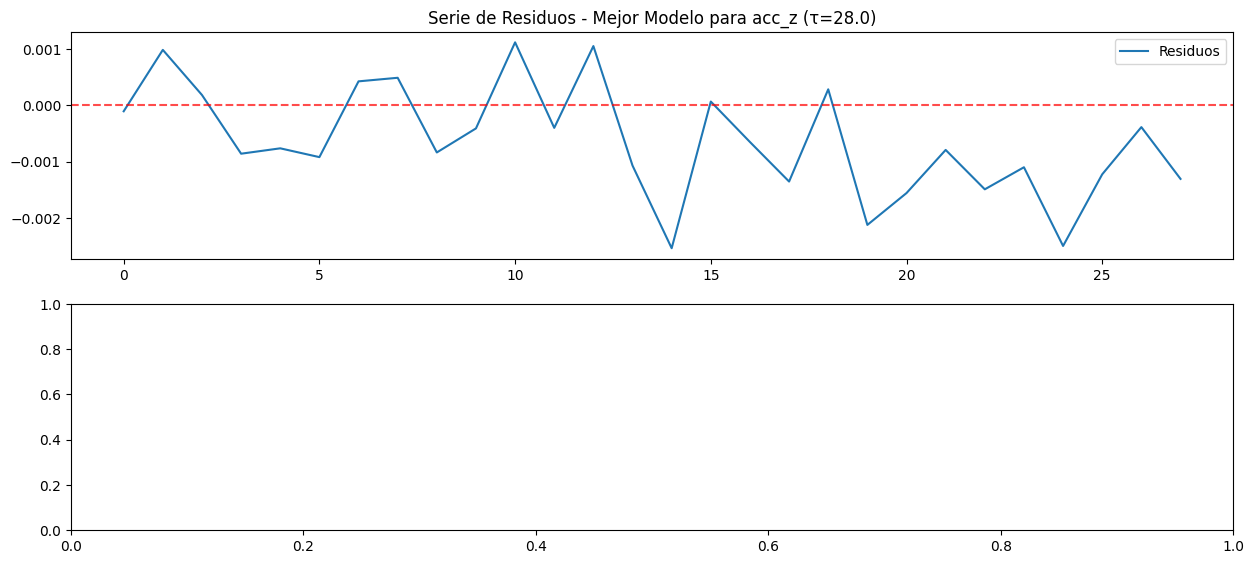

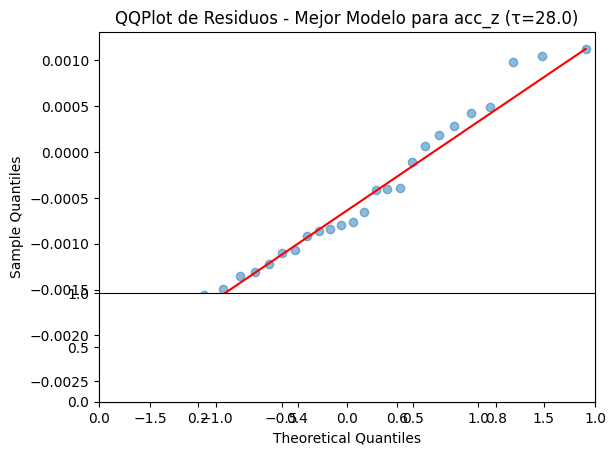

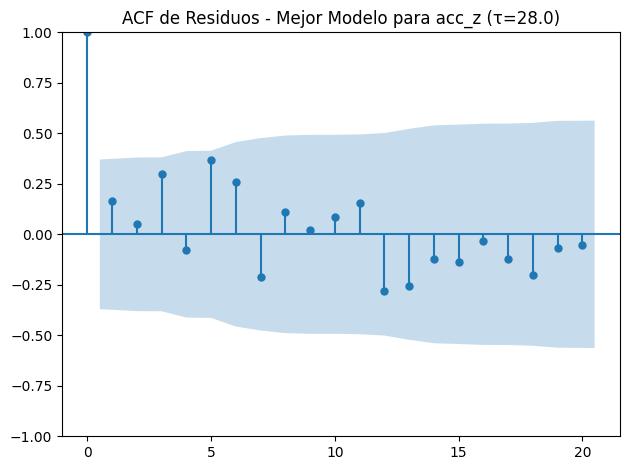


Generando gráfico de residuos para la variable: gyr_x, τ=14.0, pliegue=1191


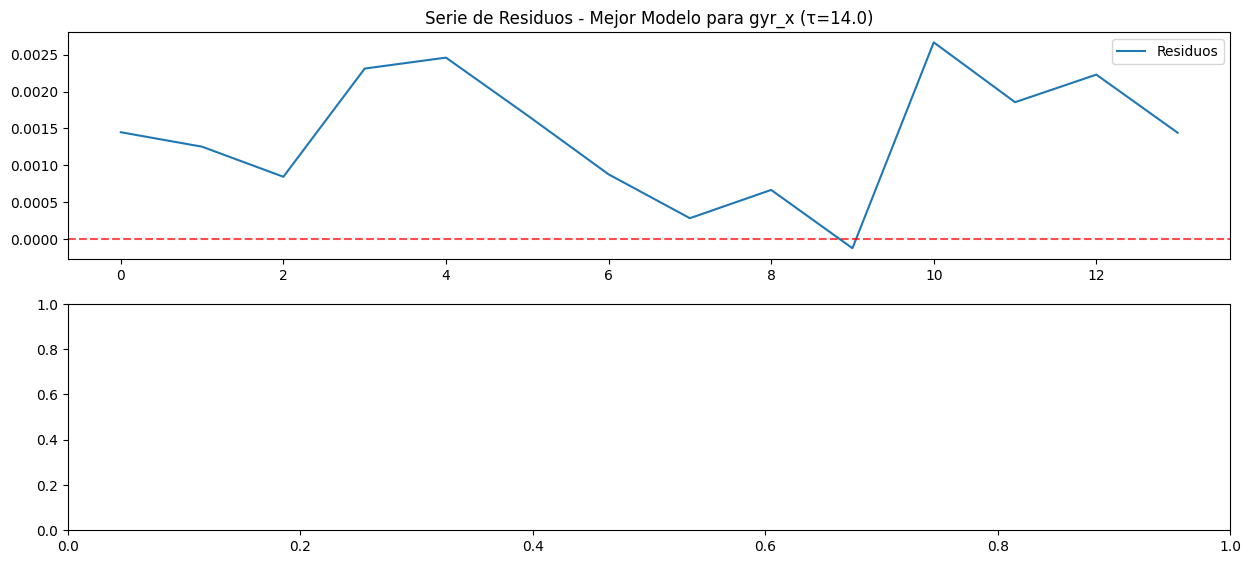

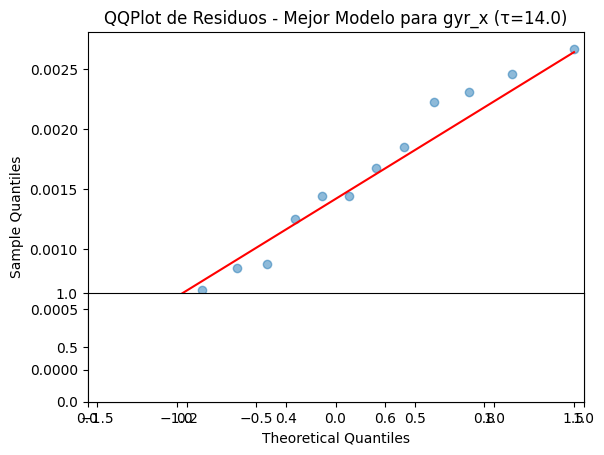

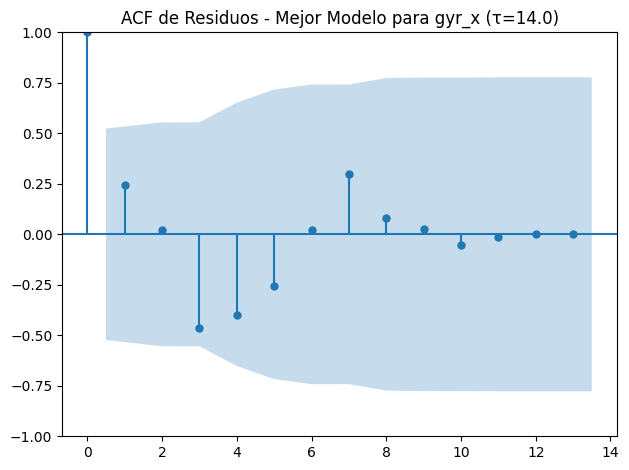


Generando gráfico de residuos para la variable: gyr_y, τ=14.0, pliegue=526


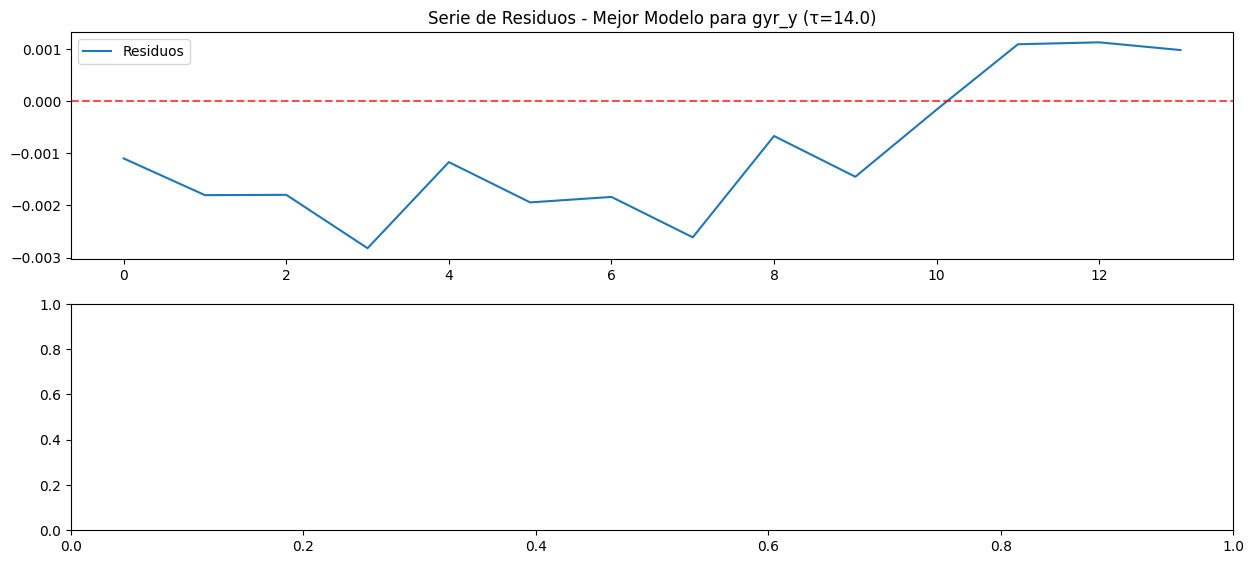

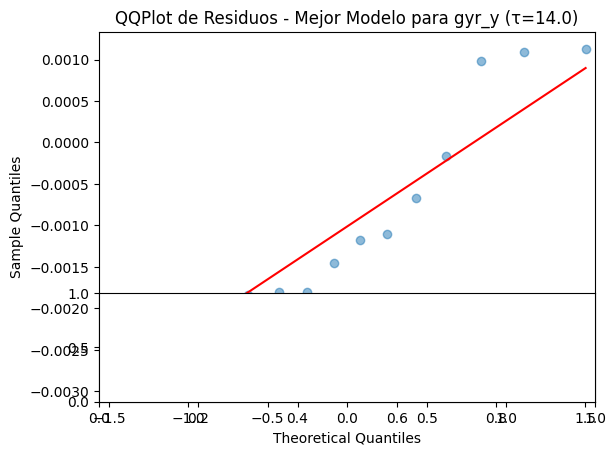

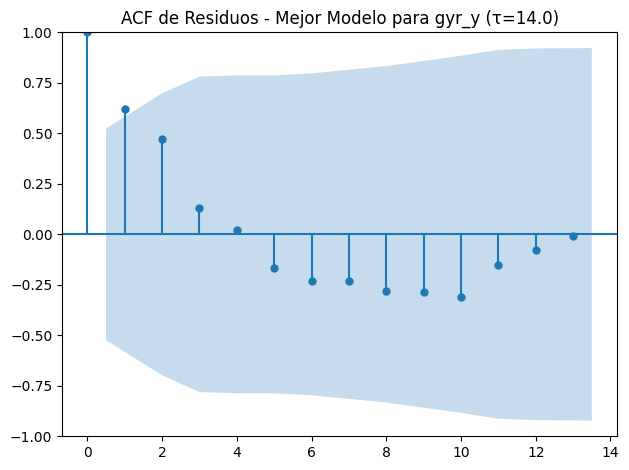


Generando gráfico de residuos para la variable: gyr_z, τ=14.0, pliegue=937


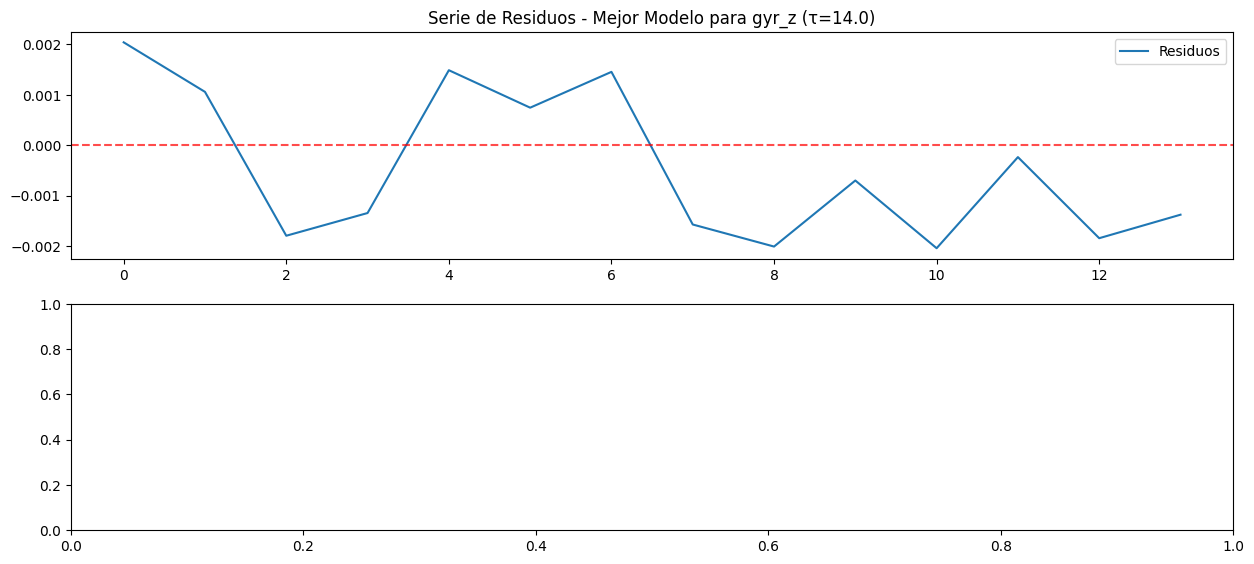

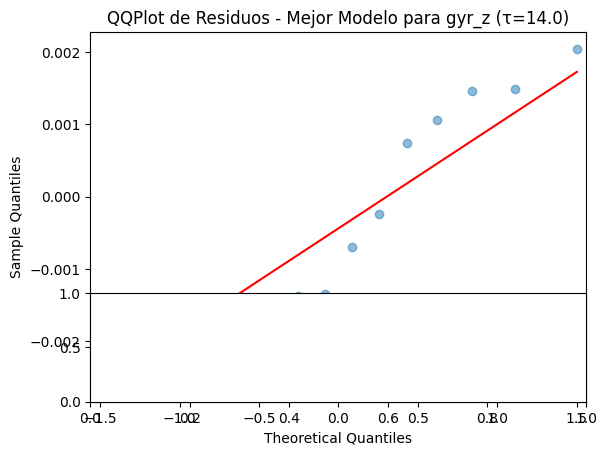

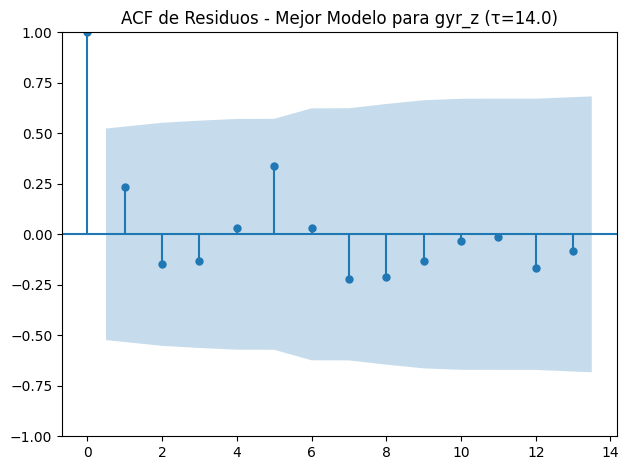


Generando gráfico de residuos para la variable: mag_x, τ=21.0, pliegue=1159


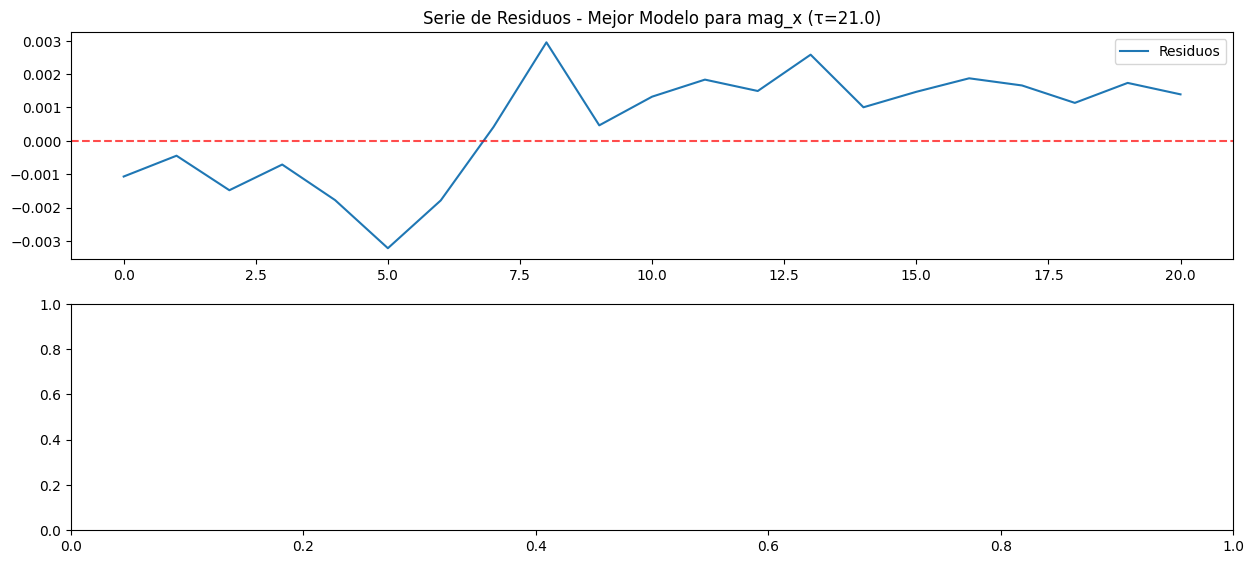

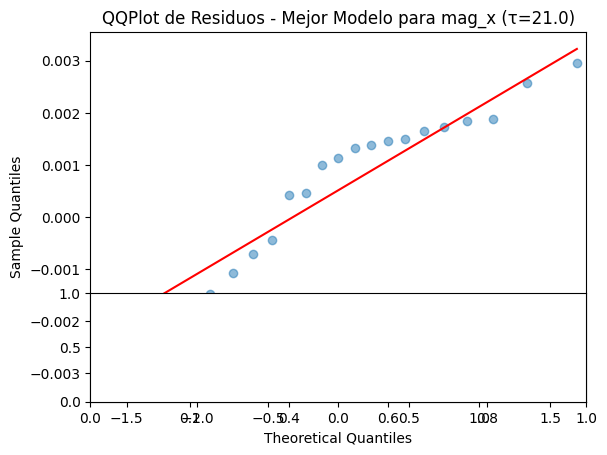

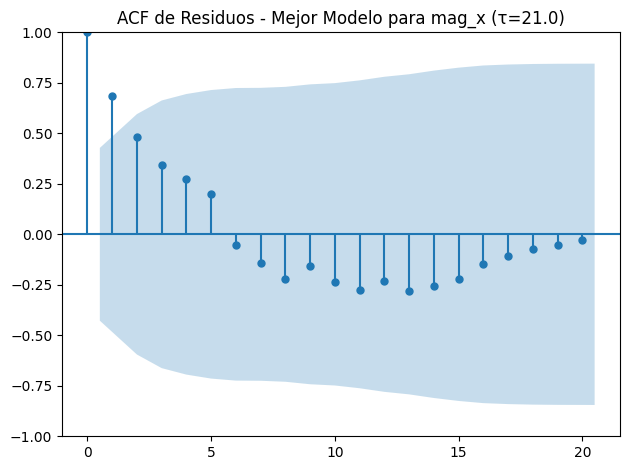


Generando gráfico de residuos para la variable: mag_y, τ=21.0, pliegue=966


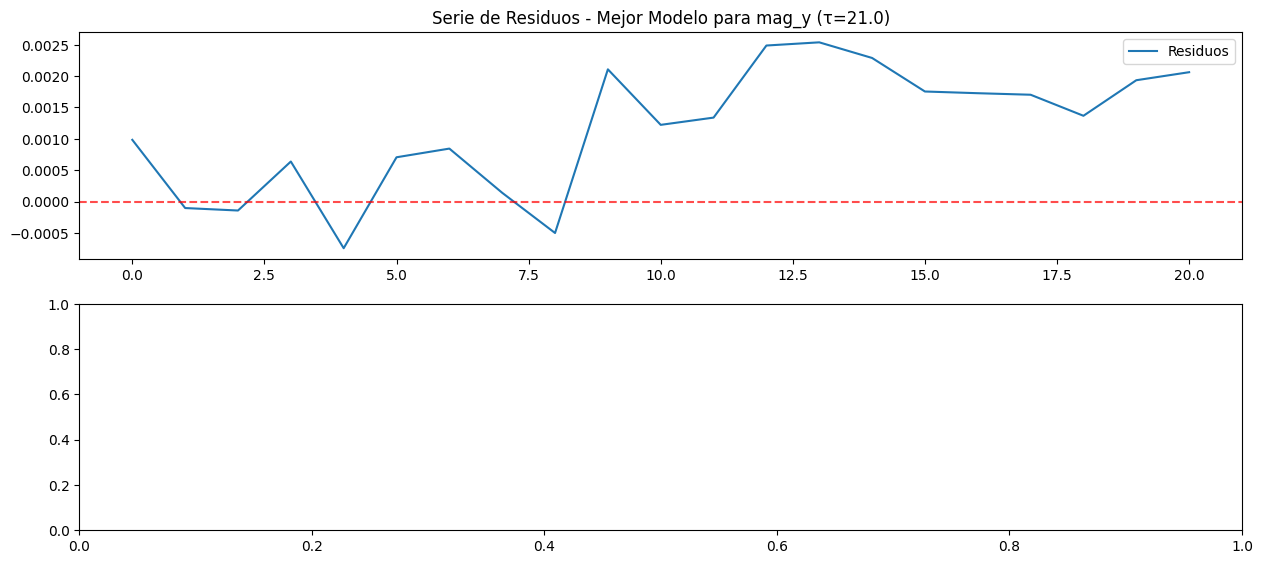

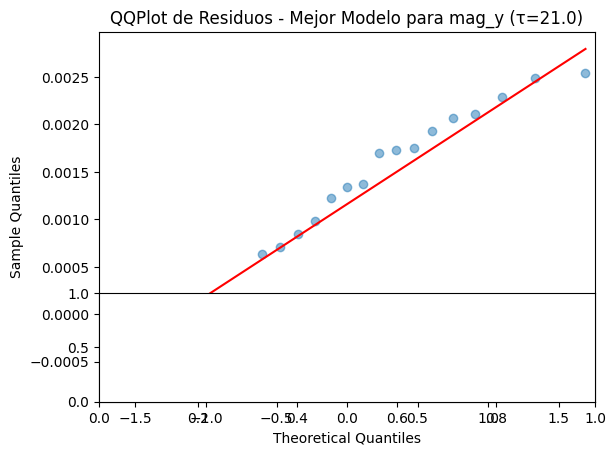

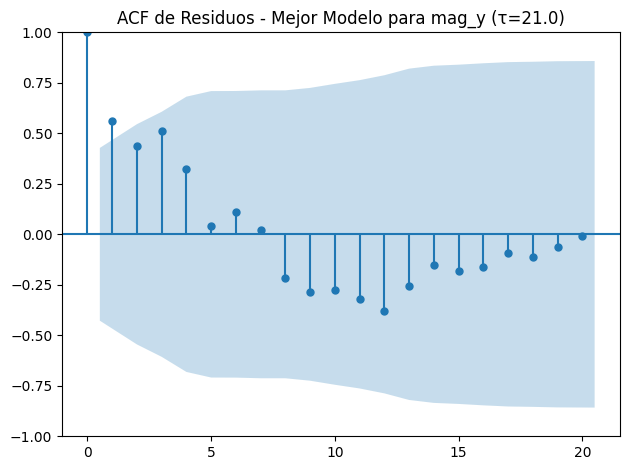


Generando gráfico de residuos para la variable: mag_z, τ=14.0, pliegue=1897


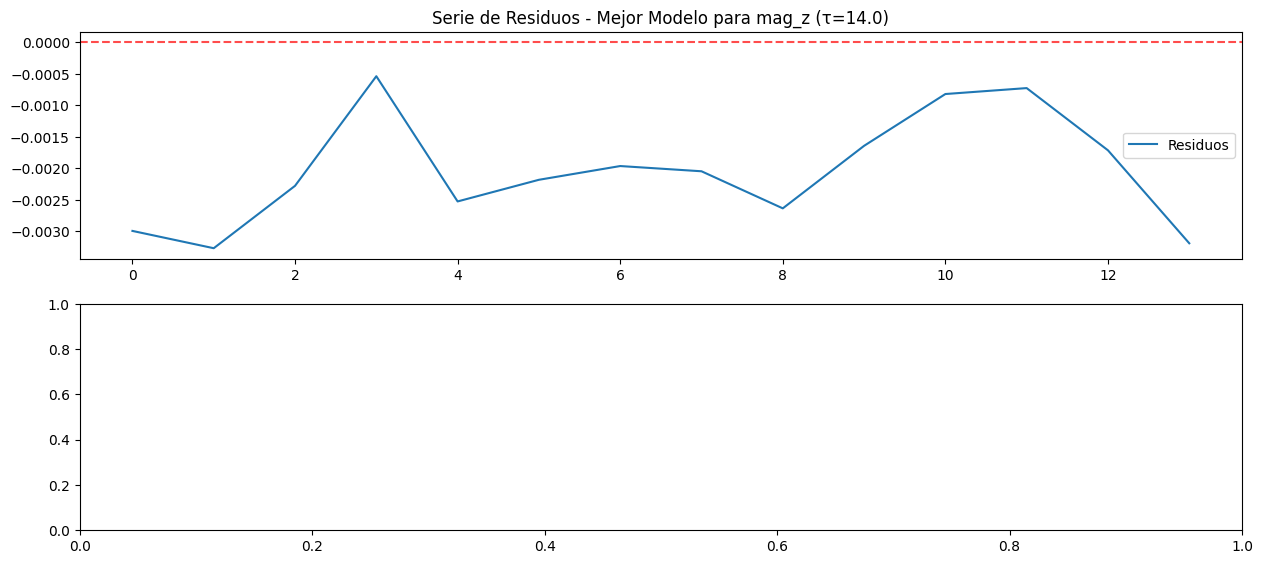

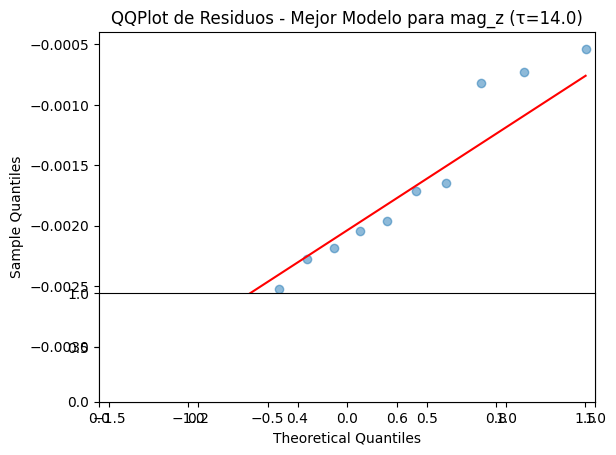

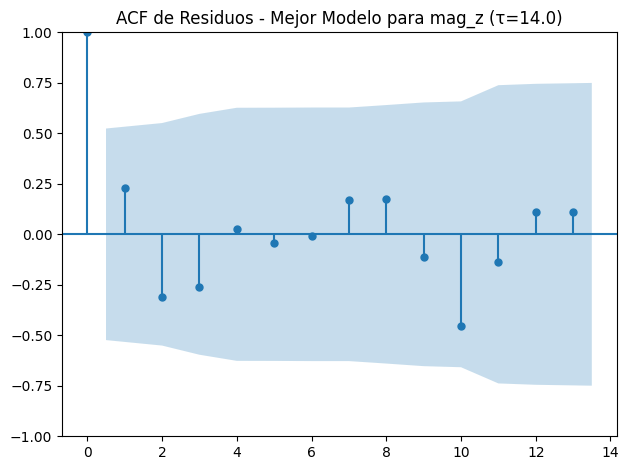

In [ ]:
for index, row in resultados_completos.iterrows():
    variable = row['variable']
    mejor_tau = row['Ventana']
    mejor_pliegue = int(row['pliegue'])  

    print(f"\nGenerando gráfico de residuos para la variable: {variable}, τ={mejor_tau}, pliegue={mejor_pliegue}")

    X_train_best = divisiones[mejor_tau]['X_train'][mejor_pliegue - 1]
    y_train_best = divisiones[mejor_tau]['y_train'][mejor_pliegue - 1]
    X_val_best = divisiones[mejor_tau]['X_val'][mejor_pliegue - 1]
    y_val_best = divisiones[mejor_tau]['y_val'][mejor_pliegue - 1]


    modelo_best = Ridge(alpha=1.0)  
    modelo_best.fit(X_train_best, y_train_best)
    y_pred_best = modelo_best.predict(X_val_best)
    residuos_best = y_val_best - y_pred_best
    residuos_best = np.array(residuos_best)

    # Generar el gráfico para los residuos
    graficar_diagnostico_residuos(
        residuos_best, 
        nombre_modelo=f"Mejor Modelo para {variable} (τ={mejor_tau})"
    )

Las gráficas de autocorrelación de residuos muestran que, en general, los residuos de las variables acc_x, acc_y, acc_z y gyr_x presentan independencia adecuada, con una rápida disminución de la autocorrelación dentro de las bandas de confianza. Sin embargo, en variables como mag_x, mag_y y gyr_z se observan autocorrelaciones significativas en ciertos lags. Sin embargo, para algunos modelos, la mayoría de los valores caen dentro de los intervalos de confianza, sugiriendo independencia residual adecuada.

Procesando errores para la variable: acc_x
Procesando errores para la variable: acc_y
Procesando errores para la variable: acc_z
Procesando errores para la variable: gyr_x
Procesando errores para la variable: gyr_y
Procesando errores para la variable: gyr_z
Procesando errores para la variable: mag_x
Procesando errores para la variable: mag_y
Procesando errores para la variable: mag_z


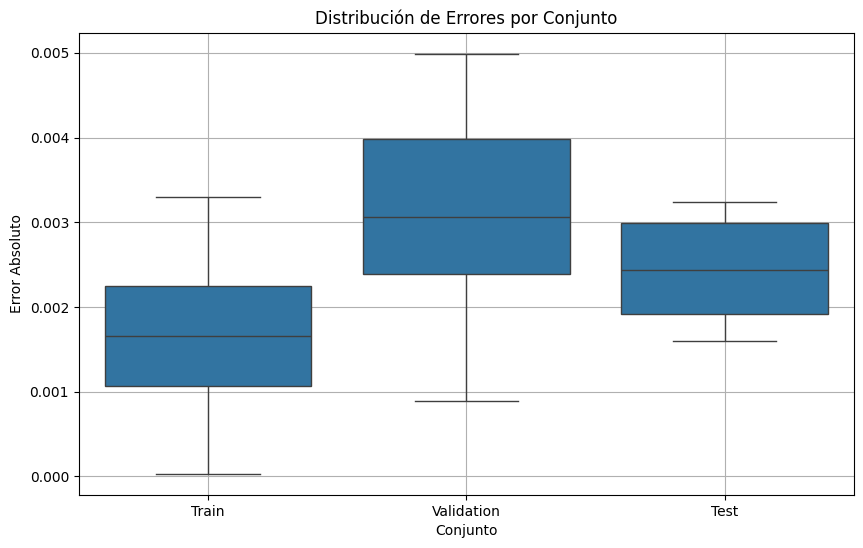

In [ ]:
errores_data = []
for variable in variables:
    print(f"Procesando errores para la variable: {variable}")
    y_train_pred = modelo_best.predict(X_train_best)
    y_val_pred = modelo_best.predict(X_val_best)
    y_test_pred = modelo_best.predict(X_test_best)
    errores_train = np.abs(y_train_best - y_train_pred)
    errores_val = np.abs(y_val_best - y_val_pred)
    errores_test = np.abs(y_test_best - y_test_pred)
    errores_data.extend([
        {'Set': 'Train', 'Error': error, 'Variable': variable} for error in errores_train
    ])
    errores_data.extend([
        {'Set': 'Validation', 'Error': error, 'Variable': variable} for error in errores_val
    ])
    errores_data.extend([
        {'Set': 'Test', 'Error': error, 'Variable': variable} for error in errores_test
    ])
df_errores = pd.DataFrame(errores_data)
plt.figure(figsize=(10, 6))
sns.boxplot(x='Set', y='Error', data=df_errores)
plt.title('Distribución de Errores por Conjunto')
plt.xlabel('Conjunto')
plt.ylabel('Error Absoluto')
plt.grid(True)
plt.show()


La distribución de los errores absolutos en los conjuntos de entrenamiento, validación y prueba muestra consistencia general. El conjunto de entrenamiento presenta errores más bajos y concentrados, lo cual es esperable dado que el modelo se ajusta directamente a estos datos. En el conjunto de validación, los errores son más dispersos y las medianas ligeramente más altas, reflejando la capacidad del modelo para generalizar a datos no utilizados en el entrenamiento. En el conjunto de prueba, los errores vuelven a ser más controlados, indicando una estabilidad del modelo, aunque podría haber espacio para reducir la dispersión y mejorar la generalización. 

## Regresion Lasso

In [ ]:
mejores_resultados_todasl = [] 
for ejercicio in ejercicios:
    for unidad in unidades:
        clave_entrenamiento = f'es{sujeto}e{ejercicio}u{unidad}'
        clave_prueba = f'ts{sujeto}e{ejercicio}u{unidad}'
   
        if clave_entrenamiento in datos_entrenamiento and clave_prueba in datos_prueba:
            divisiones = crear_pliegues(
                datos_entrenamiento[clave_entrenamiento],
                datos_prueba[clave_prueba],
                variables,
                tau_list
            )
            resultados = evaluar_modelo_lasso(divisiones, tau_list)
            mejor_resultado = obtener_mejores_resultados(resultados, criterio='R2')
            mejores_resultados_todasl.append(mejor_resultado)
        else:
            print(f"Claves no encontradas: {clave_entrenamiento} o {clave_prueba}")


In [ ]:
pd.DataFrame(mejores_resultados_todasl)

Ventana  pliegue           MSE      RMSE       MAPE        R2  \
976       7.0    977.0  3.355536e-05  0.005793   3.483244  0.848309   
446       7.0    447.0  5.067933e-05  0.007119   0.060094  0.930345   
4321     21.0    217.0  1.465578e-03  0.038283   1.963413  0.853109   
2273     14.0    211.0  1.390810e-04  0.011793  75.373955  0.757949   
1295      7.0   1296.0  1.692562e-06  0.001301  60.443322  0.904552   
0         7.0      1.0  3.375896e-06  0.001837  26.880551  0.763245   
7010     28.0    885.0  7.677107e-07  0.000876   0.143404  0.882899   
7014     28.0    889.0  8.180568e-07  0.000904   0.110830  0.867582   
4318     21.0    214.0  2.532963e-06  0.001592   1.032961  0.923545   

      Ljung-Box (p-value)  Jarque-Bera (p-value) variable  
976              0.559741               0.857415    acc_x  
446              0.633748               0.759278    acc_y  
4321             0.566631               0.492015    acc_z  
2273             0.316124               0.609366    gyr_x  
1295             0.303081               0.337948    gyr_y  
0                0.533019               0.693406    gyr_z  
7010             0.222093               0.950574    mag_x  
7014             0.102318               0.996736    mag_y  
4318             0.075543               0.643149    mag_z


Generando gráfico de residuos para la variable: acc_x, τ=7.0, pliegue=977


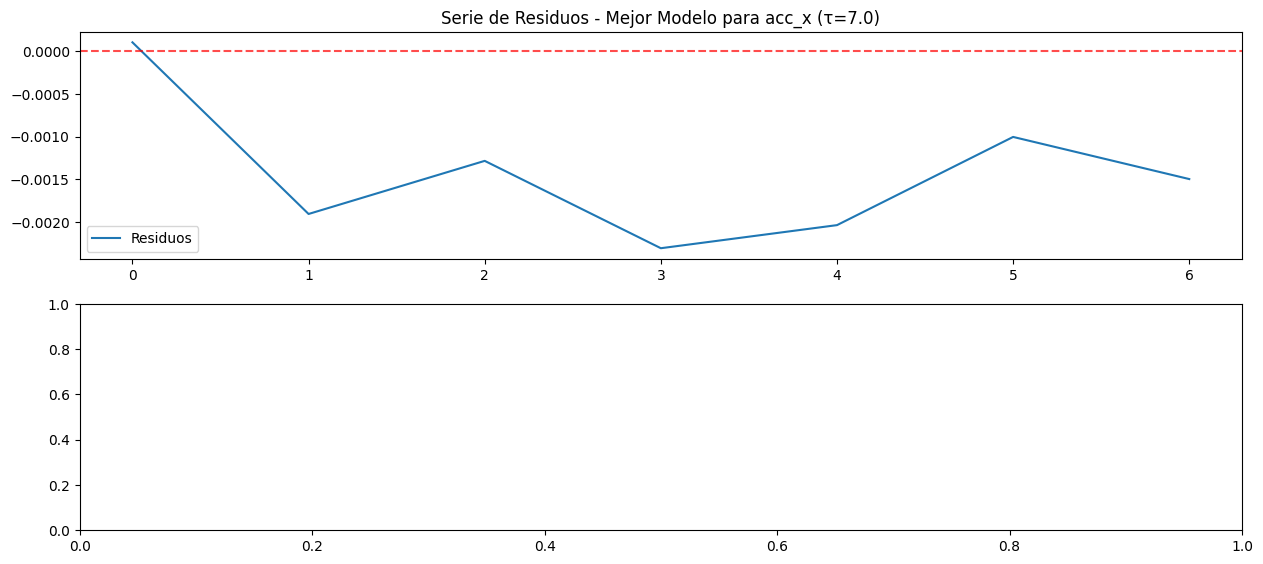

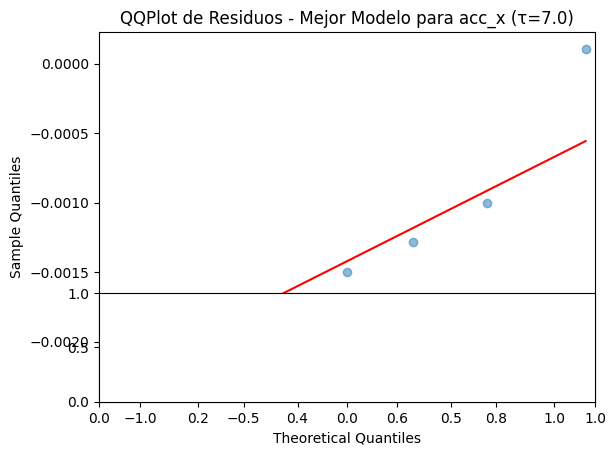

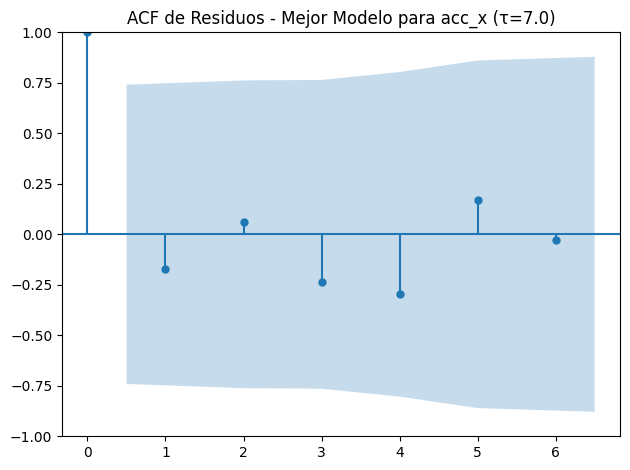


Generando gráfico de residuos para la variable: acc_y, τ=7.0, pliegue=447


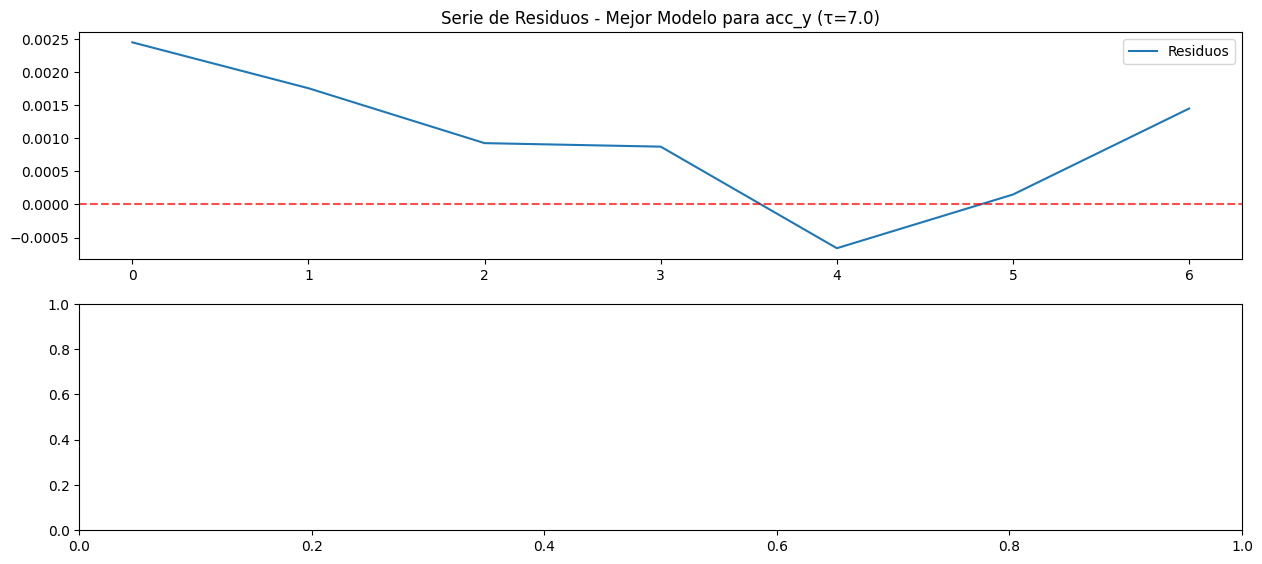

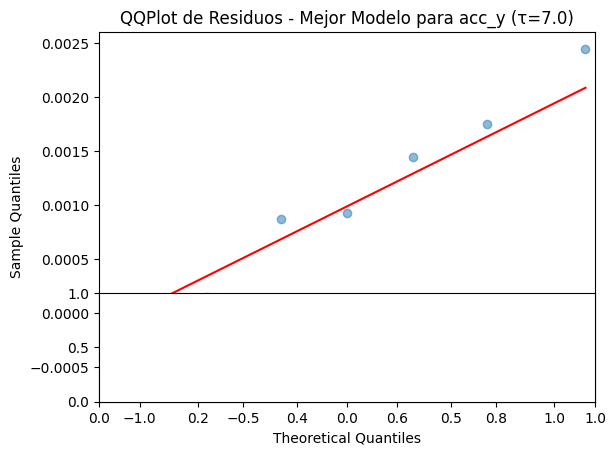

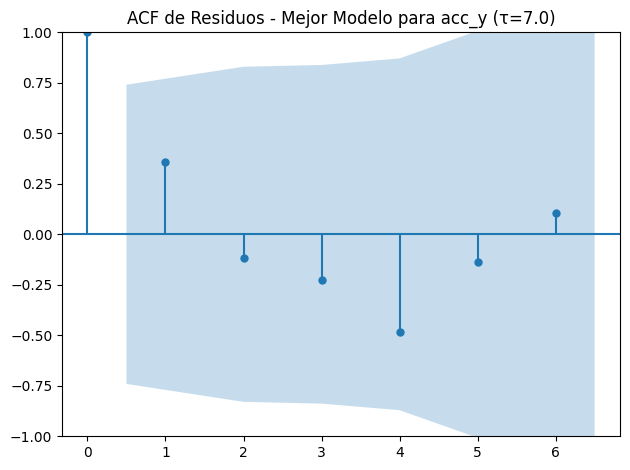


Generando gráfico de residuos para la variable: acc_z, τ=21.0, pliegue=217


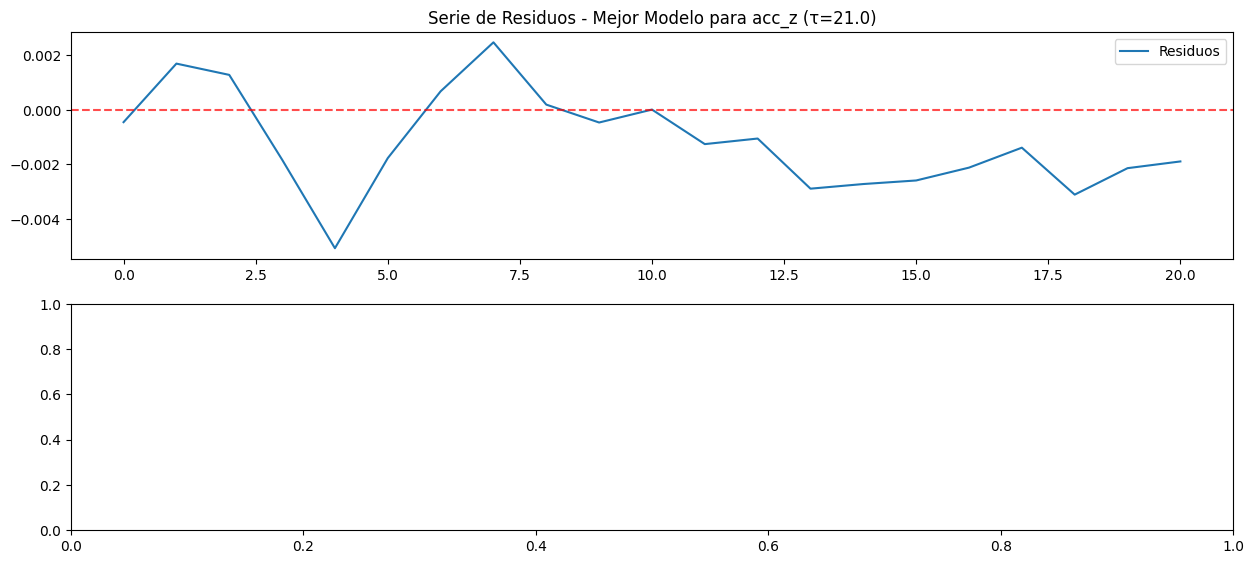

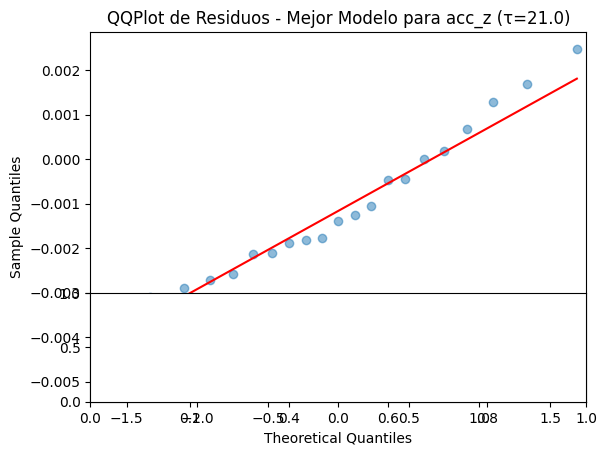

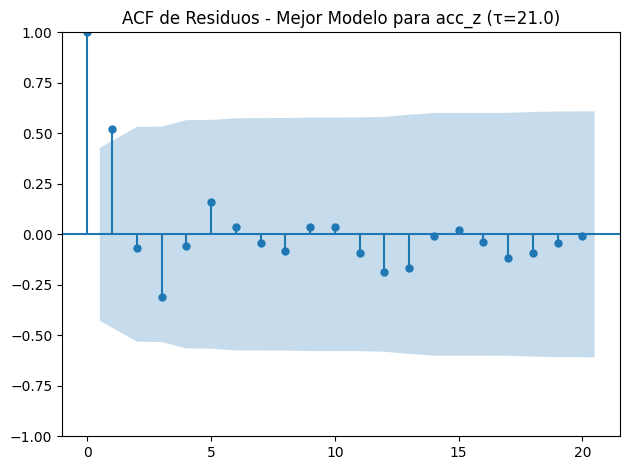


Generando gráfico de residuos para la variable: gyr_x, τ=14.0, pliegue=211


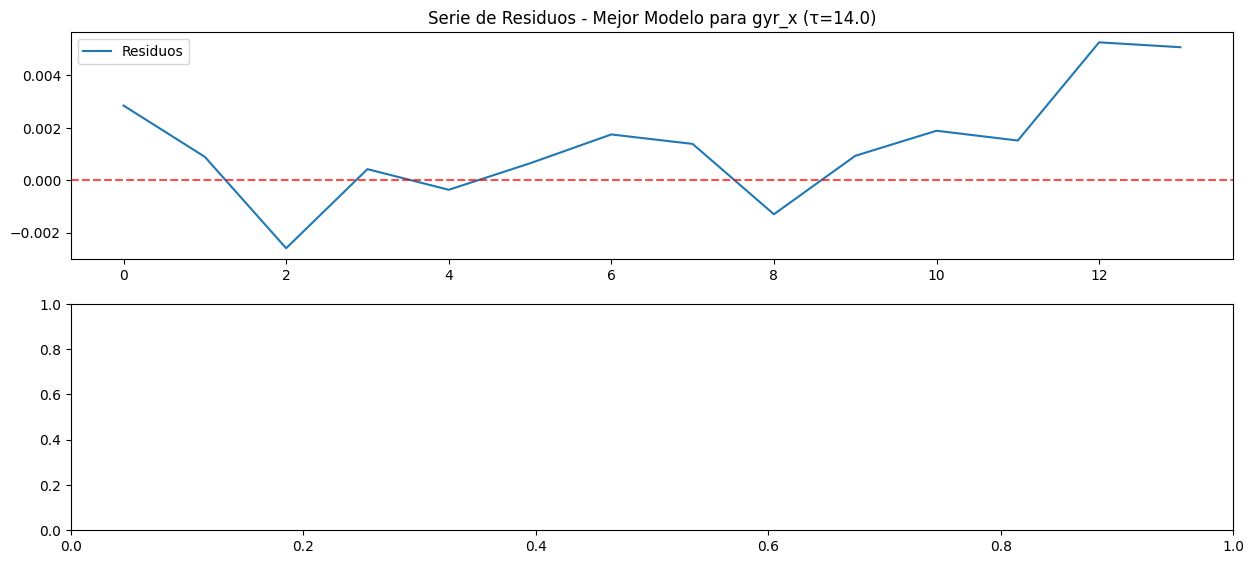

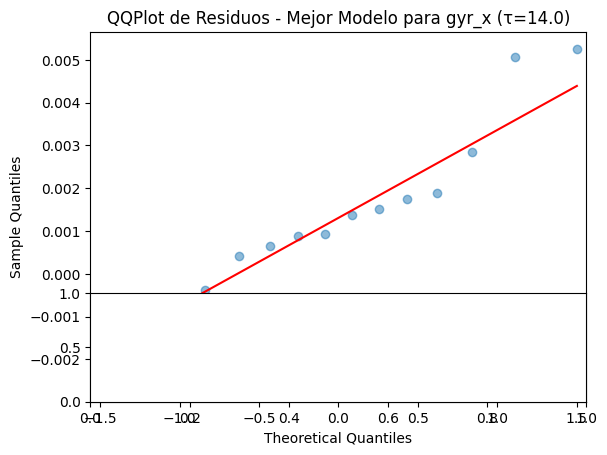

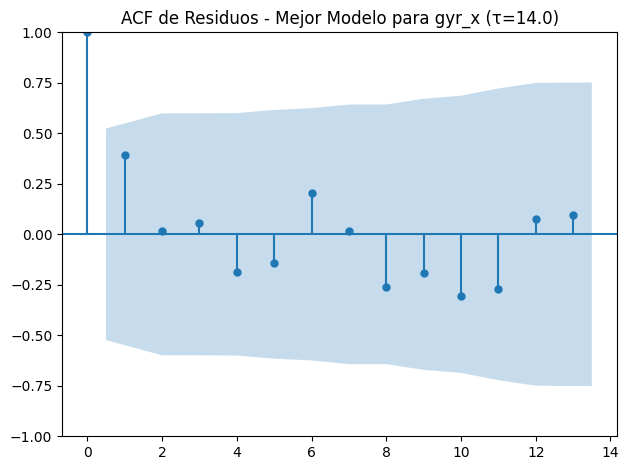


Generando gráfico de residuos para la variable: gyr_y, τ=7.0, pliegue=1296


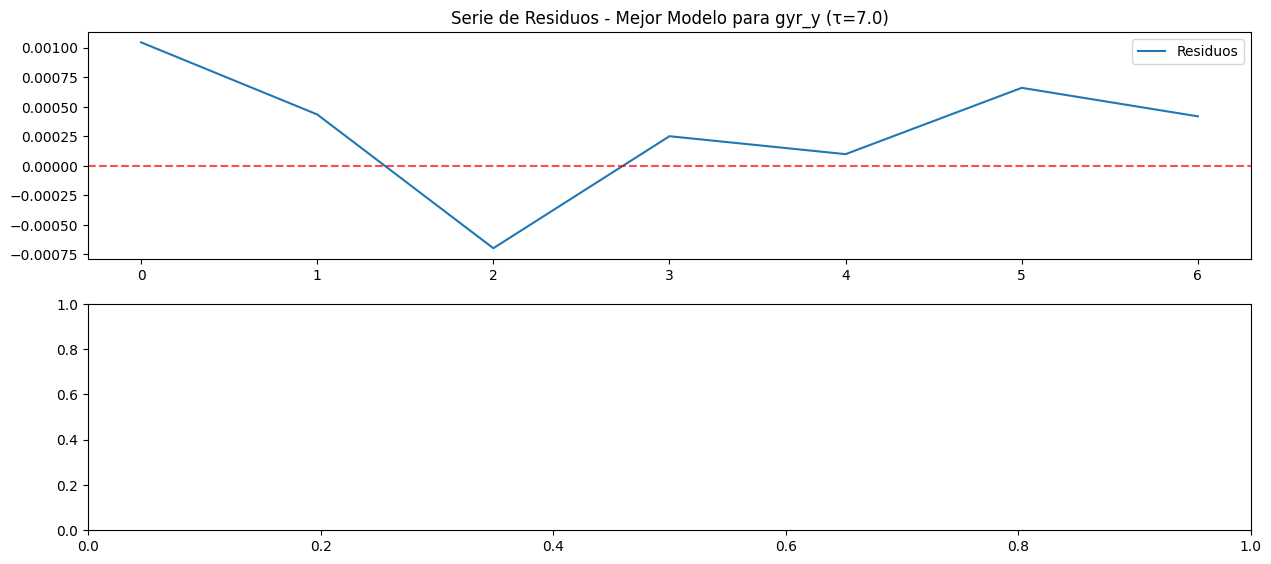

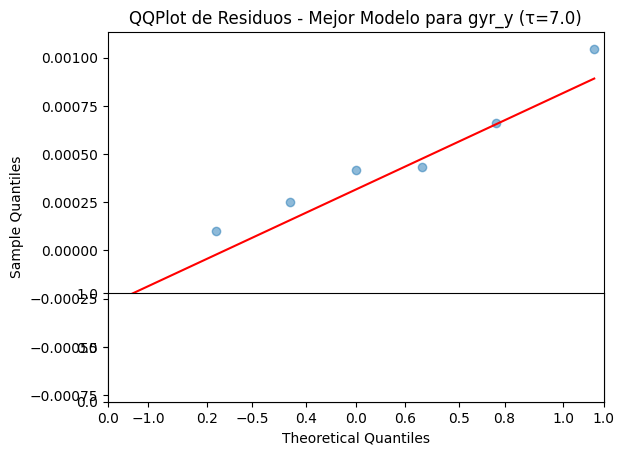

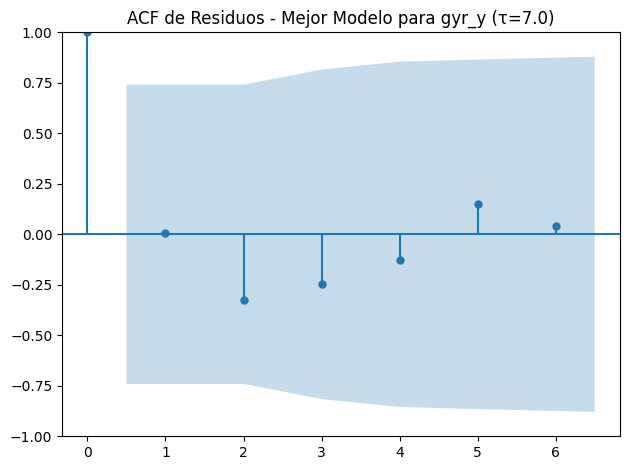


Generando gráfico de residuos para la variable: gyr_z, τ=7.0, pliegue=1


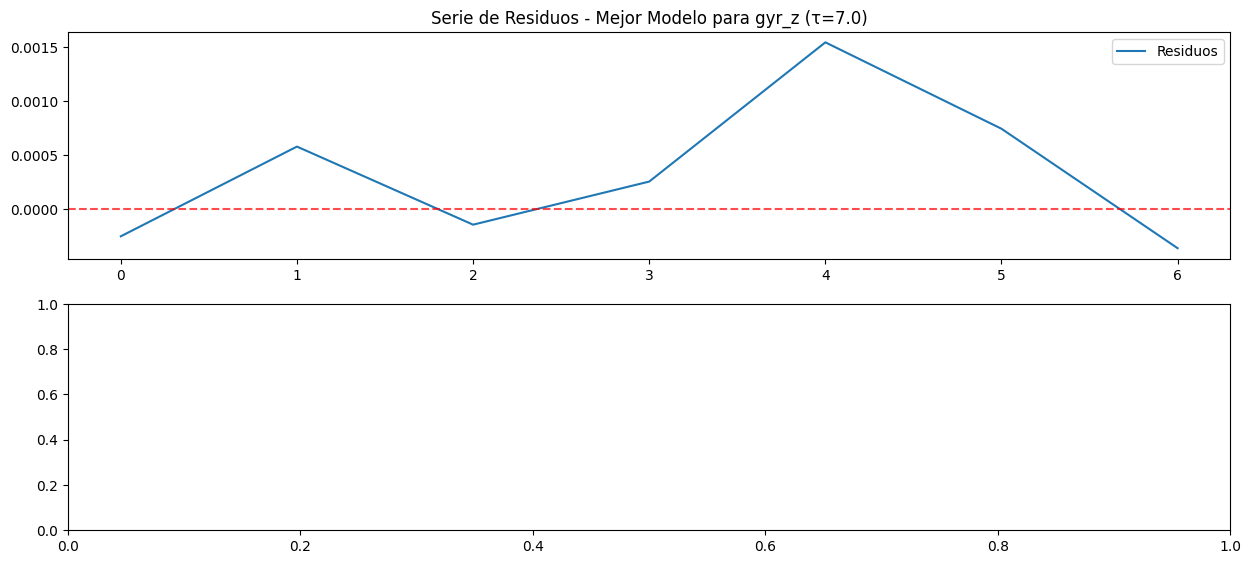

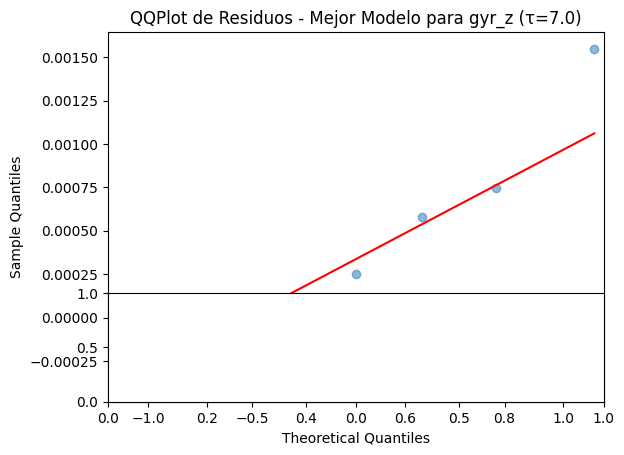

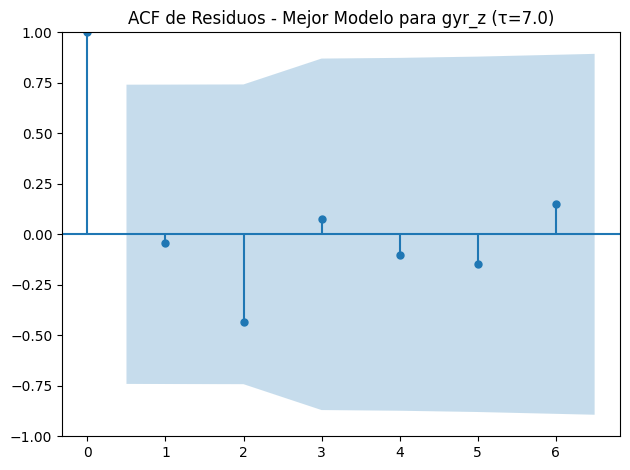


Generando gráfico de residuos para la variable: mag_x, τ=28.0, pliegue=885


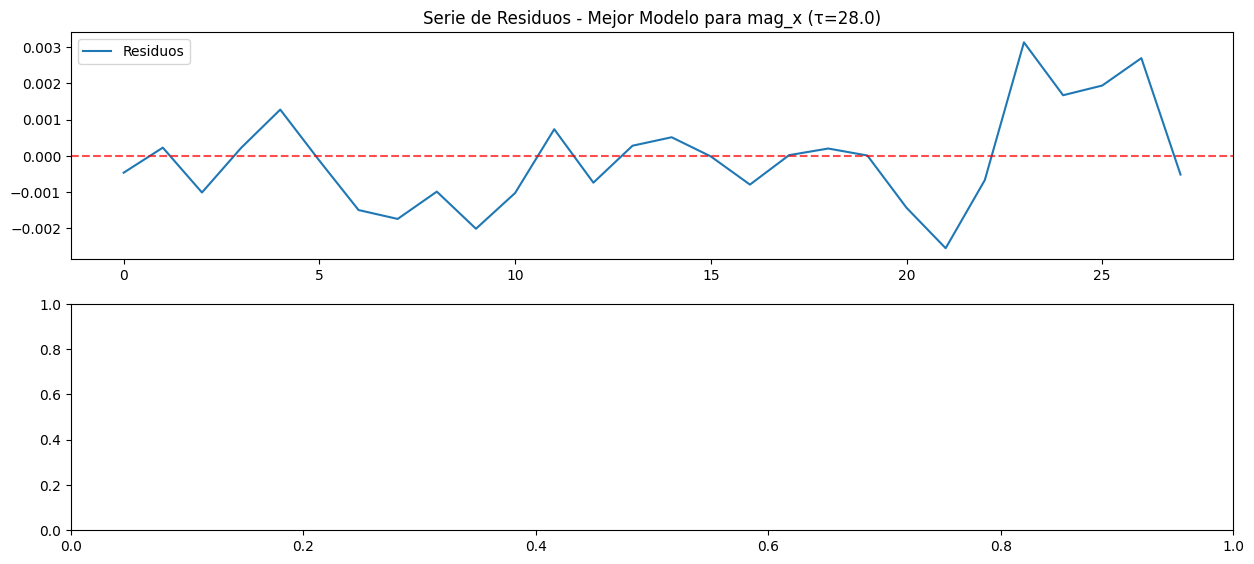

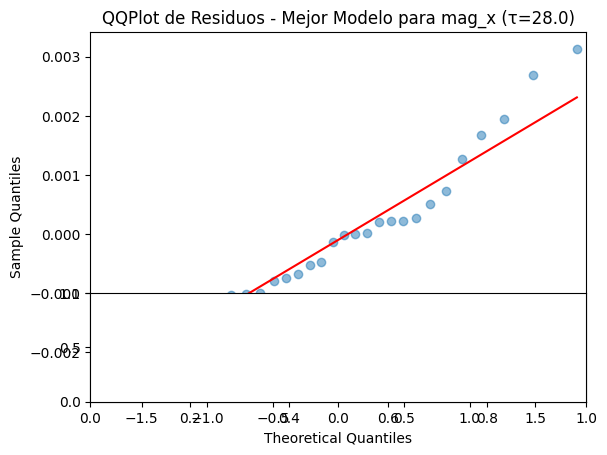

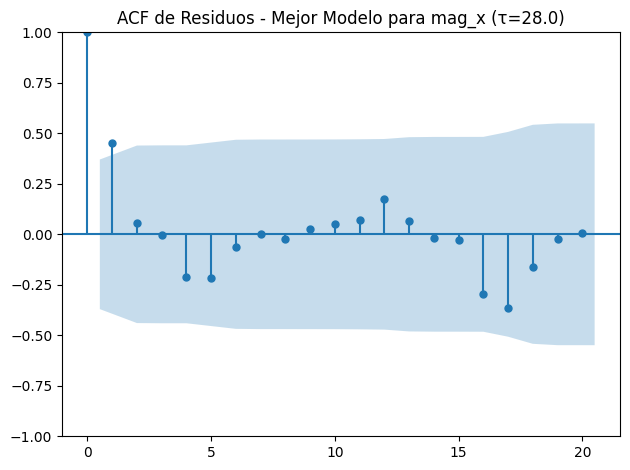


Generando gráfico de residuos para la variable: mag_y, τ=28.0, pliegue=889


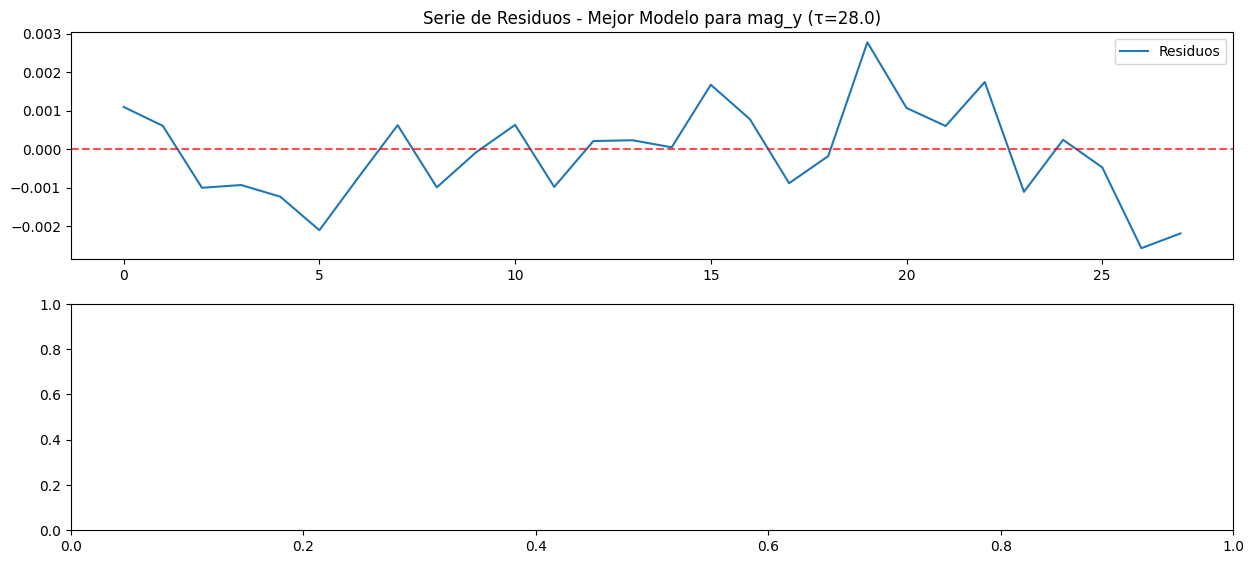

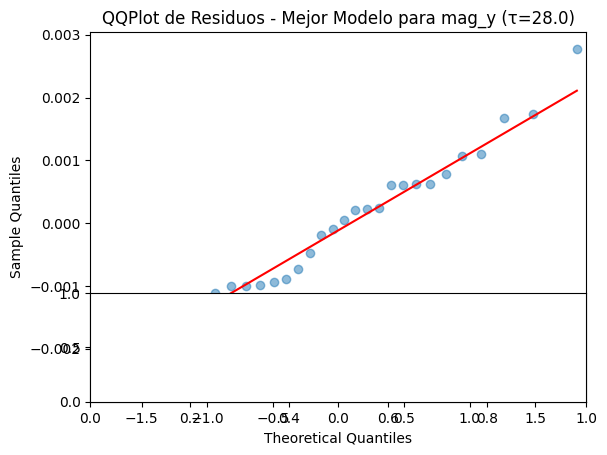

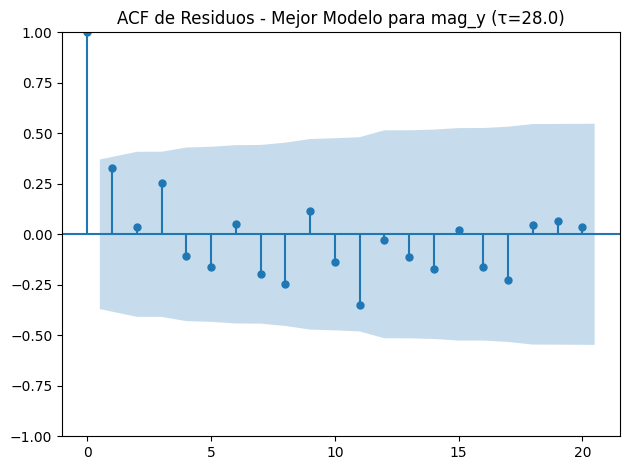


Generando gráfico de residuos para la variable: mag_z, τ=21.0, pliegue=214


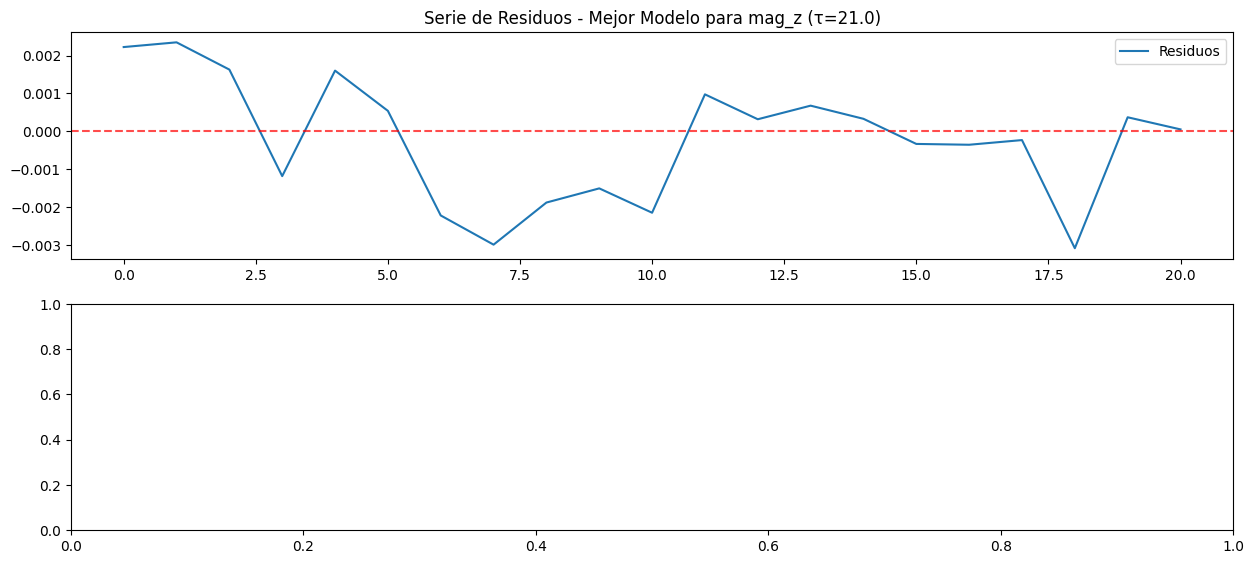

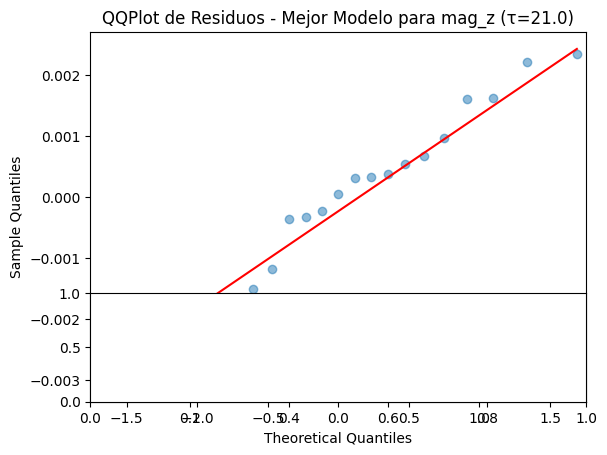

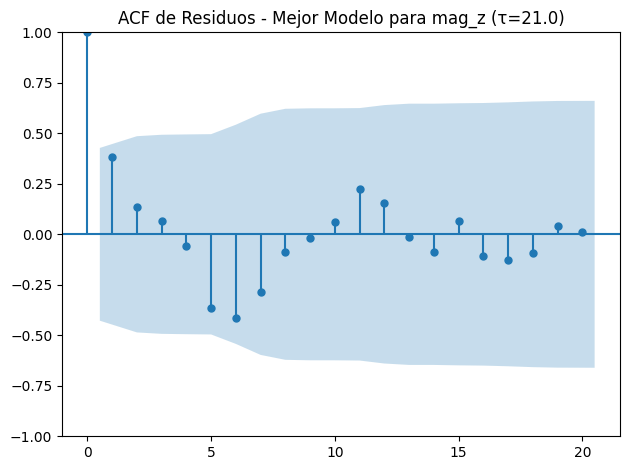

In [ ]:
for index, row in mejores_resultados_todasl.iterrows():
    variable = row['variable']
    mejor_tau = row['Ventana']  
    mejor_pliegue = int(row['pliegue']) 

    print(f"\nGenerando gráfico de residuos para la variable: {variable}, τ={mejor_tau}, pliegue={mejor_pliegue}")

    # Recuperar los datos correspondientes al mejor modelo
    X_train_best = divisiones[mejor_tau]['X_train'][mejor_pliegue - 1]
    y_train_best = divisiones[mejor_tau]['y_train'][mejor_pliegue - 1]
    X_val_best = divisiones[mejor_tau]['X_val'][mejor_pliegue - 1]
    y_val_best = divisiones[mejor_tau]['y_val'][mejor_pliegue - 1]
    X_test_best = divisiones[mejor_tau]['X_test'][mejor_pliegue - 1]
    y_test_best = divisiones[mejor_tau]['y_test'][mejor_pliegue - 1]
    
    modelo_best = Lasso(alpha=1e-3) 
    modelo_best.fit(X_train_best, y_train_best)

    y_pred_best = modelo_best.predict(X_val_best)
    residuos_best = y_val_best - y_pred_best
    residuos_best = np.array(residuos_best)

    graficar_diagnostico_residuos(
        residuos_best, 
        nombre_modelo=f"Mejor Modelo para {variable} (τ={mejor_tau})"
    )

Procesando errores para la variable: acc_x
Procesando errores para la variable: acc_y
Procesando errores para la variable: acc_z
Procesando errores para la variable: gyr_x
Procesando errores para la variable: gyr_y
Procesando errores para la variable: gyr_z
Procesando errores para la variable: mag_x
Procesando errores para la variable: mag_y
Procesando errores para la variable: mag_z


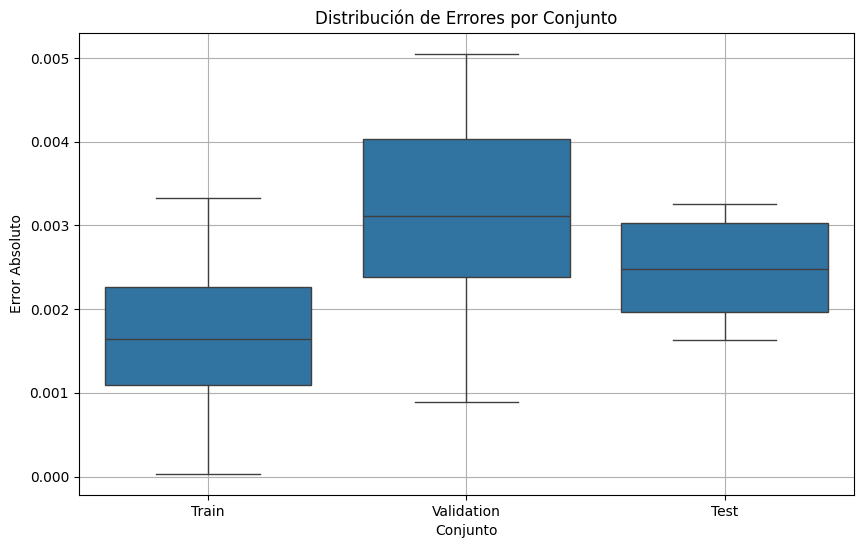

In [ ]:

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

errores_data = []

for variable in variables:
    print(f"Procesando errores para la variable: {variable}")
   
    y_train_pred = modelo_best.predict(X_train_best)
    y_val_pred = modelo_best.predict(X_val_best)
    y_test_pred = modelo_best.predict(X_test_best)
    errores_train = np.abs(y_train_best - y_train_pred)
    errores_val = np.abs(y_val_best - y_val_pred)
    errores_test = np.abs(y_test_best - y_test_pred)

    errores_data.extend([
        {'Set': 'Train', 'Error': error, 'Variable': variable} for error in errores_train
    ])
    errores_data.extend([
        {'Set': 'Validation', 'Error': error, 'Variable': variable} for error in errores_val
    ])
    errores_data.extend([
        {'Set': 'Test', 'Error': error, 'Variable': variable} for error in errores_test
    ])
df_errores = pd.DataFrame(errores_data)

# Graficar
plt.figure(figsize=(10, 6))
sns.boxplot(x='Set', y='Error', data=df_errores)
plt.title('Distribución de Errores por Conjunto')
plt.xlabel('Conjunto')
plt.ylabel('Error Absoluto')
plt.grid(True)
plt.show()

La distribución de errores en esta gráfica muestra un comportamiento relativamente consistente entre los conjuntos de entrenamiento, validación y prueba. En el conjunto de entrenamiento, los errores son bajos y están concentrados, indicando un buen ajuste del modelo a los datos utilizados para aprender. En el conjunto de validación, la mediana de los errores es ligeramente superior y presenta una mayor dispersión, lo que refleja los desafíos del modelo al generalizar a nuevos datos. En el conjunto de prueba, los errores se estabilizan con valores similares a los del conjunto de validación, lo cual sugiere que el modelo mantiene un rendimiento adecuado cuando se enfrenta a datos no vistos previamente. 

## Regresion Random Forest

In [ ]:
mejores_resultados_todasr = [] 
for ejercicio in ejercicios:
    for unidad in unidades:
        clave_entrenamiento = f'es{sujeto}e{ejercicio}u{unidad}'
        clave_prueba = f'ts{sujeto}e{ejercicio}u{unidad}'
   
        if clave_entrenamiento in datos_entrenamiento and clave_prueba in datos_prueba:
            divisiones = crear_pliegues(
                datos_entrenamiento[clave_entrenamiento],
                datos_prueba[clave_prueba],
                variables,
                tau_list
            )
            resultados = evaluar_modelo_random(divisiones, tau_list)
            mejor_resultado = obtener_mejores_resultados(resultados, criterio='R2')
            mejores_resultados_todasr.append(mejor_resultado)
        else:
            print(f"Claves no encontradas: {clave_entrenamiento} o {clave_prueba}")

In [ ]:
pd.DataFrame(mejores_resultados_todasr)


Ventana  pliegue           MSE      RMSE        MAPE        R2  \
1067      7.0   1068.0  2.681235e-05  0.005178    0.045861  0.857172   
1069      7.0   1070.0  1.099808e-04  0.010487    0.447239  0.850039   
1411      7.0   1412.0  1.014755e-04  0.010074    2.542835  0.910195   
490       7.0    491.0  2.706410e-05  0.005202   57.099402  0.756746   
788       7.0    789.0  4.012621e-06  0.002003  147.023988  0.738531   
449       7.0    450.0  2.646493e-06  0.001627   55.150237  0.844151   
252       7.0    253.0  3.666305e-08  0.000191    0.028514  0.860677   
1754      7.0   1755.0  7.104373e-08  0.000267    0.046962  0.787607   
1723      7.0   1724.0  1.406184e-07  0.000375    0.516125  0.696418   

      Ljung-Box (p-value)  Jarque-Bera (p-value) variable  
1067             0.299696               0.823697    acc_x  
1069             0.264913               0.602990    acc_y  
1411             0.012032               0.688411    acc_z  
490              0.362452               0.823565    gyr_x  
788              0.122850               0.803886    gyr_y  
449              0.113946               0.773975    gyr_z  
252              0.909096               0.645653    mag_x  
1754             0.723645               0.761369    mag_y  
1723             0.790008               0.764107    mag_z

Presentad buenos niveles de ajuste, especialmente en términos de los coeficientes \(R^2\), que indican una capacidad adecuada para explicar la variabilidad de los datos. En variables como acc_x (\(R^2 = 0.857\)), acc_y (\(R^2 = 0.850\)), y acc_z (\(R^2 = 0.910\)). Las métricas de error, como el MSE y RMSE, también permanecen en rangos bajos, lo que refuerza la precisión de las predicciones.

Por otro lado, los valores de las pruebas Ljung-Box y Jarque-Bera reflejan en su mayoría residuos bien distribuidos y no correlacionados. No obstante, ciertas variables, como acc_z (\(p = 0.012\) en Ljung-Box), pueden requerir una revisión más detallada para garantizar la independencia de los residuos.

### Residuos


Generando gráfico de residuos para la variable: acc_x, τ=7.0, pliegue=1068


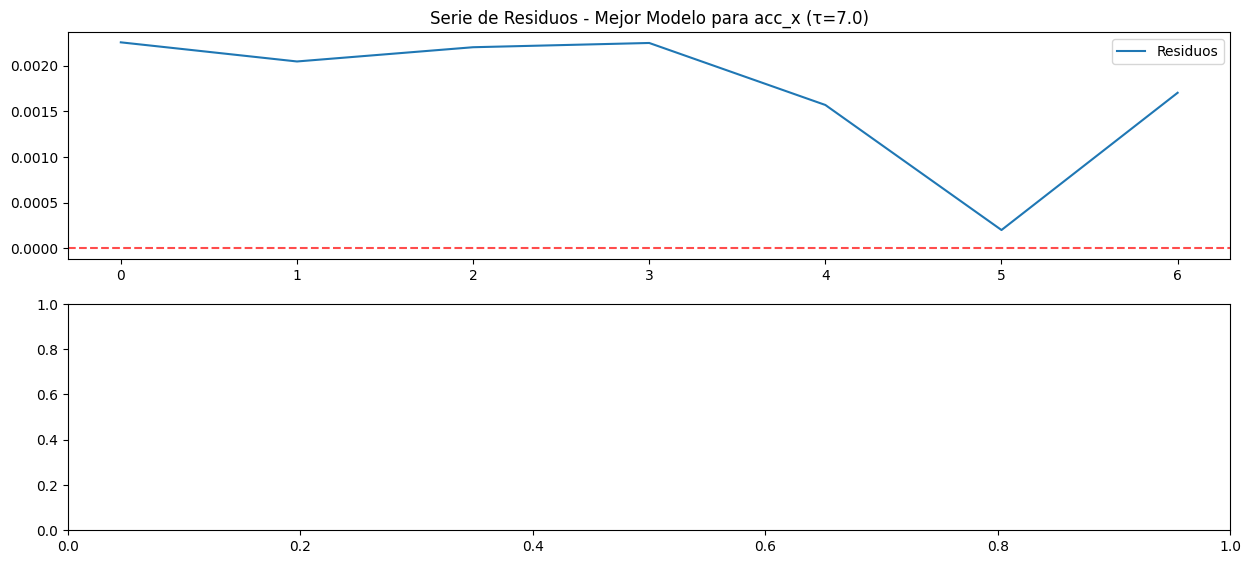

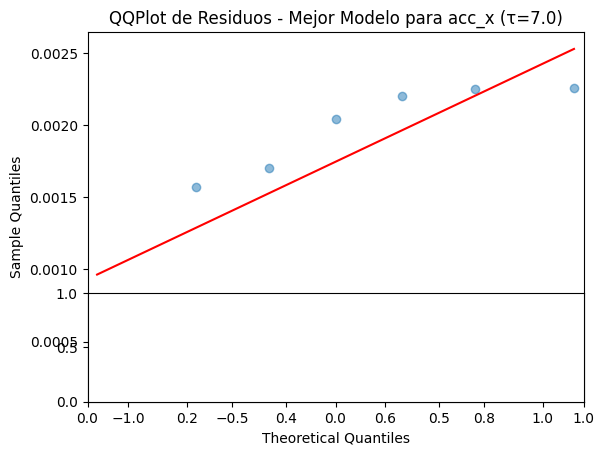

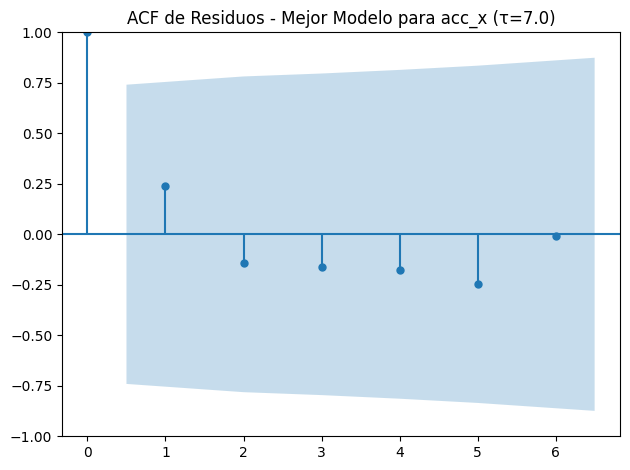


Generando gráfico de residuos para la variable: acc_y, τ=7.0, pliegue=1070


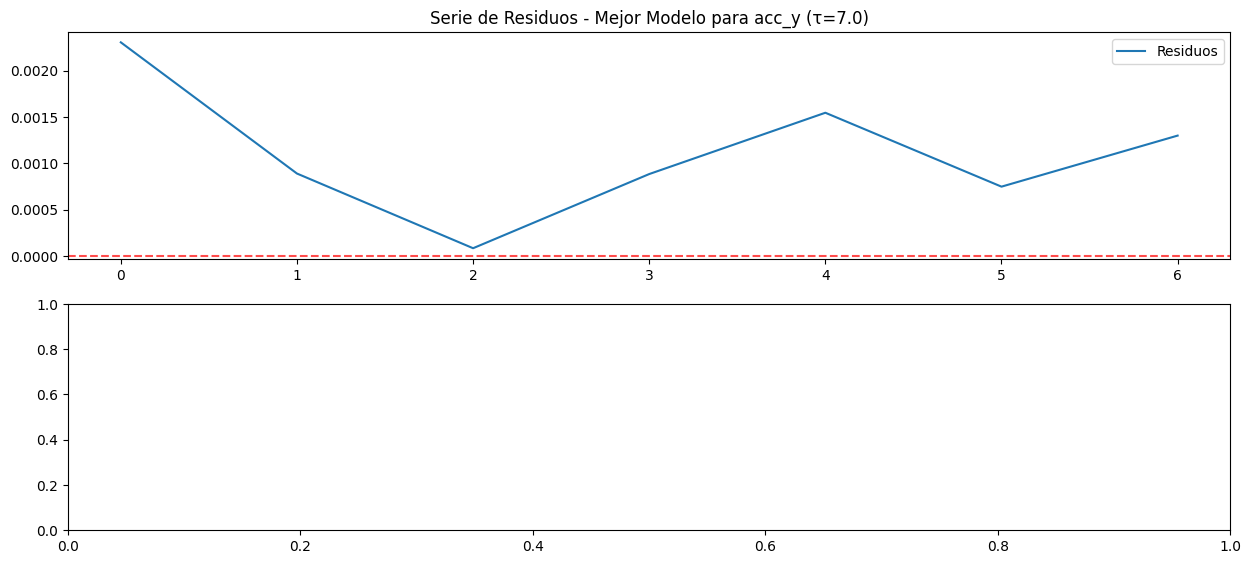

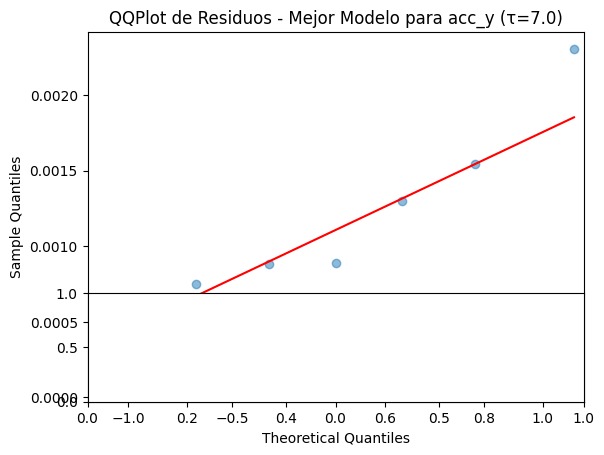

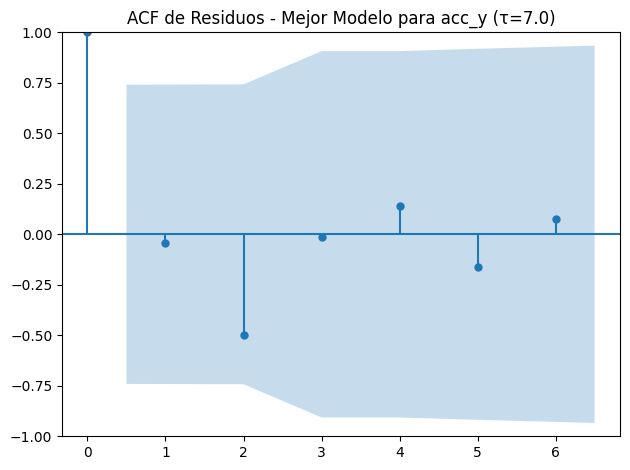


Generando gráfico de residuos para la variable: acc_z, τ=7.0, pliegue=1412


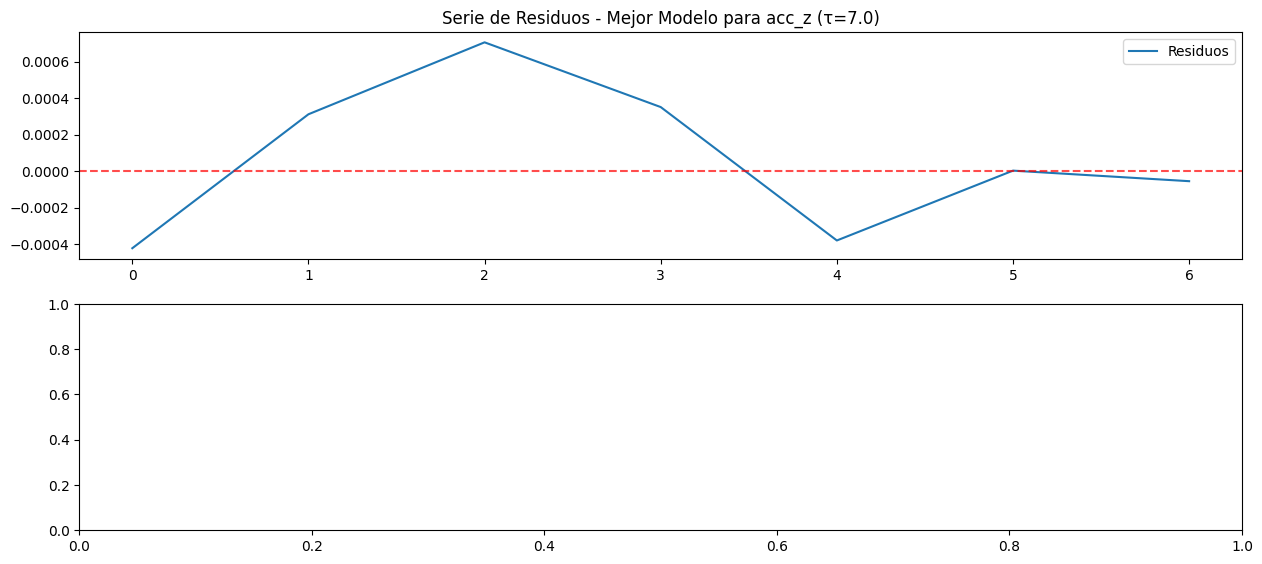

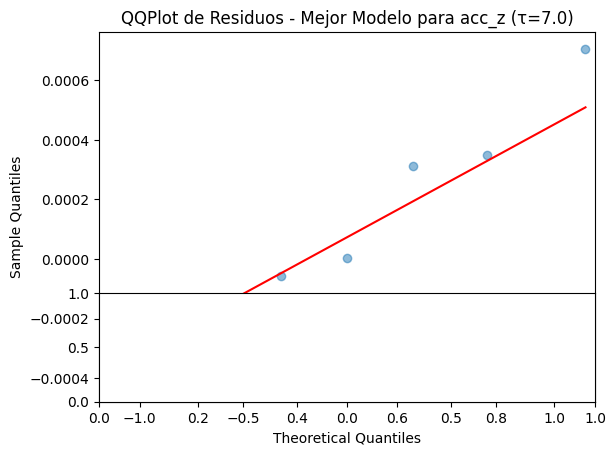

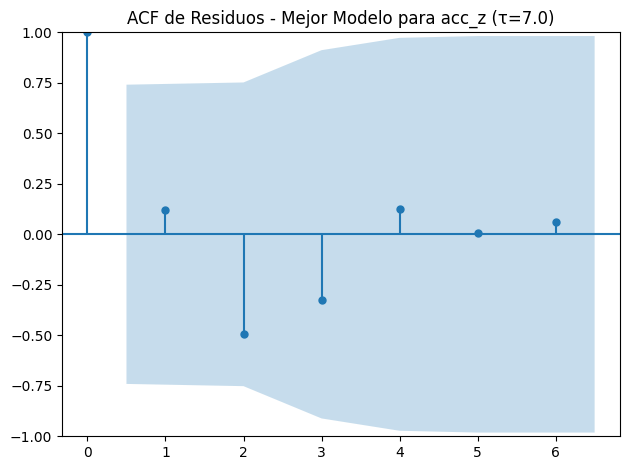


Generando gráfico de residuos para la variable: gyr_x, τ=7.0, pliegue=491


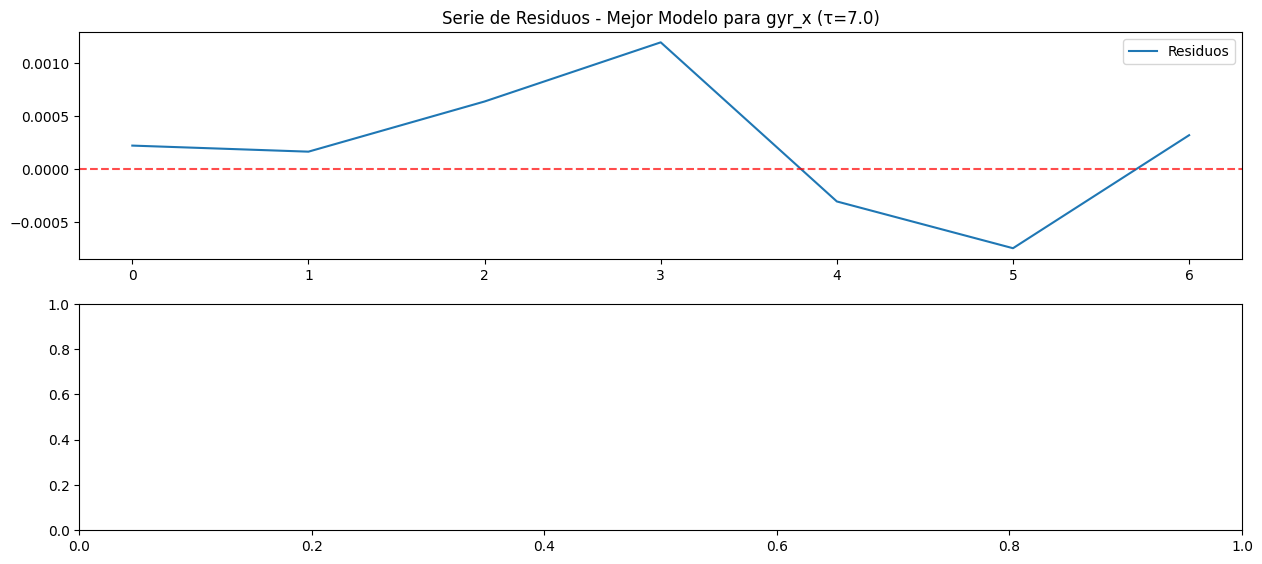

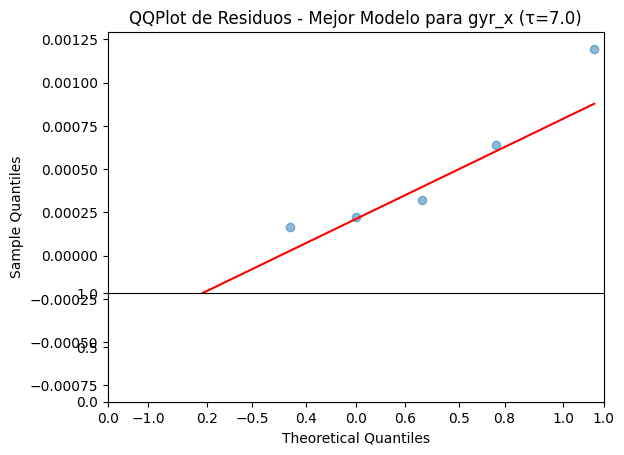

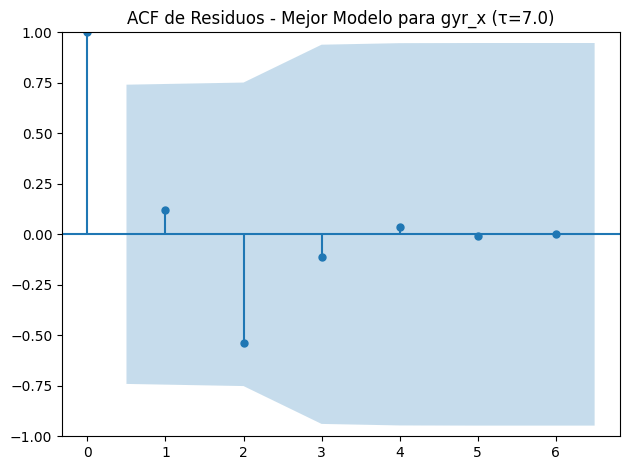


Generando gráfico de residuos para la variable: gyr_y, τ=7.0, pliegue=789


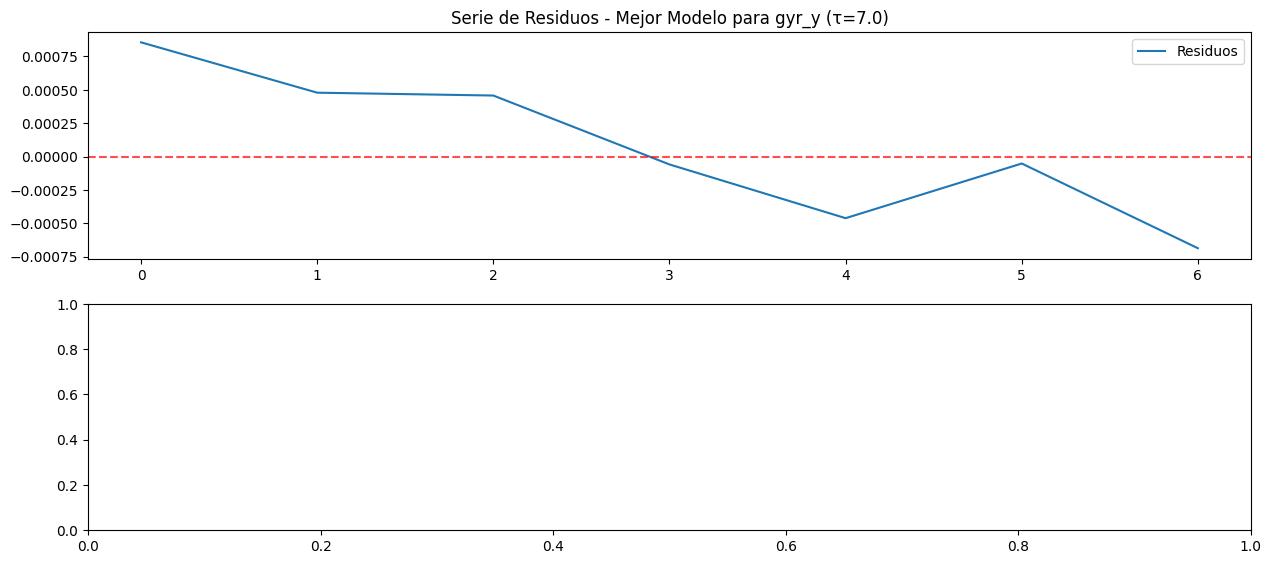

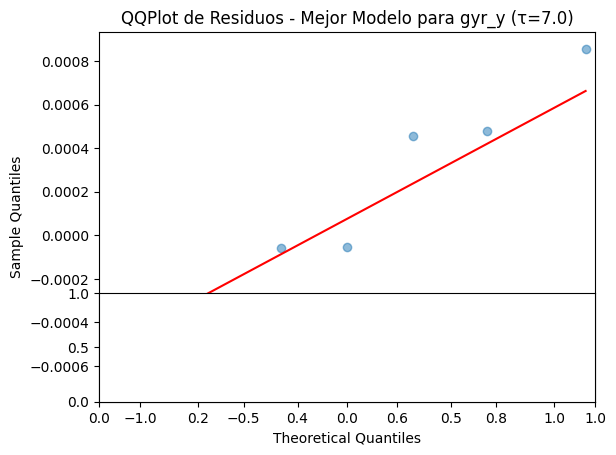

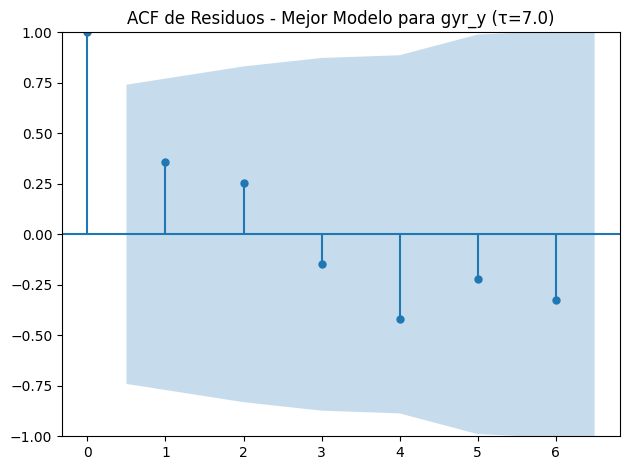


Generando gráfico de residuos para la variable: gyr_z, τ=7.0, pliegue=450


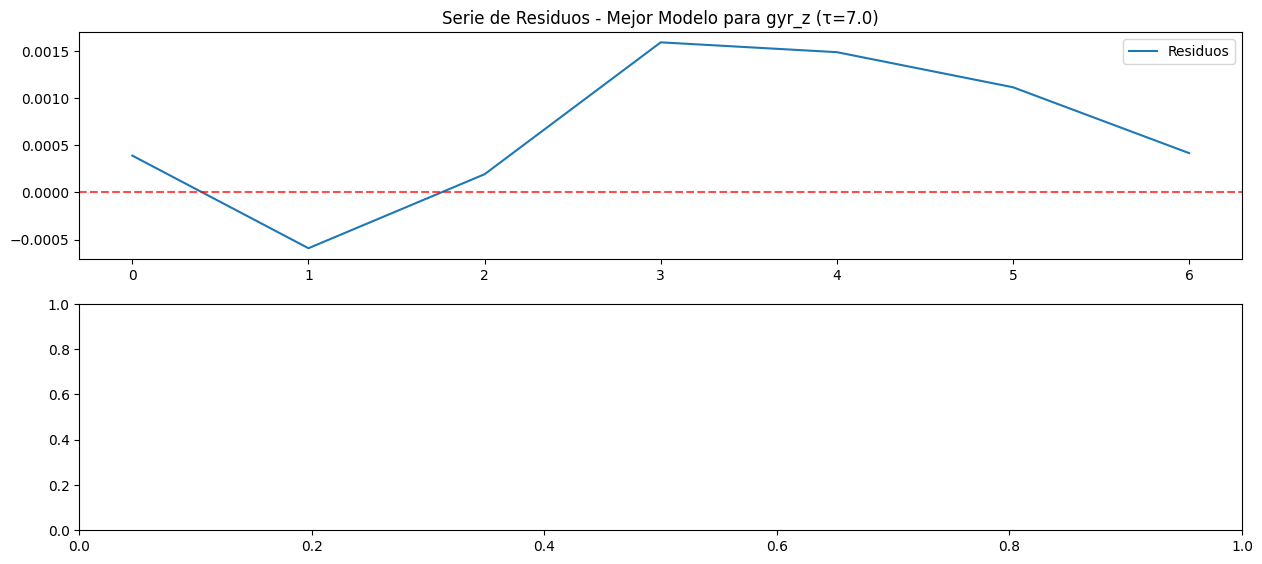

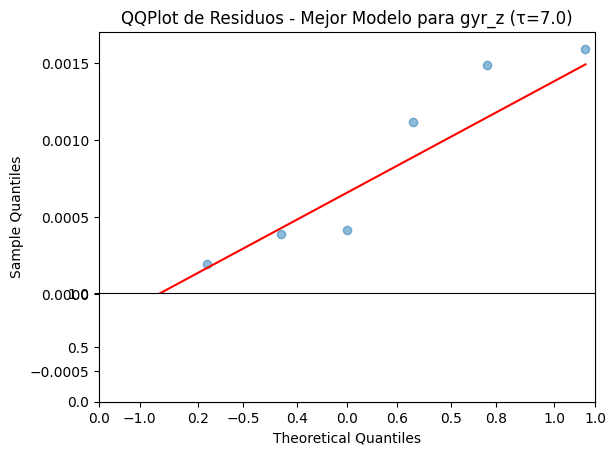

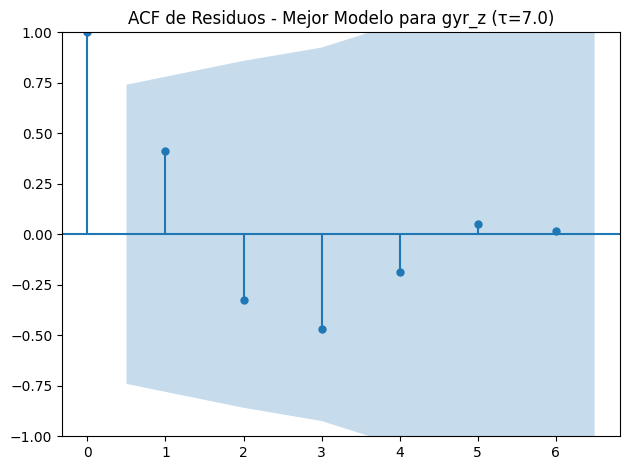


Generando gráfico de residuos para la variable: mag_x, τ=7.0, pliegue=253


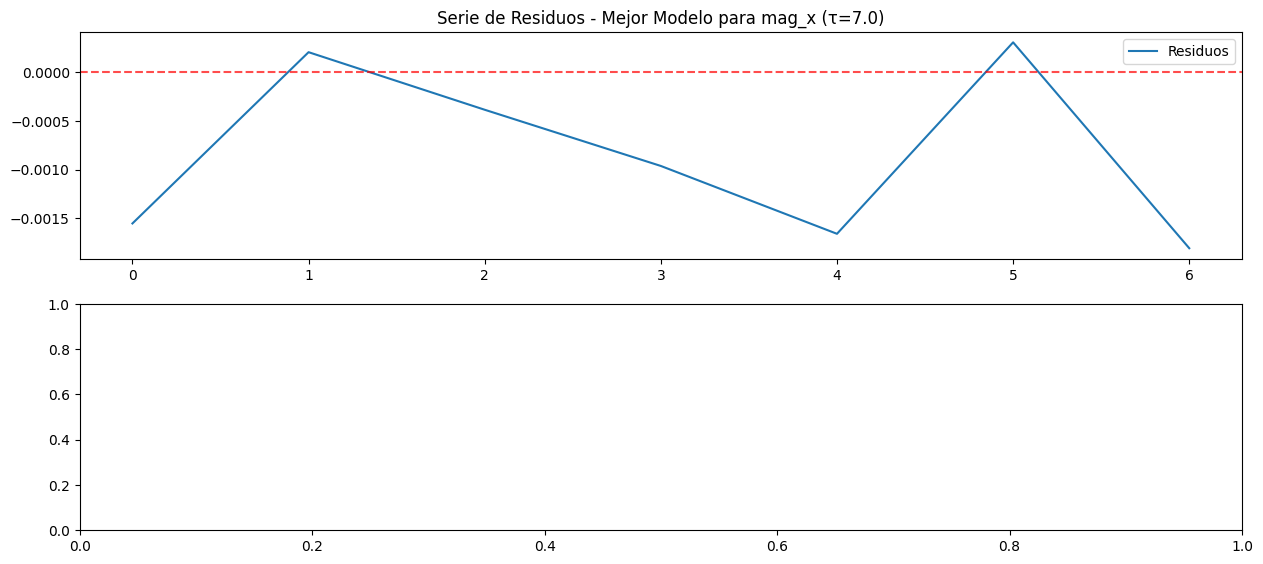

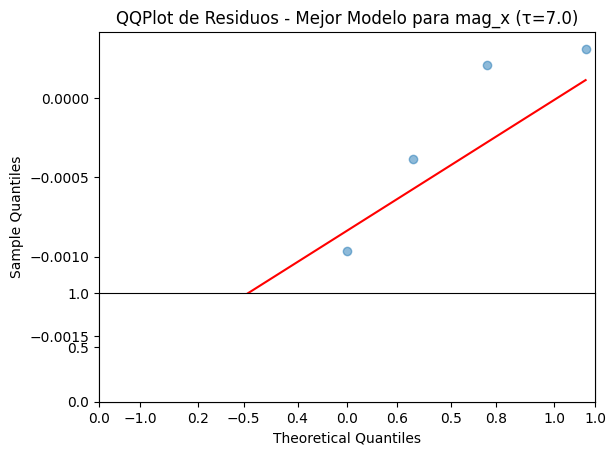

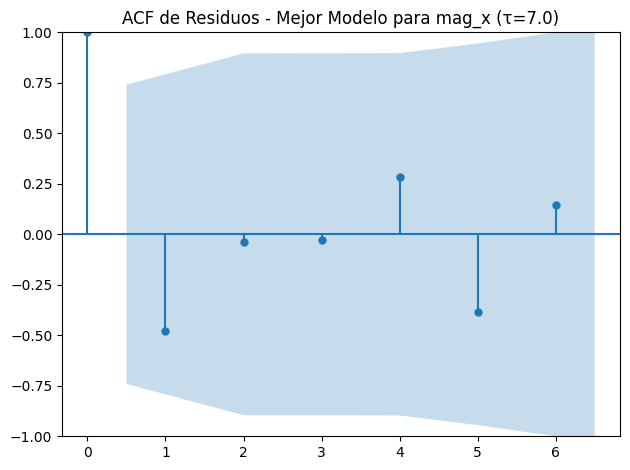


Generando gráfico de residuos para la variable: mag_y, τ=7.0, pliegue=1755


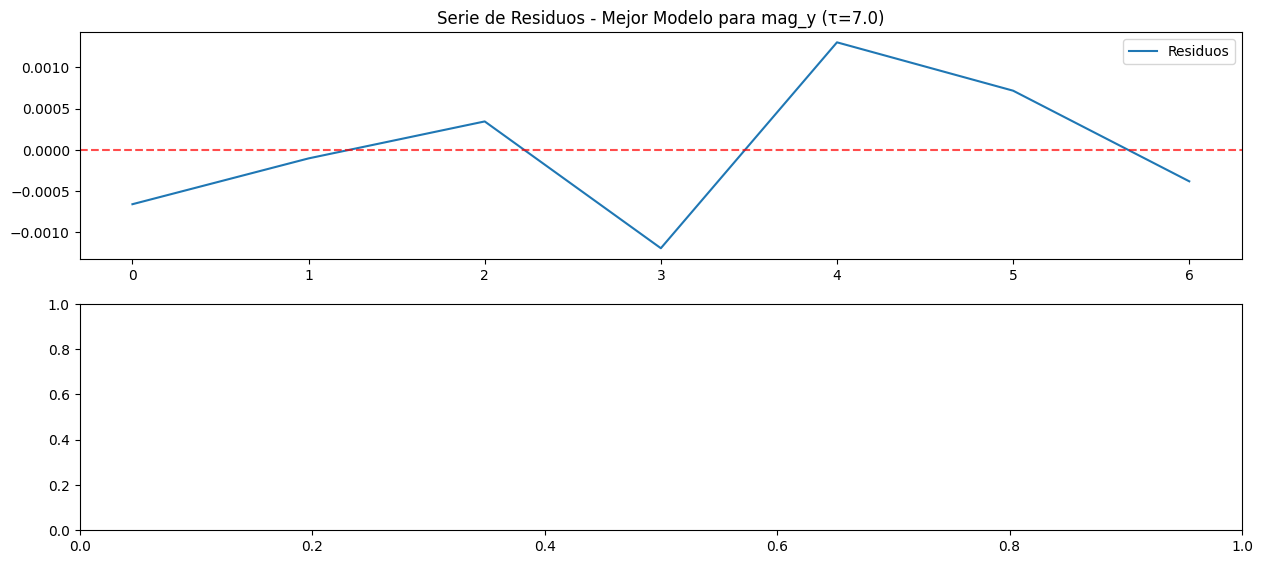

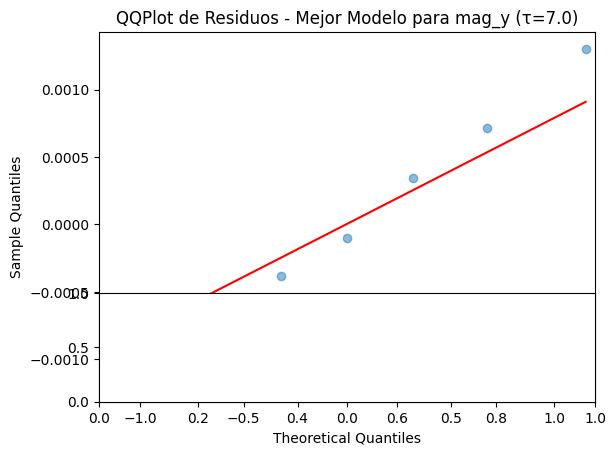

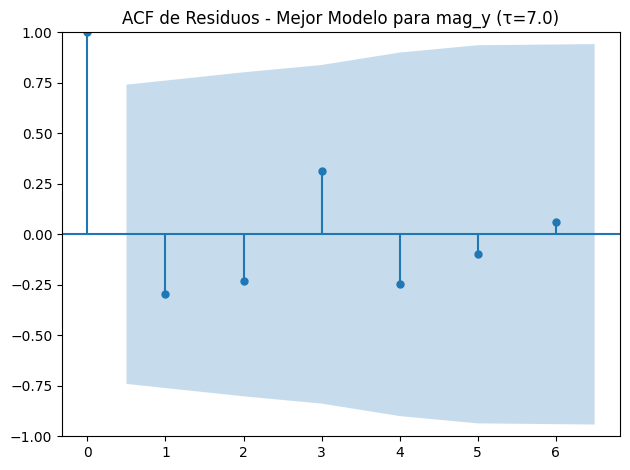


Generando gráfico de residuos para la variable: mag_z, τ=7.0, pliegue=1724


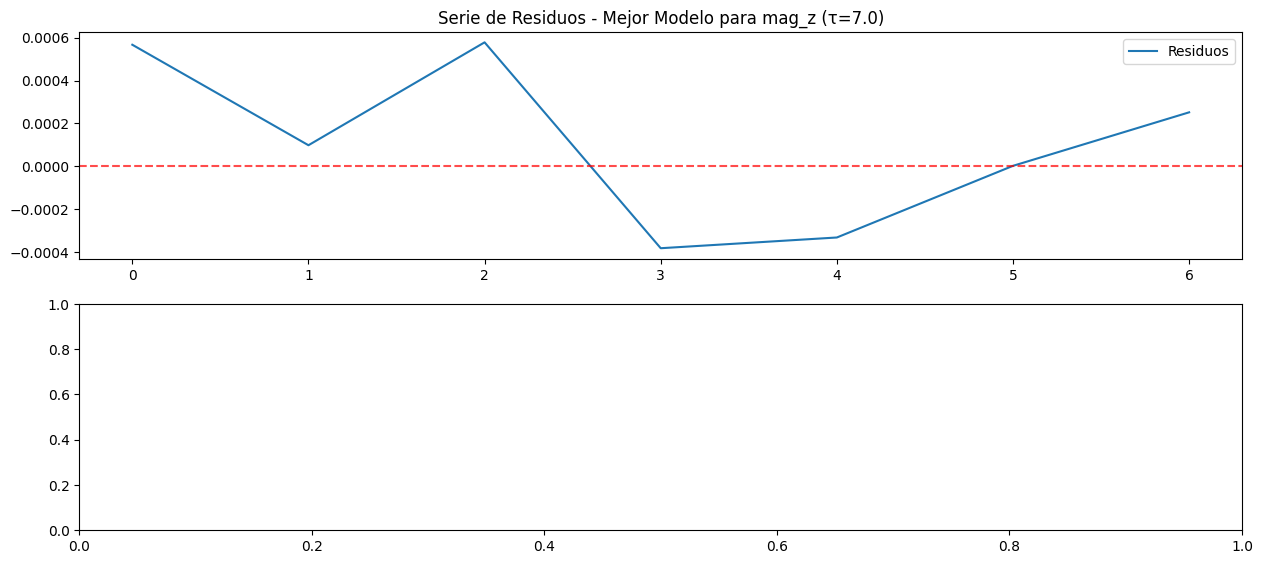

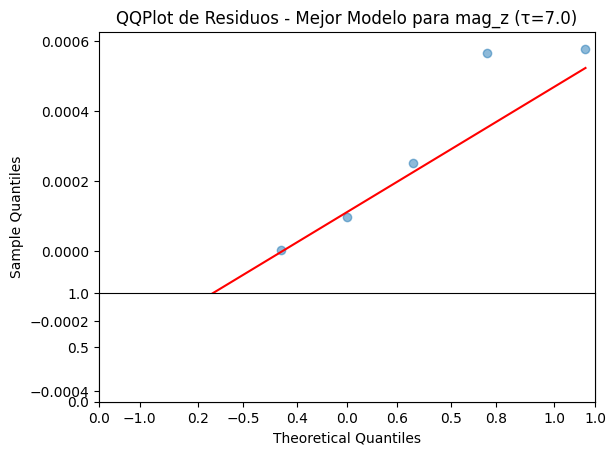

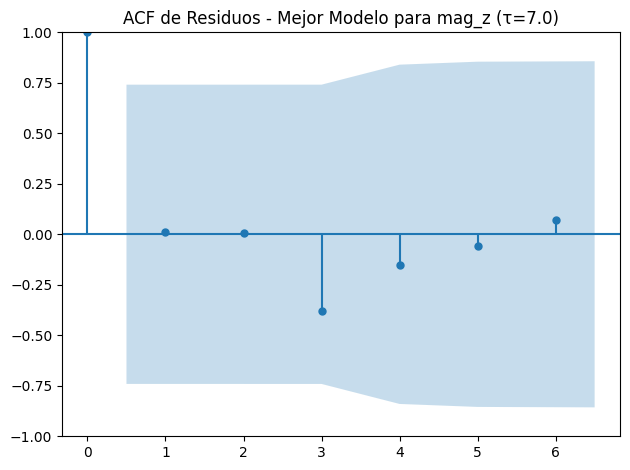

In [ ]:

for index, row in mejores_resultados_todasr.iterrows():
    variable = row['variable']
    mejor_tau = row['Ventana']  
    mejor_pliegue = int(row['pliegue']) 

    print(f"\nGenerando gráfico de residuos para la variable: {variable}, τ={mejor_tau}, pliegue={mejor_pliegue}")
    X_train_best = divisiones[mejor_tau]['X_train'][mejor_pliegue - 1]
    y_train_best = divisiones[mejor_tau]['y_train'][mejor_pliegue - 1]
    X_val_best = divisiones[mejor_tau]['X_val'][mejor_pliegue - 1]
    y_val_best = divisiones[mejor_tau]['y_val'][mejor_pliegue - 1]
    X_test_best = divisiones[mejor_tau]['X_test'][mejor_pliegue - 1]
    y_test_best = divisiones[mejor_tau]['y_test'][mejor_pliegue - 1]

    modelo_best = RandomForestRegressor(n_estimators=100, random_state=42) 
    modelo_best.fit(X_train_best, y_train_best)

    y_pred_best = modelo_best.predict(X_val_best)
    residuos_best = y_val_best - y_pred_best
    residuos_best = residuos_best[~np.isnan(residuos_best)]  
    residuos_best = residuos_best[~np.isinf(residuos_best)]  
    residuos_best = np.array(residuos_best)

    # Generar el gráfico 
    graficar_diagnostico_residuos(
        residuos_best, 
        nombre_modelo=f"Mejor Modelo para {variable} (τ={mejor_tau})"
    )

 Los gráficos de las series de residuos muestran que, en general, los residuos se distribuyen alrededor de cero, lo que indica un buen ajuste de los modelos para las diferentes variables, como acc_x, acc_y, gyr_x, mag_x, entre otras. En algunos casos, como acc_y y gyr_y, los residuos presentan ligeras fluctuaciones, pero permanecen dentro de un rango aceptable, lo que no compromete la estabilidad del modelo. Los gráficos QQ-plot, por su parte, muestran que los residuos siguen de cerca la línea teórica, confirmando que la distribución de los mismos se aproxima a una normalidad, aunque con pequeñas desviaciones en los extremos superiores en ciertas variables.

Procesando errores para la variable: acc_x
Procesando errores para la variable: acc_y
Procesando errores para la variable: acc_z
Procesando errores para la variable: gyr_x
Procesando errores para la variable: gyr_y
Procesando errores para la variable: gyr_z
Procesando errores para la variable: mag_x
Procesando errores para la variable: mag_y
Procesando errores para la variable: mag_z


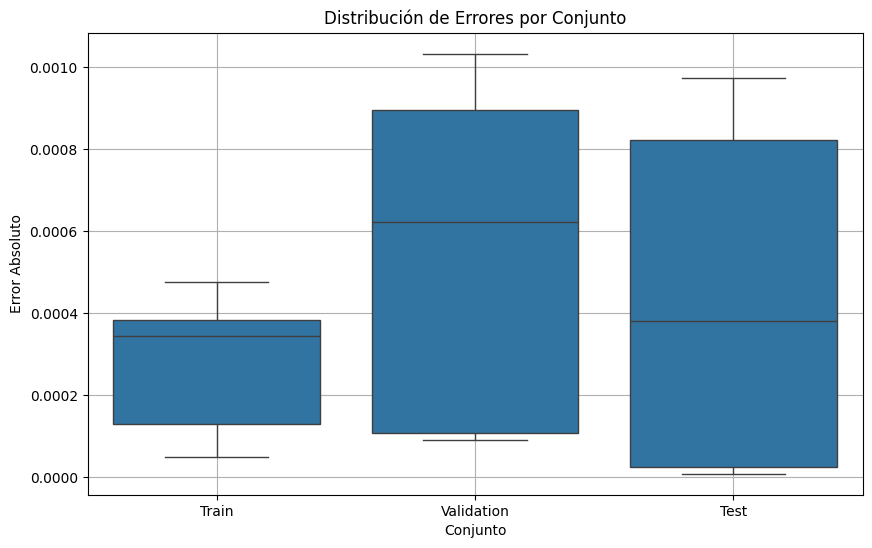

In [ ]:
errores_data = []

for variable in variables:
    print(f"Procesando errores para la variable: {variable}")

    y_train_pred = modelo_best.predict(X_train_best)
    y_val_pred = modelo_best.predict(X_val_best)
    y_test_pred = modelo_best.predict(X_test_best)

    errores_train = np.abs(y_train_best - y_train_pred)
    errores_val = np.abs(y_val_best - y_val_pred)
    errores_test = np.abs( y_test_pred-y_val_pred)

    errores_data.extend([
        {'Set': 'Train', 'Error': error, 'Variable': variable} for error in errores_train
    ])
    errores_data.extend([
        {'Set': 'Validation', 'Error': error, 'Variable': variable} for error in errores_val
    ])
    errores_data.extend([
        {'Set': 'Test', 'Error': error, 'Variable': variable} for error in errores_test
    ])

df_errores = pd.DataFrame(errores_data)

plt.figure(figsize=(10, 6))
sns.boxplot(x='Set', y='Error', data=df_errores)
plt.title('Distribución de Errores por Conjunto')
plt.xlabel('Conjunto')
plt.ylabel('Error Absoluto')
plt.grid(True)
plt.show()

En esta gráfica de distribución de errores por conjunto, se observa un comportamiento consistente en los errores entre los conjuntos de validación y prueba, lo que sugiere que el modelo tiene una buena capacidad de generalización a datos nuevos. Aunque el conjunto de entrenamiento presenta una mediana más baja, reflejando un ajuste preciso a los datos de entrenamiento, la proximidad de las medianas en validación y prueba indica que el modelo mantiene un desempeño estable en diferentes contextos. 

## Regresion XGboost

In [ ]:
mejores_resultados_todasxg = [] 
for ejercicio in ejercicios:
    for unidad in unidades:
        clave_entrenamiento = f'es{sujeto}e{ejercicio}u{unidad}'
        clave_prueba = f'ts{sujeto}e{ejercicio}u{unidad}'
   
        if clave_entrenamiento in datos_entrenamiento and clave_prueba in datos_prueba:
            divisiones = crear_pliegues(
                datos_entrenamiento[clave_entrenamiento],
                datos_prueba[clave_prueba],
                variables,
                tau_list
            )
            resultados = evaluar_modelo_xg(divisiones, tau_list)
            mejor_resultado = obtener_mejores_resultados(resultados, criterio='R2')
            mejores_resultados_todasxg.append(mejor_resultado)
        else:
            print(f"Claves no encontradas: {clave_entrenamiento} o {clave_prueba}")


  Evaluación para τ = 7

  Evaluación para τ = 14

  Evaluación para τ = 21

  Evaluación para τ = 28

  Evaluación para τ = 7

  Evaluación para τ = 14

  Evaluación para τ = 21

  Evaluación para τ = 28

  Evaluación para τ = 7

  Evaluación para τ = 14

  Evaluación para τ = 21

  Evaluación para τ = 28

  Evaluación para τ = 7

  Evaluación para τ = 14

  Evaluación para τ = 21

  Evaluación para τ = 28

  Evaluación para τ = 7

  Evaluación para τ = 14

  Evaluación para τ = 21

  Evaluación para τ = 28

  Evaluación para τ = 7

  Evaluación para τ = 14

  Evaluación para τ = 21

  Evaluación para τ = 28

  Evaluación para τ = 7

  Evaluación para τ = 14

  Evaluación para τ = 21

  Evaluación para τ = 28

  Evaluación para τ = 7

  Evaluación para τ = 14

  Evaluación para τ = 21

  Evaluación para τ = 28

  Evaluación para τ = 7

  Evaluación para τ = 14

  Evaluación para τ = 21

  Evaluación para τ = 28


In [41]:
pd.DataFrame(mejores_resultados_todasxg)

Ventana  pliegue           MSE      RMSE       MAPE        R2  \
1714      7.0   1715.0  9.305505e-05  0.009647   0.082443  0.780278   
689       7.0    690.0  6.157264e-04  0.024814   1.233322  0.813733   
389       7.0    390.0  5.825587e-05  0.007633   1.706207  0.806649   
1625      7.0   1626.0  7.776198e-06  0.002789  19.990486  0.841859   
2083      7.0   2084.0  8.140288e-06  0.002853  82.900367  0.840382   
618       7.0    619.0  2.131266e-05  0.004617  48.357831  0.767003   
801       7.0    802.0  1.649117e-08  0.000128   0.016044  0.767335   
535       7.0    536.0  2.185597e-07  0.000468   0.073297  0.648073   
1106      7.0   1107.0  1.353200e-07  0.000368   0.397485  0.748429   

      Ljung-Box (p-value)  Jarque-Bera (p-value) variable  
1714             0.032279               0.703898    acc_x  
689              0.674536               0.468225    acc_y  
389              0.598902               0.471495    acc_z  
1625             0.987813               0.184064    gyr_x  
2083             0.175367               0.666900    gyr_y  
618              0.119394               0.690551    gyr_z  
801              0.751984               0.538013    mag_x  
535              0.510661               0.842627    mag_y  
1106             0.718141               0.904346    mag_z

El modelo basado en XGBoost muestra un desempeño consistente, con valores aceptables en términos de MSE y RMSE para la mayoría de las variables, destacándose mag_x y mag_z con los menores errores absolutos y porcentuales (MAPE), lo que indica predicciones precisas en estas dimensiones. No obstante, las variables gyr_x, gyr_y, y gyr_z presentan MAPE más elevados, particularmente en gyr_y (82.90%), sugiriendo un impacto significativo de errores relativos que podría requerir optimización. Los coeficientes de determinación (R²) son buenos en general, superando 0.76 en la mayoría de los casos, aunque mag_y tiene un valor más bajo (R² = 0.65). Las pruebas de Ljung-Box indican poca o ninguna autocorrelación significativa en los residuos


Generando gráfico de residuos para la variable: acc_x, τ=7.0, pliegue=1715


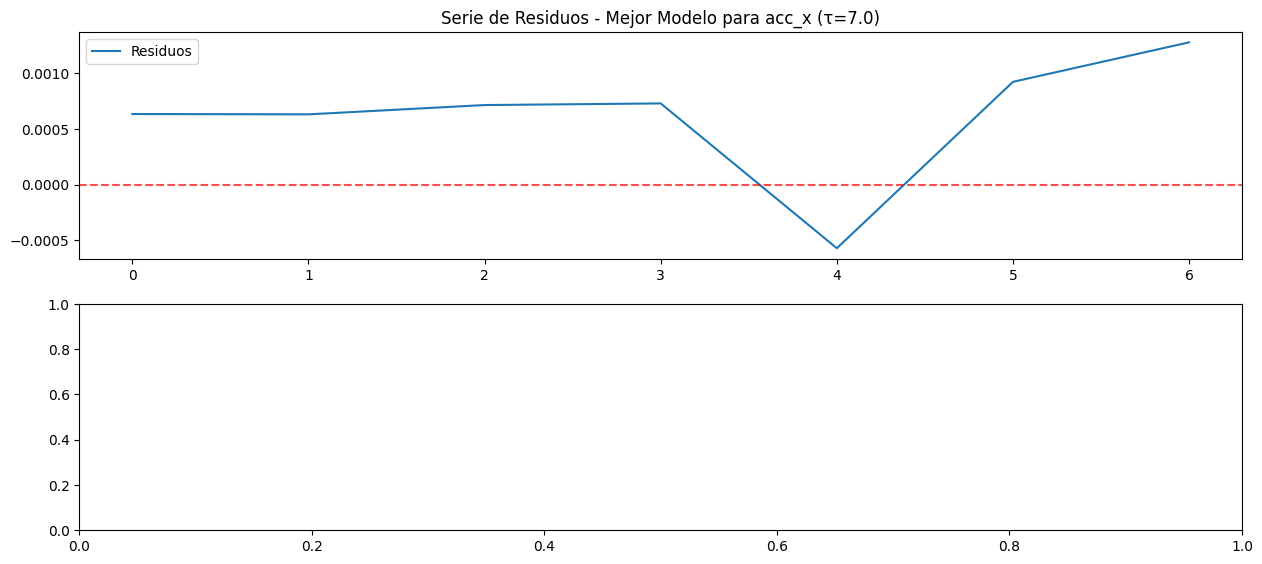

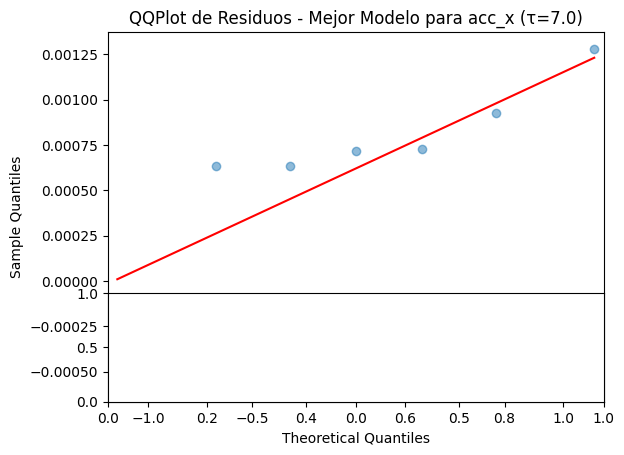

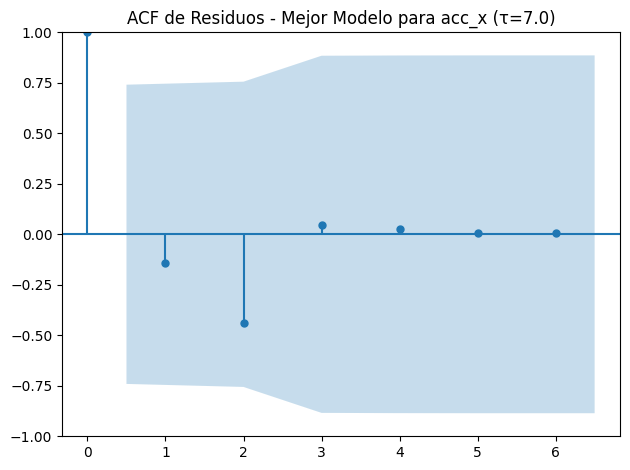


Generando gráfico de residuos para la variable: acc_y, τ=7.0, pliegue=690


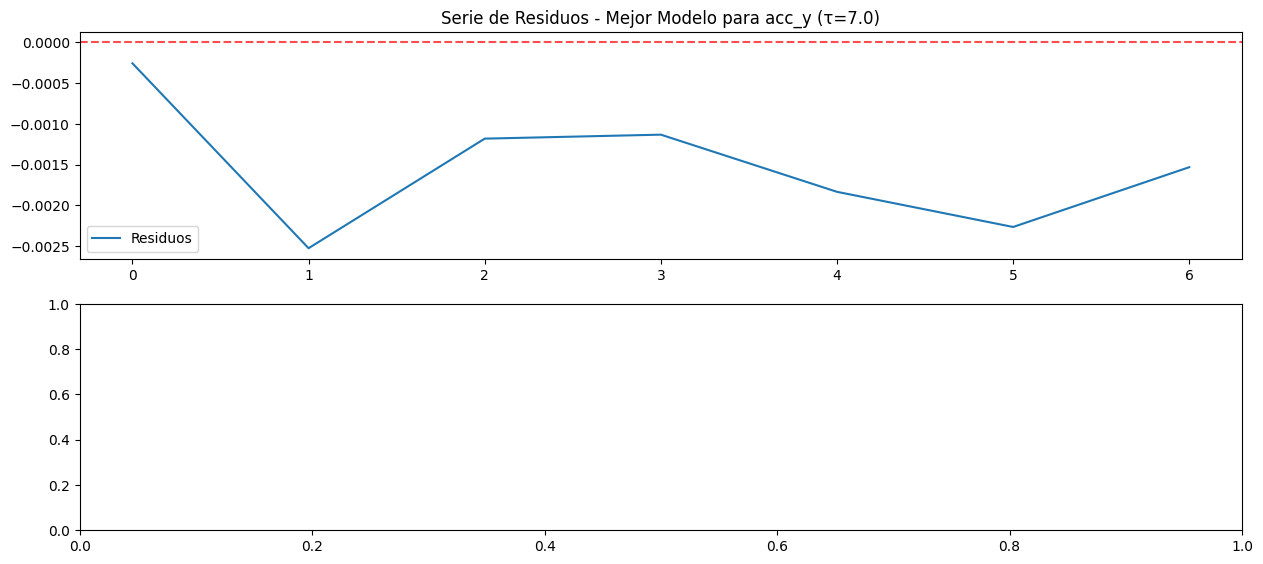

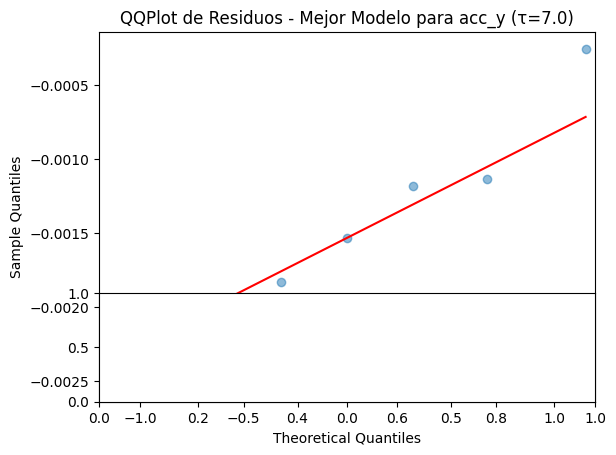

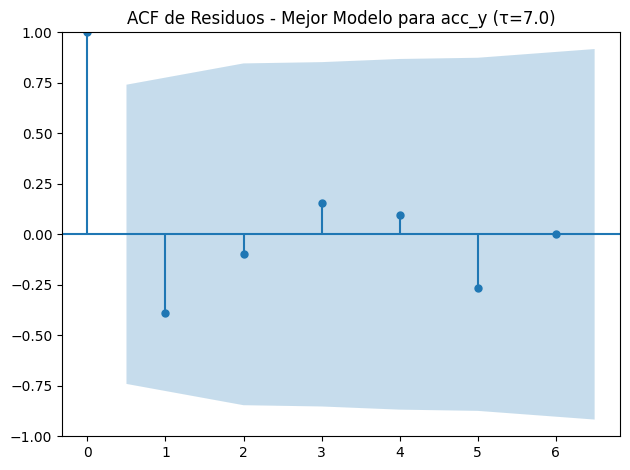


Generando gráfico de residuos para la variable: acc_z, τ=7.0, pliegue=390


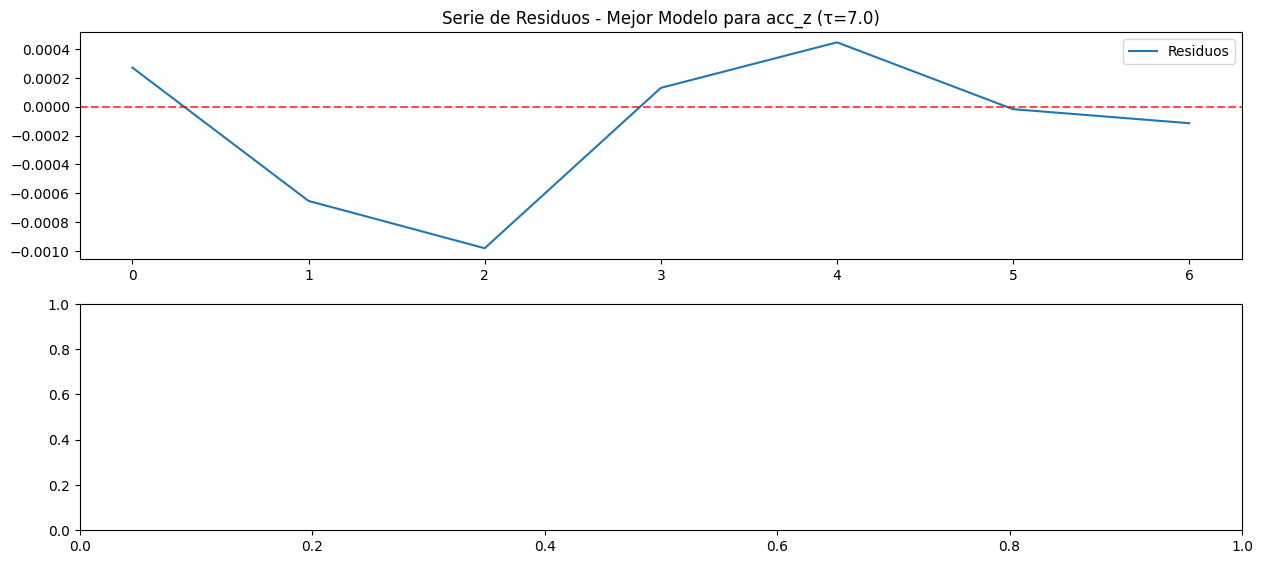

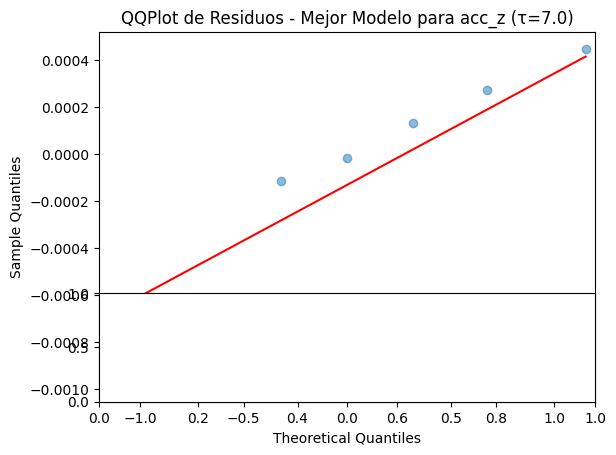

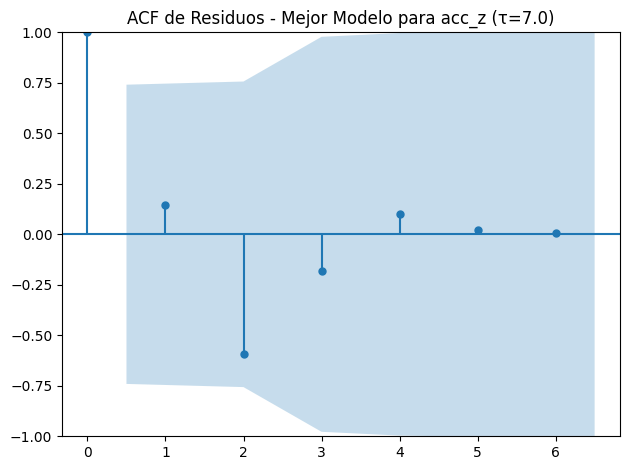


Generando gráfico de residuos para la variable: gyr_x, τ=7.0, pliegue=1626


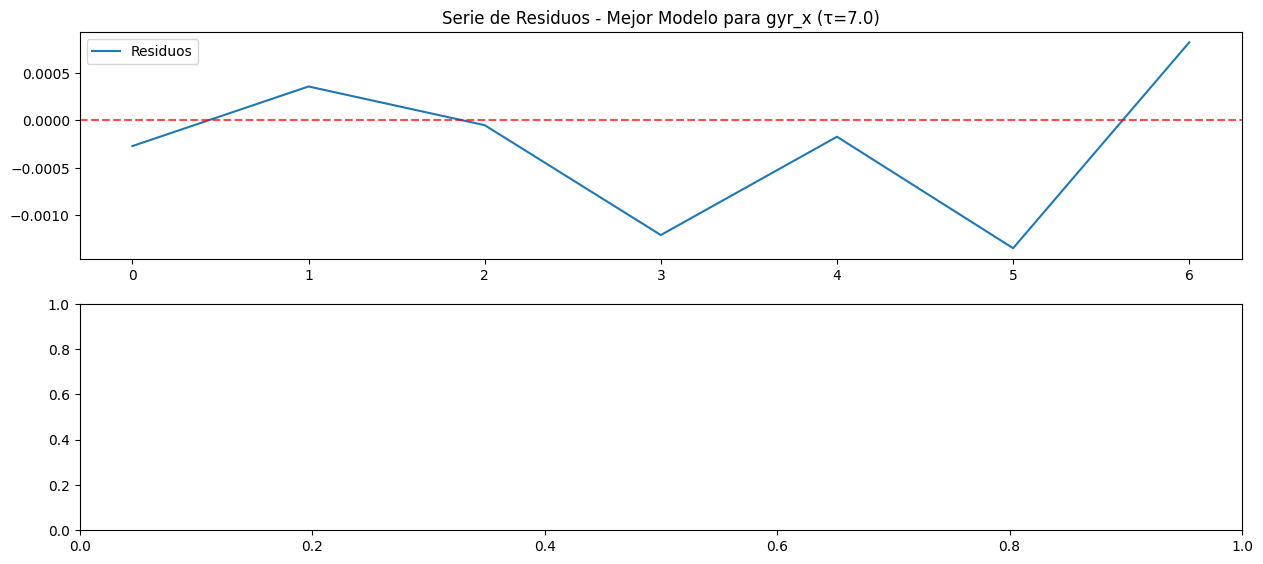

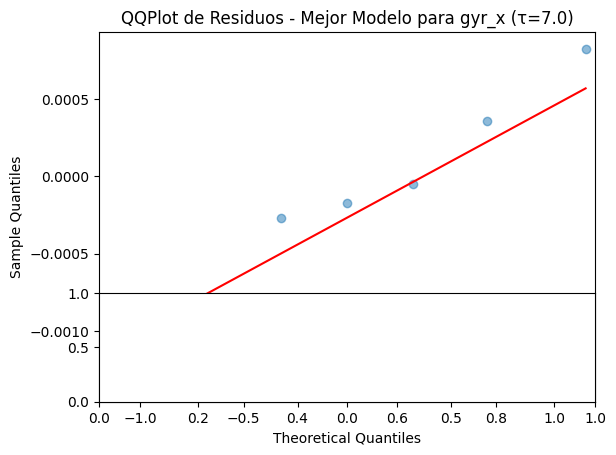

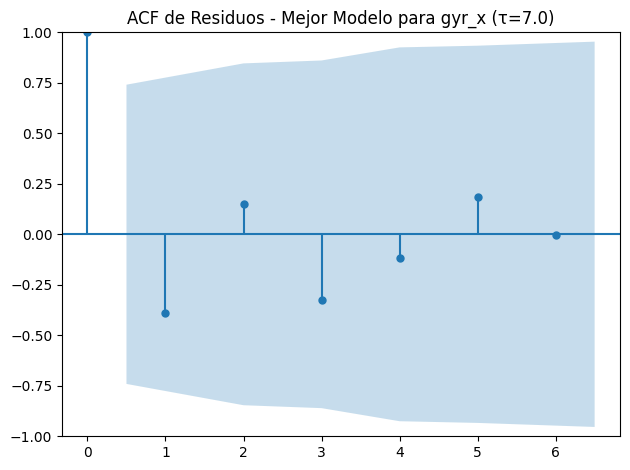


Generando gráfico de residuos para la variable: gyr_y, τ=7.0, pliegue=2084


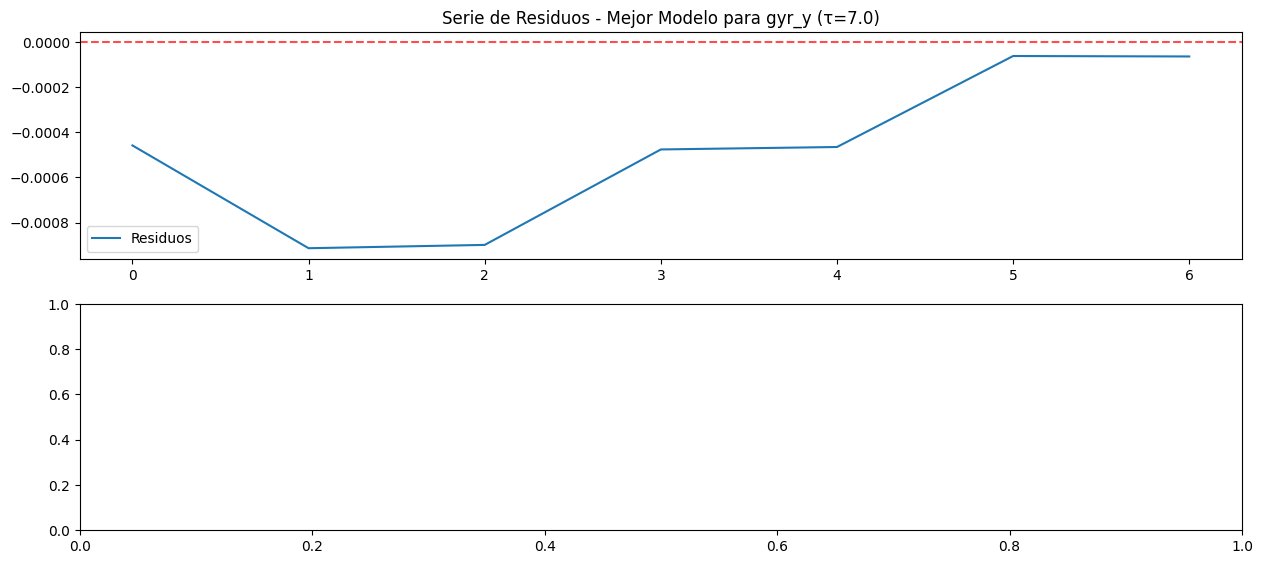

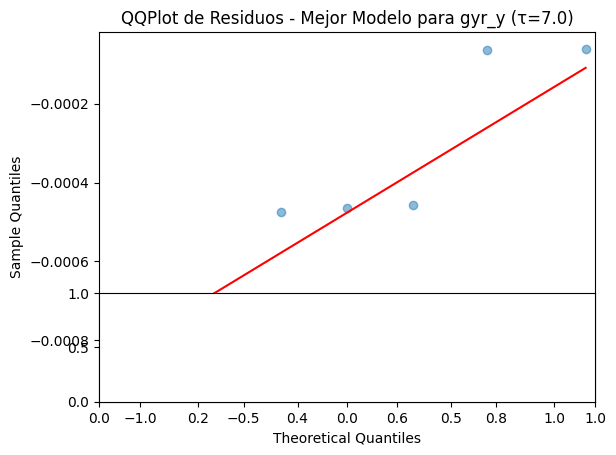

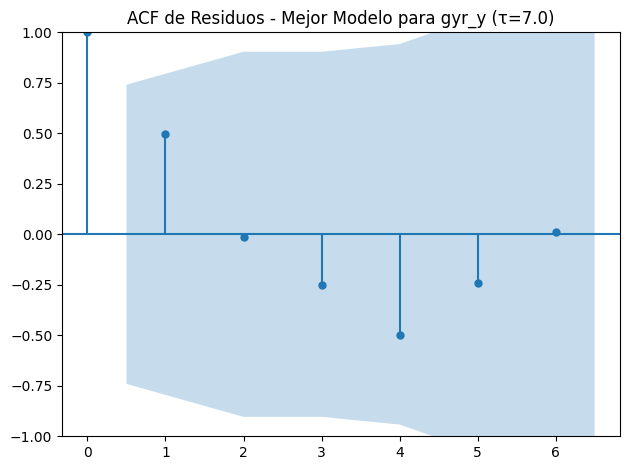


Generando gráfico de residuos para la variable: gyr_z, τ=7.0, pliegue=619


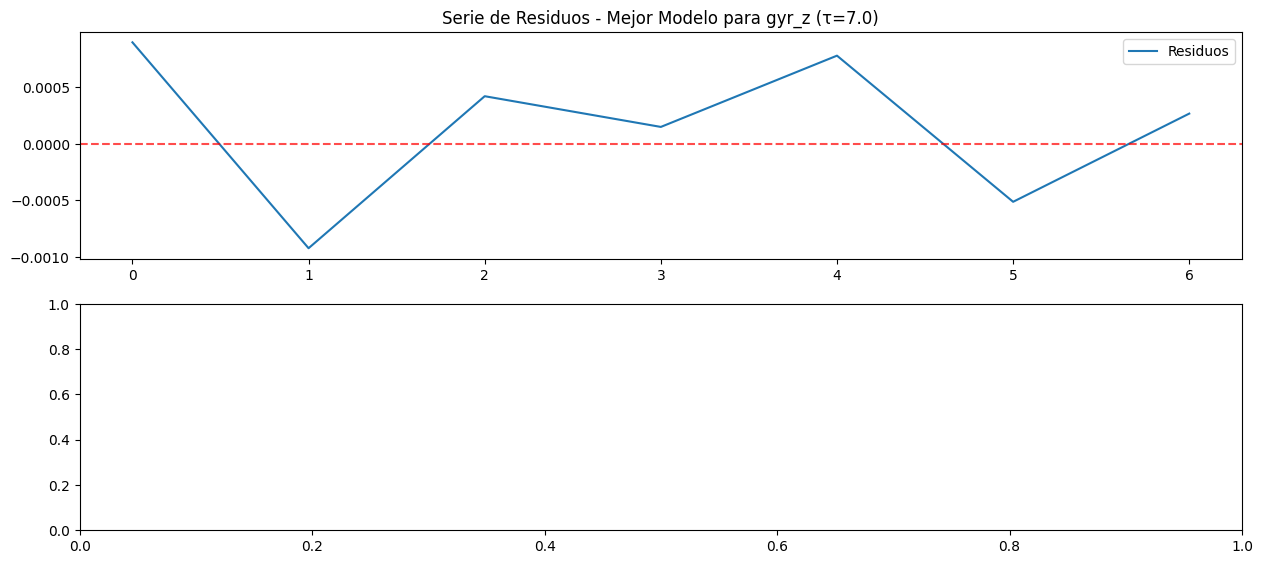

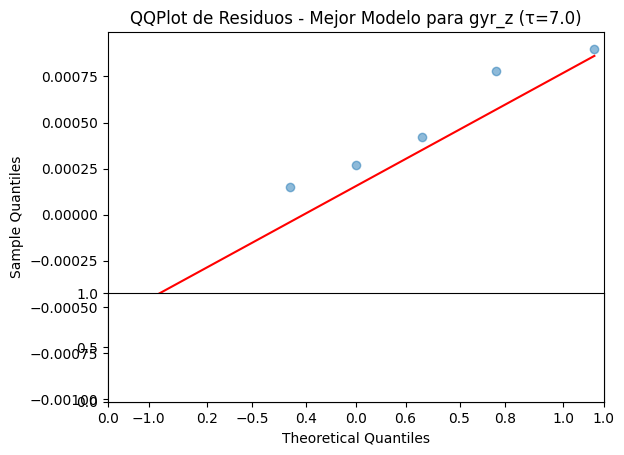

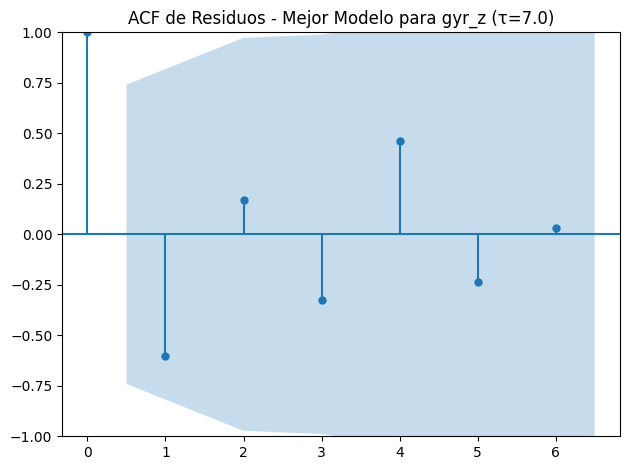


Generando gráfico de residuos para la variable: mag_x, τ=7.0, pliegue=802


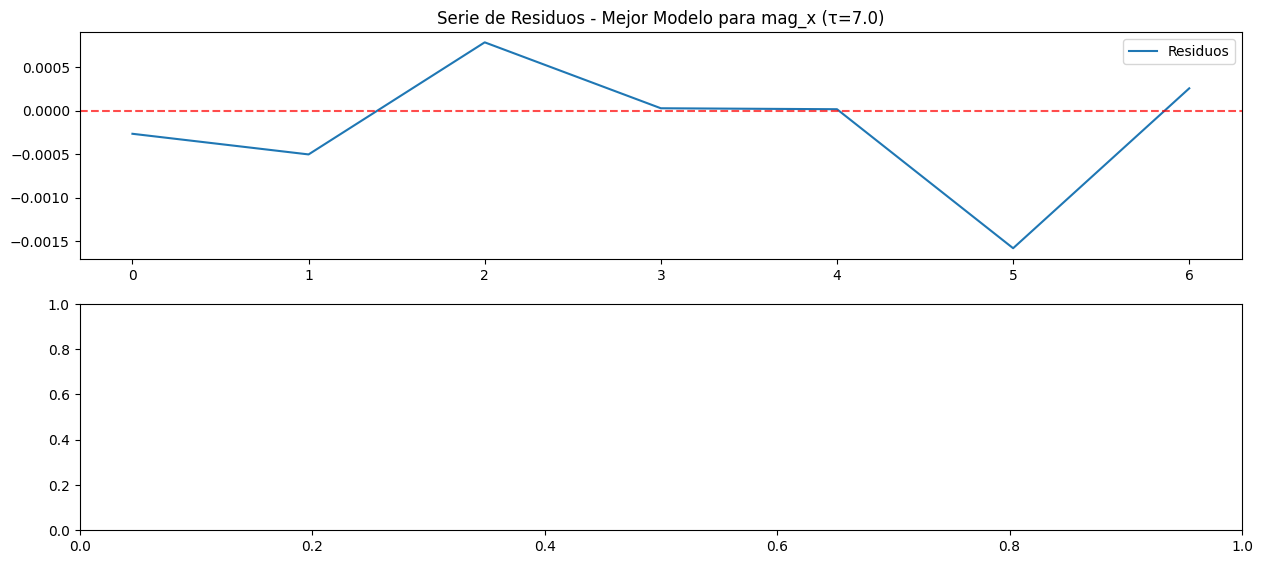

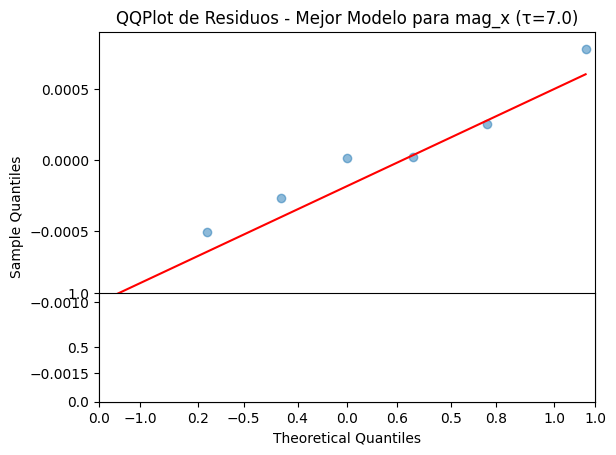

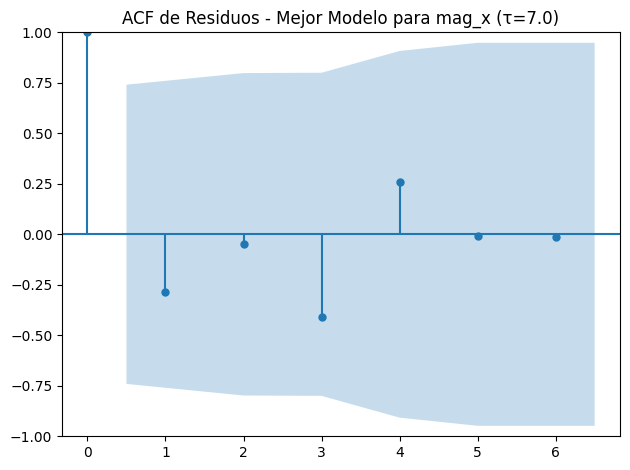


Generando gráfico de residuos para la variable: mag_y, τ=7.0, pliegue=536


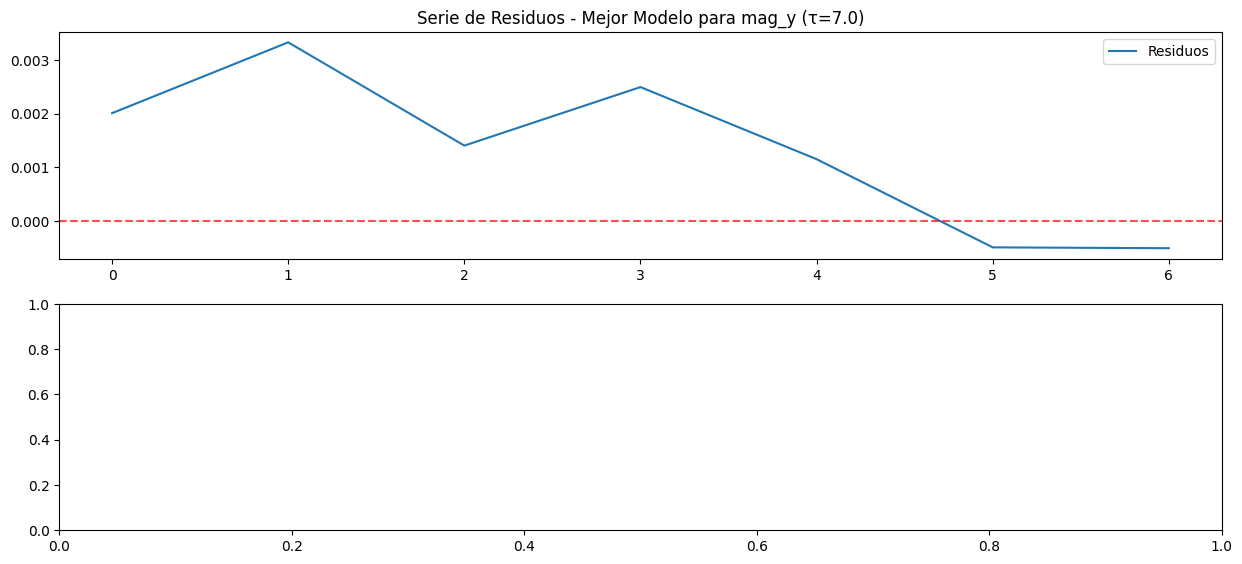

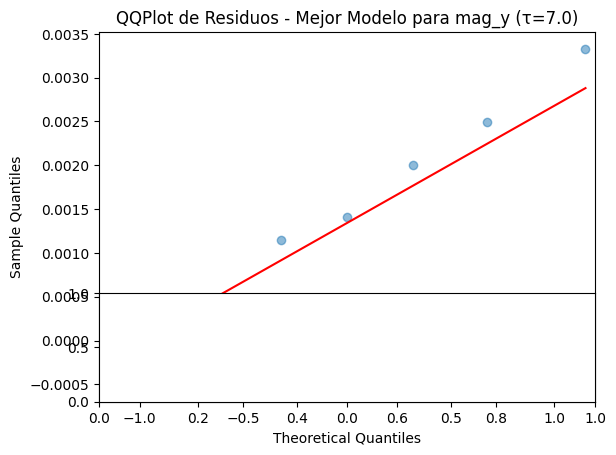

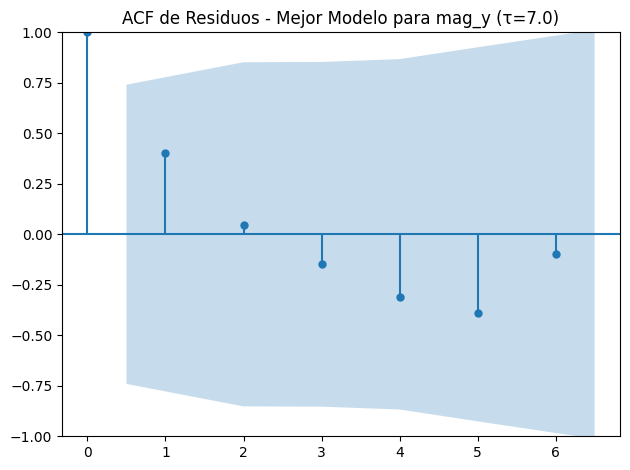


Generando gráfico de residuos para la variable: mag_z, τ=7.0, pliegue=1107


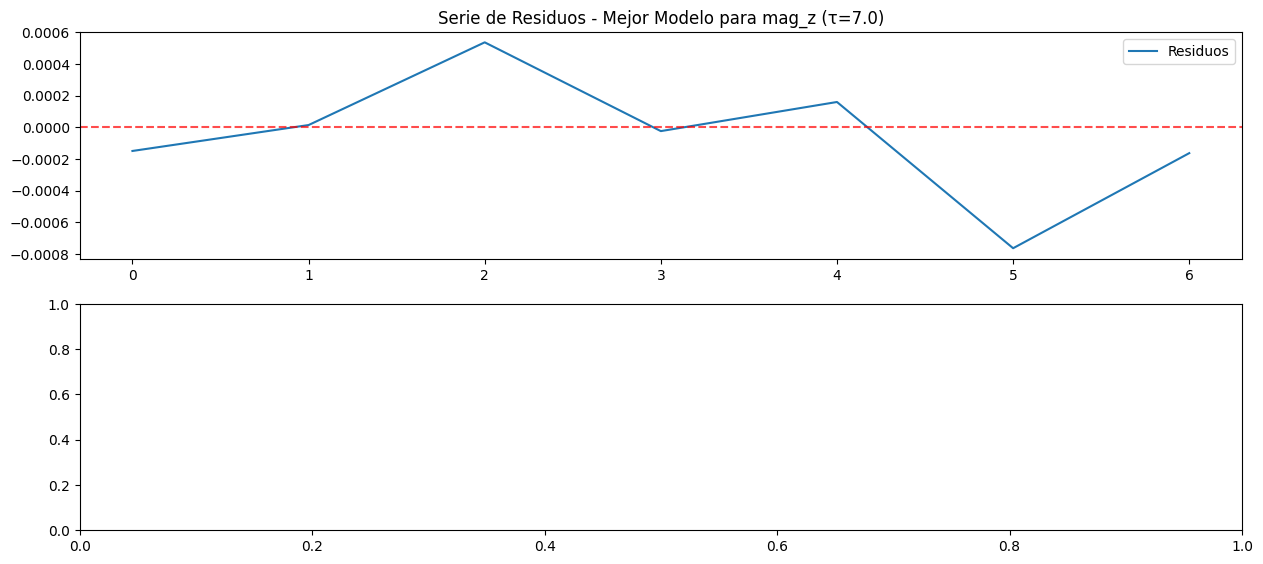

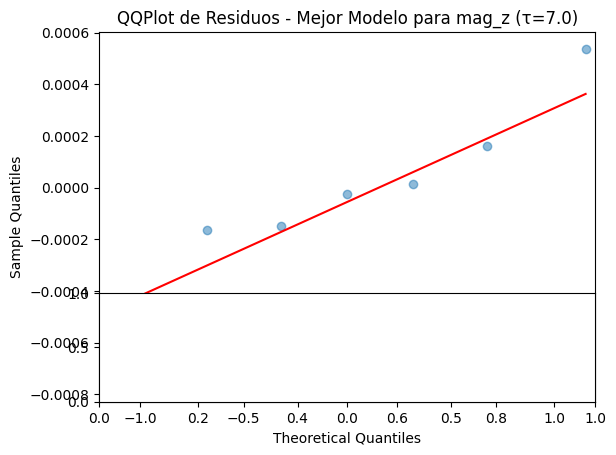

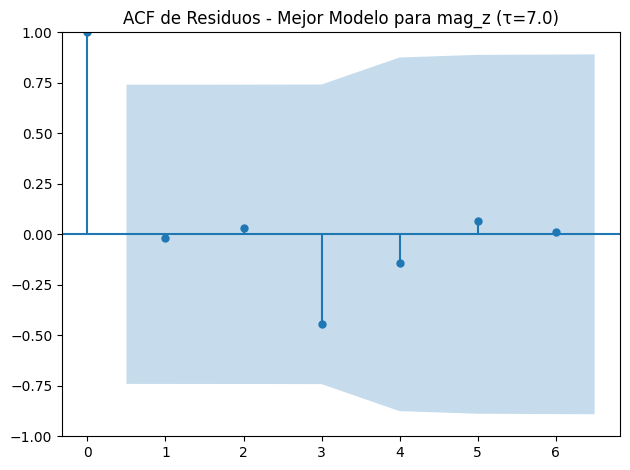

In [ ]:
for index, row in mejores_resultados_todasxg.iterrows():
    variable = row['variable']
    mejor_tau = row['Ventana'] 
    mejor_pliegue = int(row['pliegue'])  

    print(f"\nGenerando gráfico de residuos para la variable: {variable}, τ={mejor_tau}, pliegue={mejor_pliegue}")

    X_train_best = divisiones[mejor_tau]['X_train'][mejor_pliegue - 1]
    y_train_best = divisiones[mejor_tau]['y_train'][mejor_pliegue - 1]
    X_val_best = divisiones[mejor_tau]['X_val'][mejor_pliegue - 1]
    y_val_best = divisiones[mejor_tau]['y_val'][mejor_pliegue - 1]
    X_test_best = divisiones[mejor_tau]['X_test'][mejor_pliegue - 1]
    y_test_best = divisiones[mejor_tau]['y_test'][mejor_pliegue - 1]

    modelo_best = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=2)  
    modelo_best.fit(X_train_best, y_train_best)

    y_pred_best = modelo_best.predict(X_val_best)
    residuos_best = y_val_best - y_pred_best
    residuos_best = np.array(residuos_best)

    graficar_diagnostico_residuos(
        residuos_best, 
        nombre_modelo=f"Mejor Modelo para {variable} (τ={mejor_tau})"
    )

El análisis de los gráficos de residuos para diferentes variables indica un comportamiento de normalidad en los residuos, aunque con algunas desviaciones notables. En la mayoría de los gráficos, los puntos se alinean bien con la línea roja que representa la distribución teórica esperada, lo que sugiere que los residuos siguen aproximadamente una distribución normal. Sin embargo, hay ligeras desviaciones en los extremos, especialmente en las variables acc_y, acc_z y gyr_y, lo que puede indicar la presencia de valores atípicos.

Procesando errores para la variable: acc_x
Procesando errores para la variable: acc_y
Procesando errores para la variable: acc_z
Procesando errores para la variable: gyr_x
Procesando errores para la variable: gyr_y
Procesando errores para la variable: gyr_z
Procesando errores para la variable: mag_x
Procesando errores para la variable: mag_y
Procesando errores para la variable: mag_z


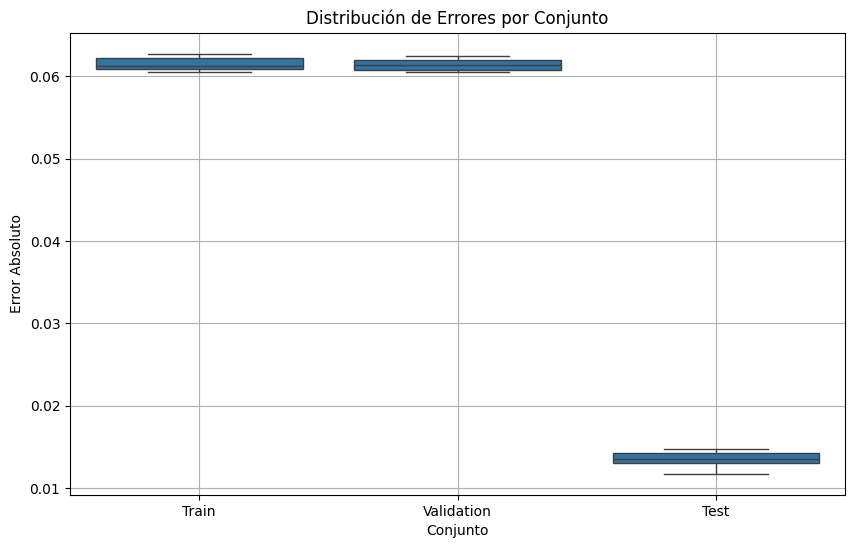

In [ ]:

errores_data = []
for variable in variables:
    print(f"Procesando errores para la variable: {variable}")
    y_train_pred = modelo_best.predict(X_train_best)
    y_val_pred = modelo_best.predict(X_val_best)
    y_test_pred = modelo_best.predict(X_test_best)
    errores_train = np.abs(y_train_best- y_train_pred )
    errores_val = np.abs(y_val_best -y_val_pred )
    errores_test = np.abs(y_test_best- y_test_pred )

    errores_data.extend([
        {'Set': 'Train', 'Error': error, 'Variable': variable} for error in errores_train
    ])
    errores_data.extend([
        {'Set': 'Validation', 'Error': error, 'Variable': variable} for error in errores_val
    ])
    errores_data.extend([
        {'Set': 'Test', 'Error': error, 'Variable': variable} for error in errores_test
    ])
df_errores = pd.DataFrame(errores_data)
plt.figure(figsize=(10, 6))
sns.boxplot(x='Set', y='Error', data=df_errores)
plt.title('Distribución de Errores por Conjunto')
plt.xlabel('Conjunto')
plt.ylabel('Error Absoluto')
plt.grid(True)
plt.show()

Esta gráfica muestra una notable estabilidad en la distribución de los errores para los conjuntos de entrenamiento y validación, lo que indica que el modelo está logrando un ajuste balanceado sin signos evidentes de sobreajuste. Aunque el conjunto de prueba muestra una menor dispersión y valores más bajos de error absoluto, este comportamiento puede reflejar un buen desempeño en la predicción para datos nuevos. 

## SVR

In [ ]:
mejores_resultados_todassvr = [] 
for ejercicio in ejercicios:
    for unidad in unidades:
        clave_entrenamiento = f'es{sujeto}e{ejercicio}u{unidad}'
        clave_prueba = f'ts{sujeto}e{ejercicio}u{unidad}'
   
        if clave_entrenamiento in datos_entrenamiento and clave_prueba in datos_prueba:
            divisiones = crear_pliegues(
                datos_entrenamiento[clave_entrenamiento],
                datos_prueba[clave_prueba],
                variables,
                tau_list
            )
            resultados = evaluar_modelo_svr(divisiones, tau_list)
            mejor_resultado = obtener_mejores_resultados(resultados, criterio='R2')
            mejores_resultados_todassvr.append(mejor_resultado)
        else:
            print(f"Claves no encontradas: {clave_entrenamiento} o {clave_prueba}")


  Evaluación para τ = 7

  Evaluación para τ = 14

  Evaluación para τ = 21

  Evaluación para τ = 28

  Evaluación para τ = 7

  Evaluación para τ = 14

  Evaluación para τ = 21

  Evaluación para τ = 28

  Evaluación para τ = 7

  Evaluación para τ = 14

  Evaluación para τ = 21

  Evaluación para τ = 28

  Evaluación para τ = 7

  Evaluación para τ = 14

  Evaluación para τ = 21

  Evaluación para τ = 28

  Evaluación para τ = 7

  Evaluación para τ = 14

  Evaluación para τ = 21

  Evaluación para τ = 28

  Evaluación para τ = 7

  Evaluación para τ = 14

  Evaluación para τ = 21

  Evaluación para τ = 28

  Evaluación para τ = 7

  Evaluación para τ = 14

  Evaluación para τ = 21

  Evaluación para τ = 28

  Evaluación para τ = 7

  Evaluación para τ = 14

  Evaluación para τ = 21

  Evaluación para τ = 28

  Evaluación para τ = 7

  Evaluación para τ = 14

  Evaluación para τ = 21

  Evaluación para τ = 28


In [82]:
pd.DataFrame(mejores_resultados_todassvr)

Ventana  pliegue           MSE      RMSE        MAPE        R2  \
444       7.0    445.0  1.538085e-05  0.003922    0.036468  0.807672   
446       7.0    447.0  6.633672e-06  0.002576    0.052305  0.892195   
2159     14.0    318.0  1.691480e-04  0.013006    1.266143  0.798279   
1296      7.0   1297.0  5.917872e-05  0.007693   99.242069  0.885675   
1263      7.0   1264.0  2.441409e-06  0.001563   70.352799  0.772033   
547       7.0    548.0  6.476166e-06  0.002545  173.602530  0.804501   
1435      7.0   1436.0  1.465631e-07  0.000383    0.047381  0.749511   
5058     21.0   1396.0  2.698405e-07  0.000519    0.196331  0.919742   
6842     28.0   1380.0  1.699271e-06  0.001304    0.702058  0.914881   

      Ljung-Box (p-value)  Jarque-Bera (p-value) variable  
444              0.048757               0.781319    acc_x  
446              0.416237               0.471429    acc_y  
2159             0.671806               0.639221    acc_z  
1296             0.329027               0.642500    gyr_x  
1263             0.637976               0.703556    gyr_y  
547              0.909089               0.553311    gyr_z  
1435             0.396204               0.663882    mag_x  
5058             0.722560               0.796871    mag_y  
6842             0.138194               0.000003    mag_z

El modelo muestra un buen desempeño en términos de ajuste, destacando las variables mag_x y mag_y con los menores valores de MSE, RMSE y MAPE, además de altos coeficientes de determinación (R² > 0.91), lo que indica predicciones muy precisas.  Los resultados de la prueba Ljung-Box indican que no hay autocorrelación significativa en la mayoría de los residuos, salvo en acc_x (p=0.048), donde podría requerirse mayor ajuste. 


Generando gráfico de residuos para la variable: acc_x, τ=7.0, pliegue=445


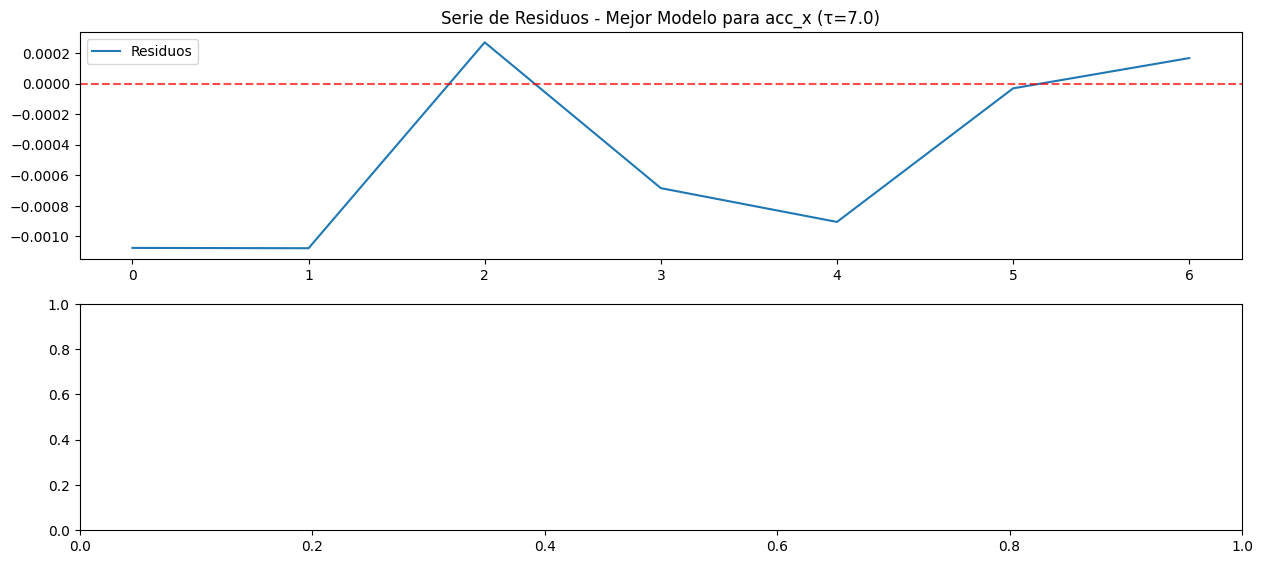

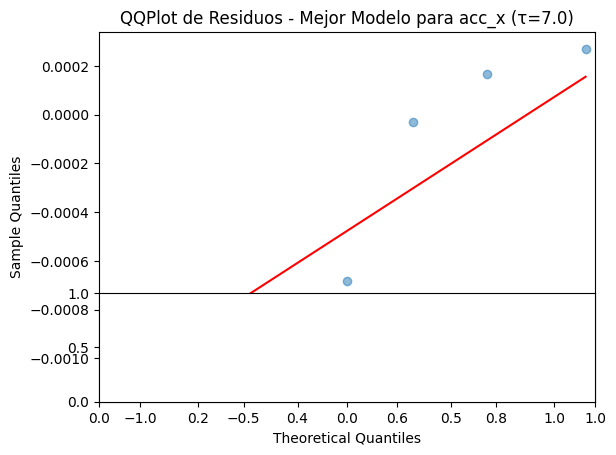

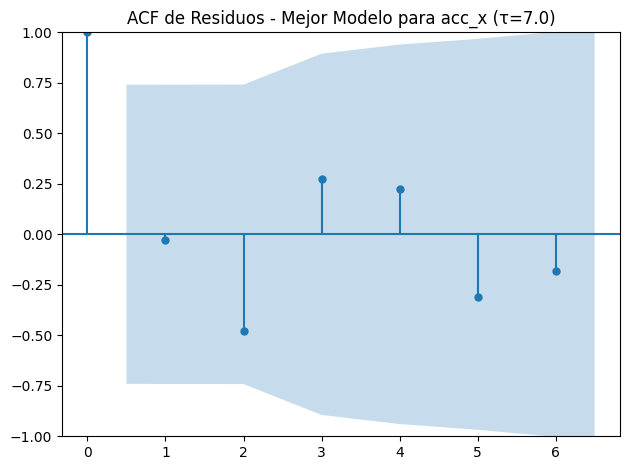


Generando gráfico de residuos para la variable: acc_y, τ=7.0, pliegue=447


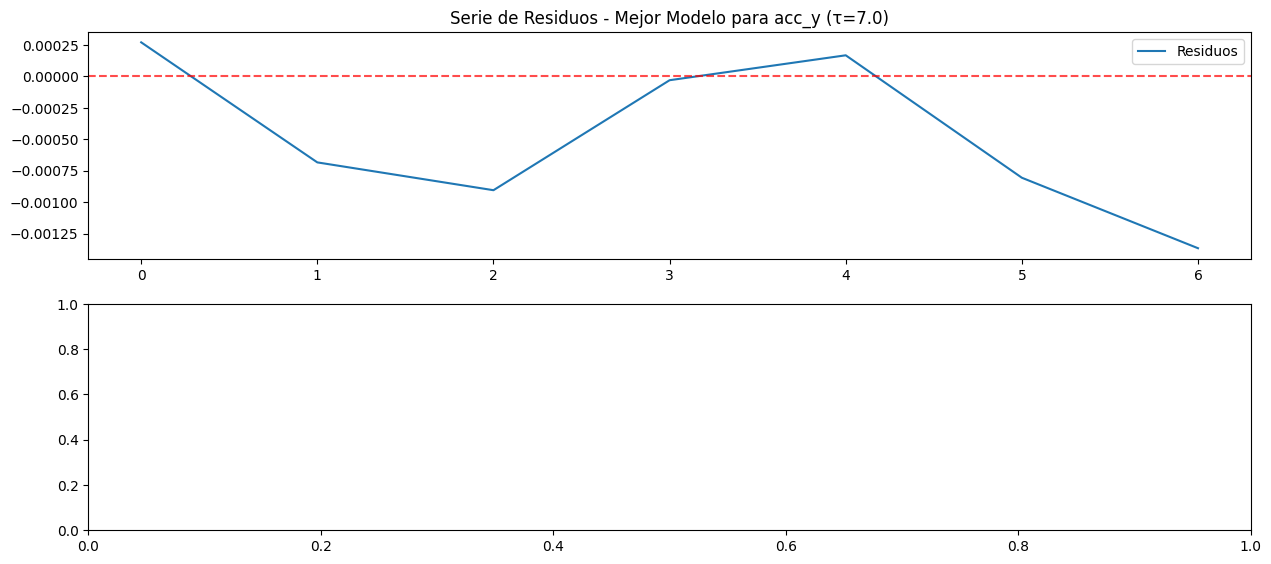

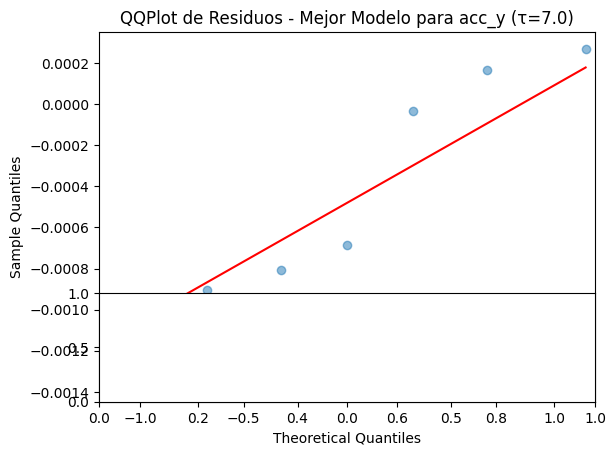

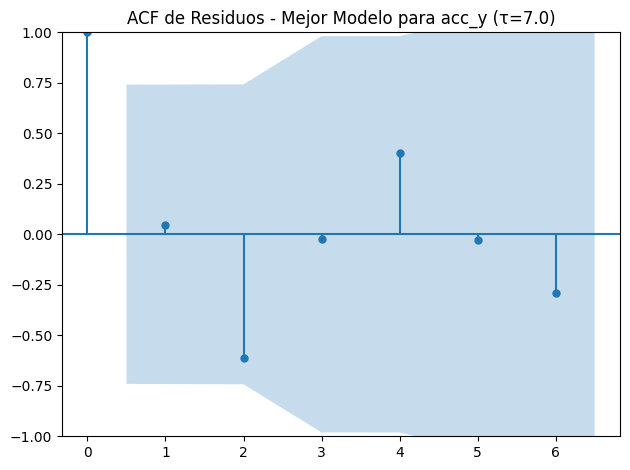


Generando gráfico de residuos para la variable: acc_z, τ=14.0, pliegue=318


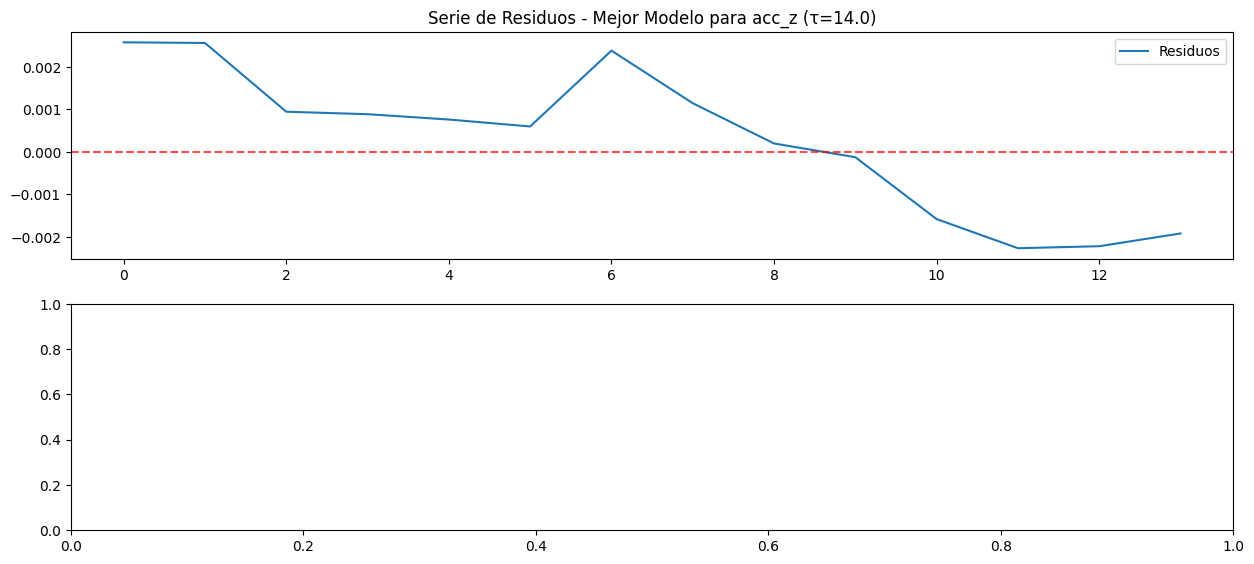

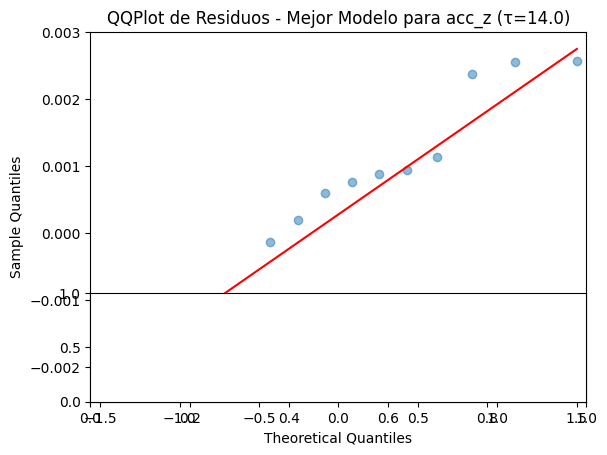

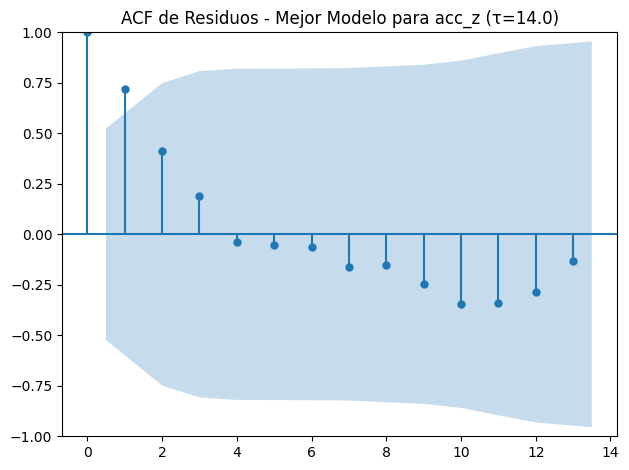


Generando gráfico de residuos para la variable: gyr_x, τ=7.0, pliegue=1297


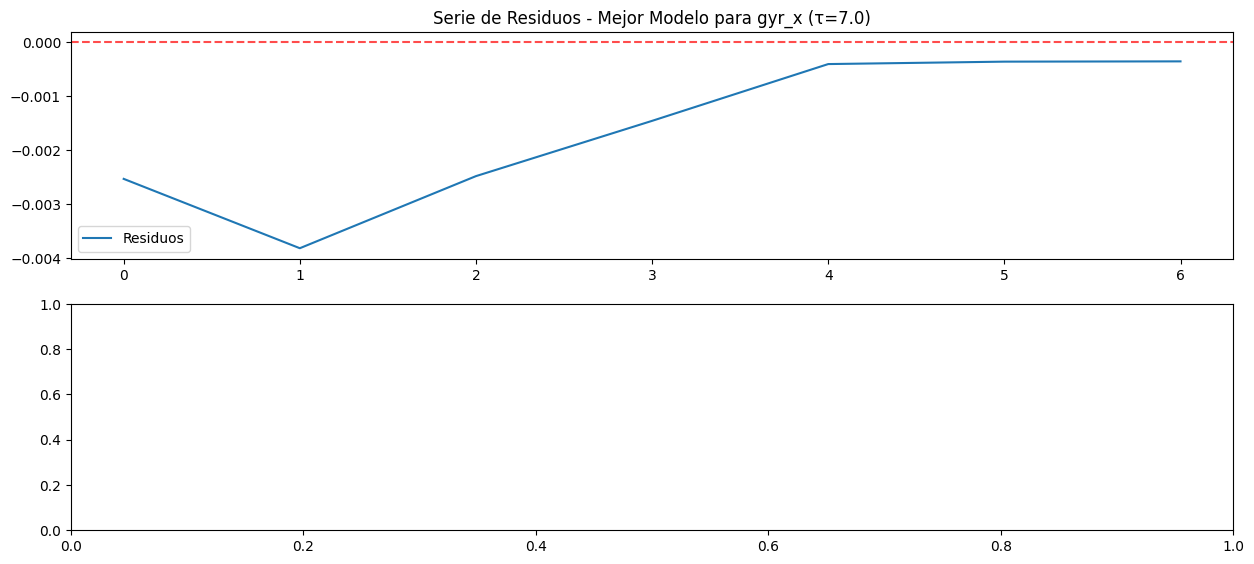

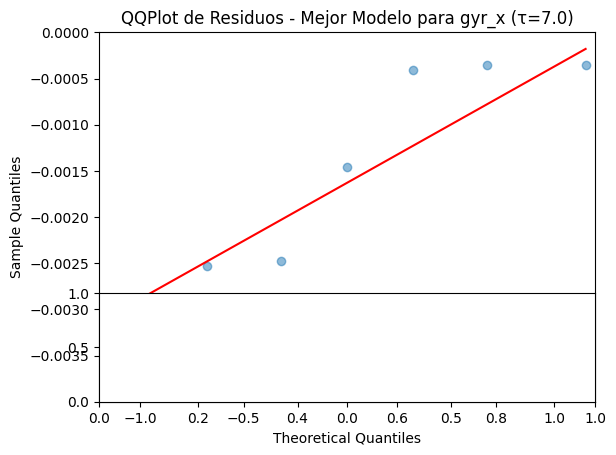

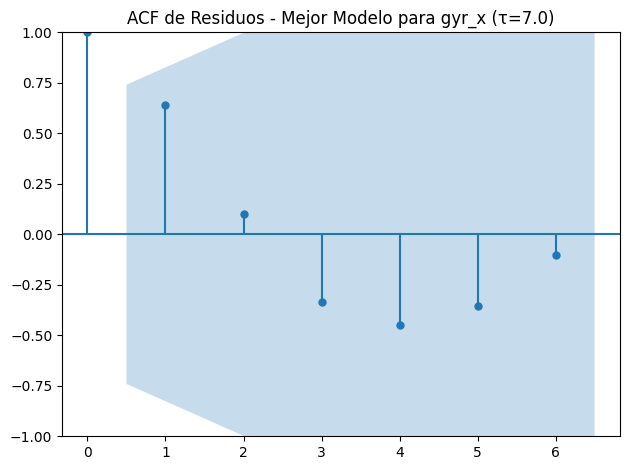


Generando gráfico de residuos para la variable: gyr_y, τ=7.0, pliegue=1264


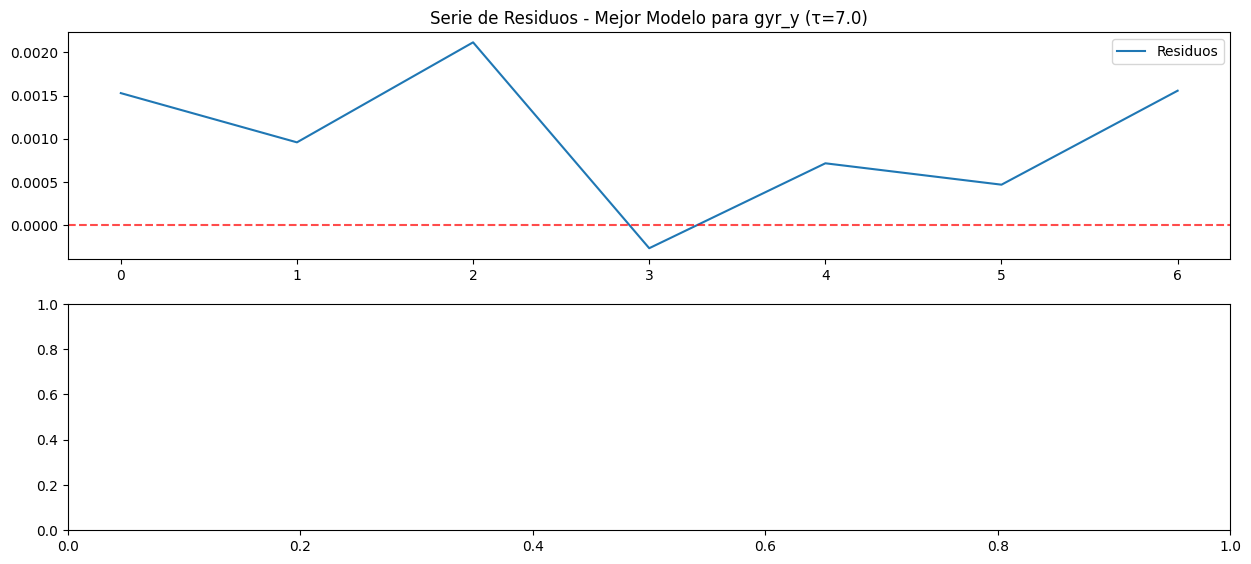

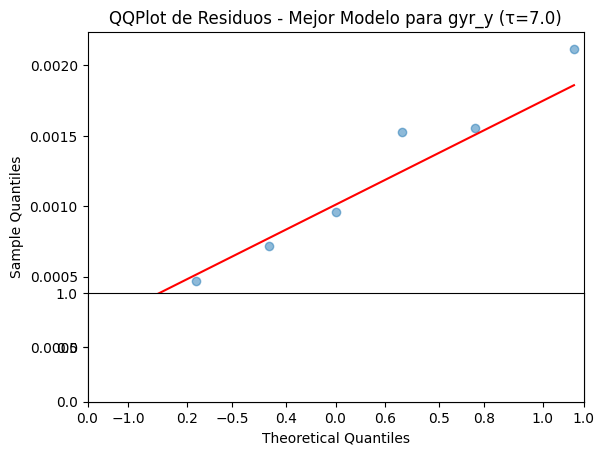

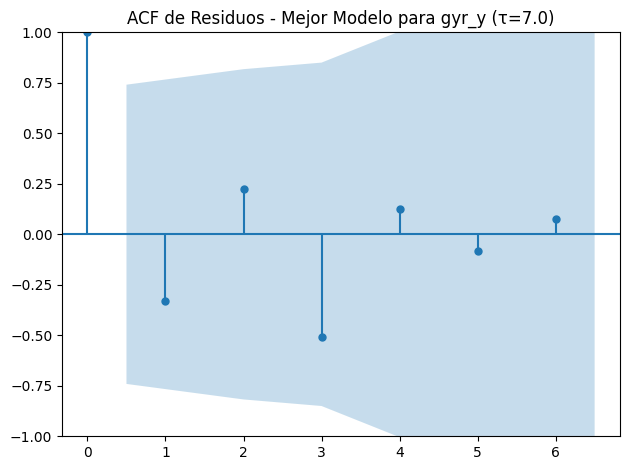


Generando gráfico de residuos para la variable: gyr_z, τ=7.0, pliegue=548


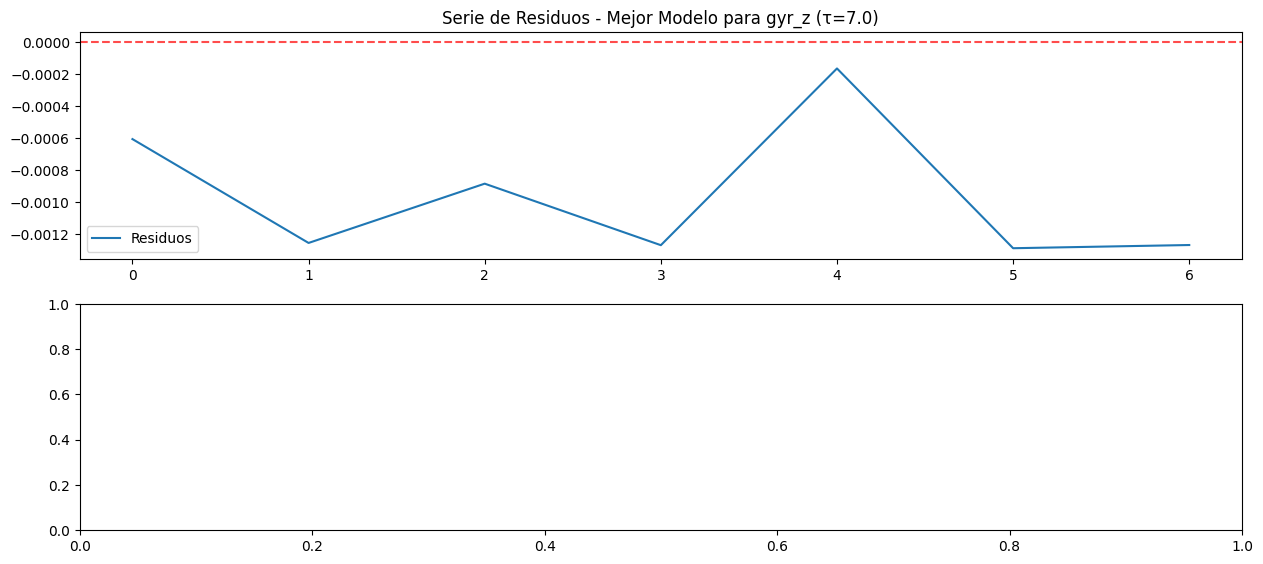

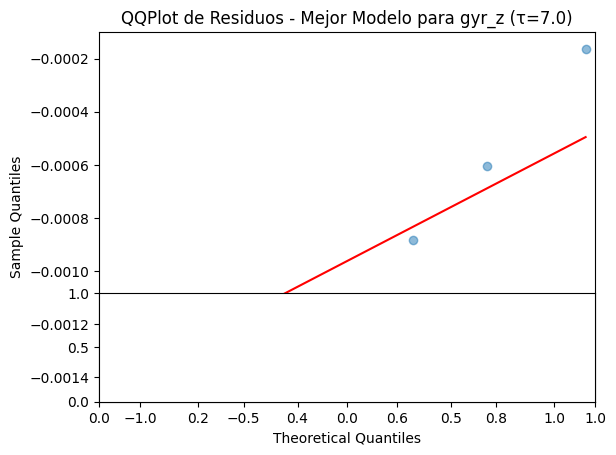

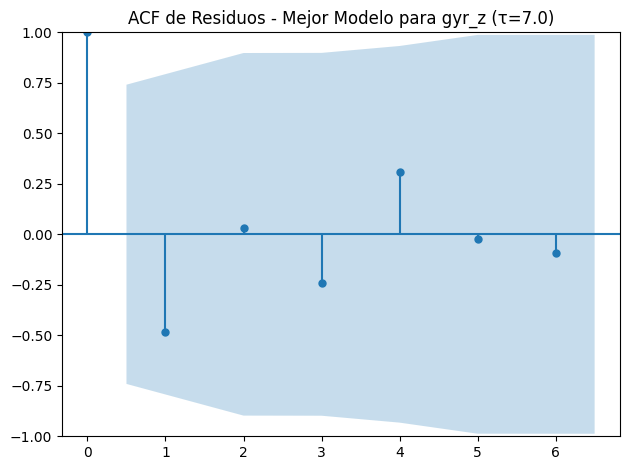


Generando gráfico de residuos para la variable: mag_x, τ=7.0, pliegue=1436


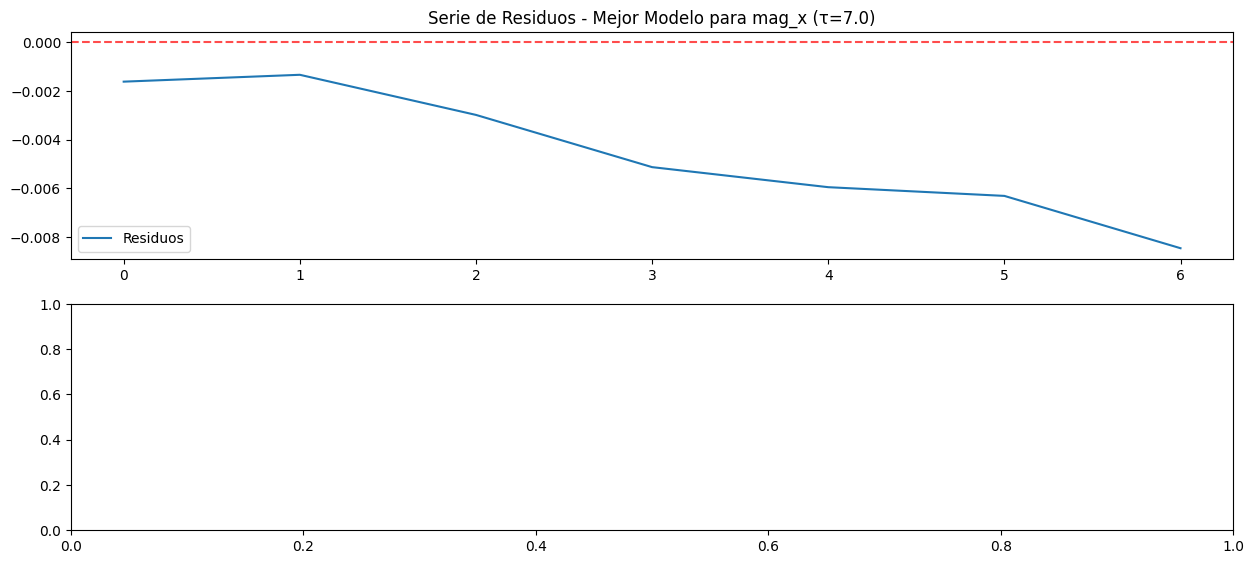

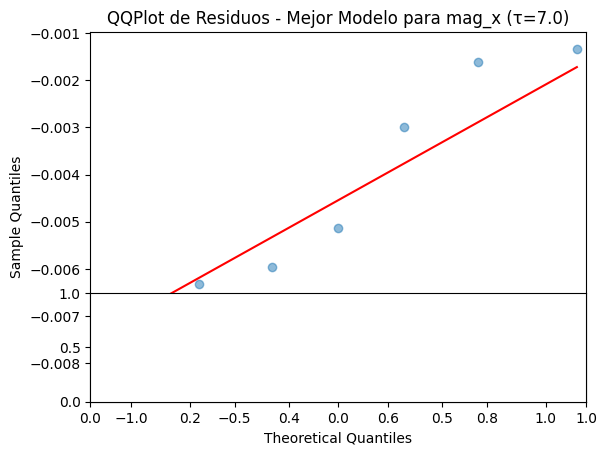

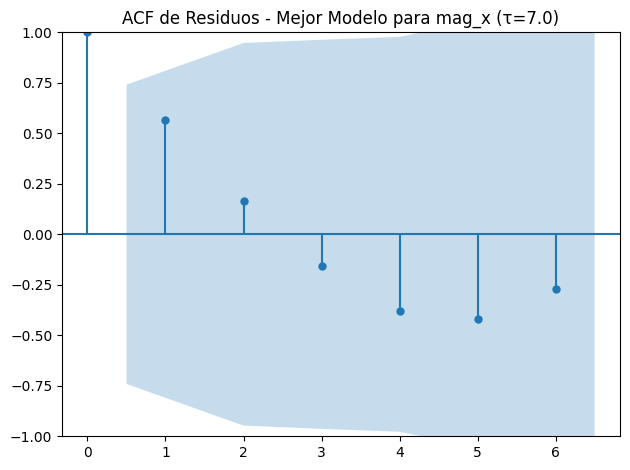


Generando gráfico de residuos para la variable: mag_y, τ=21.0, pliegue=1396


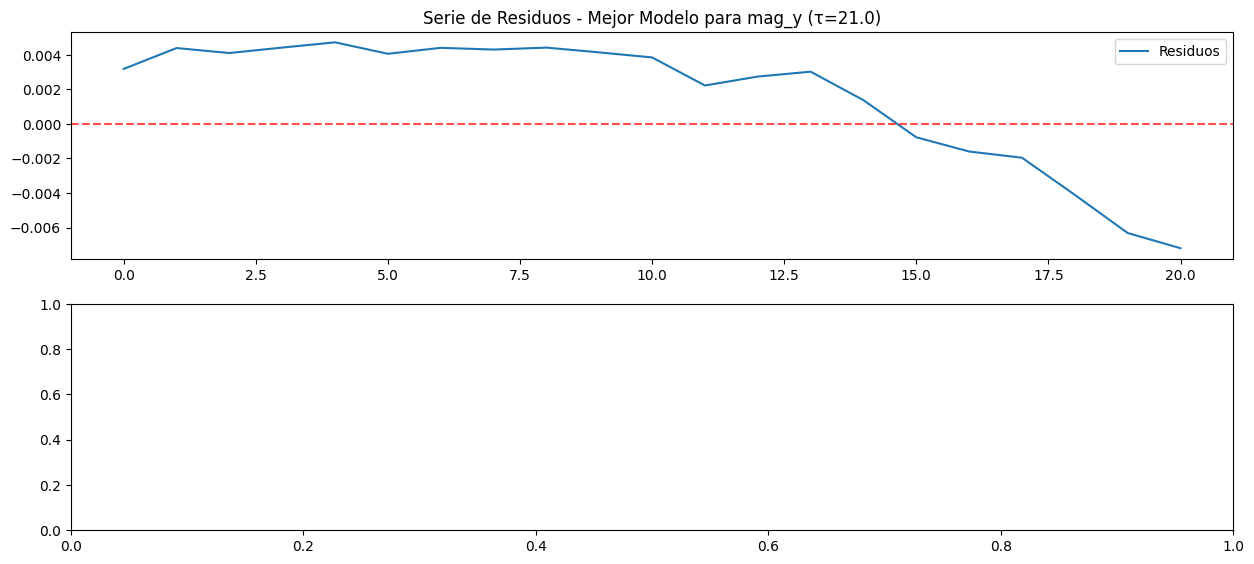

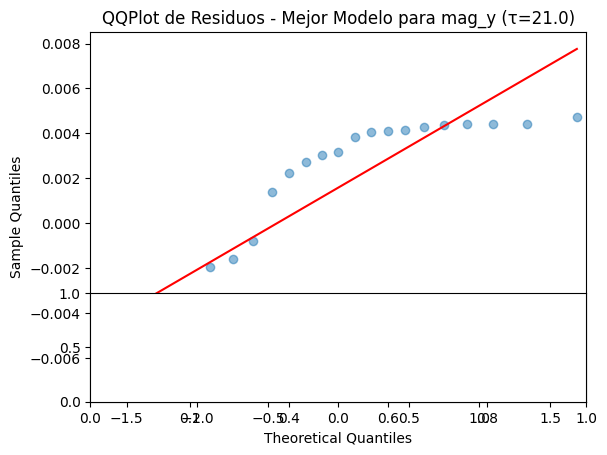

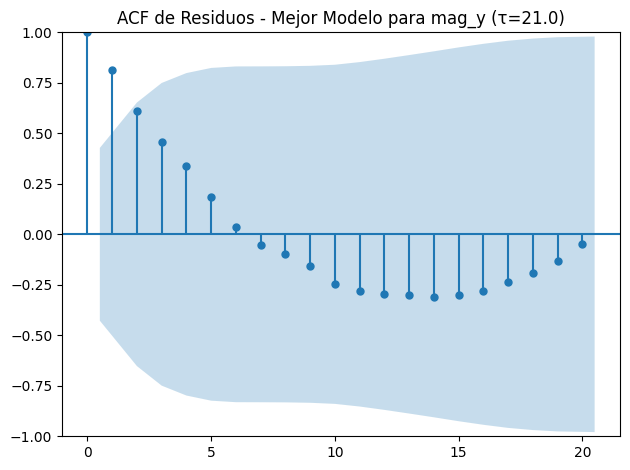


Generando gráfico de residuos para la variable: mag_z, τ=28.0, pliegue=1380


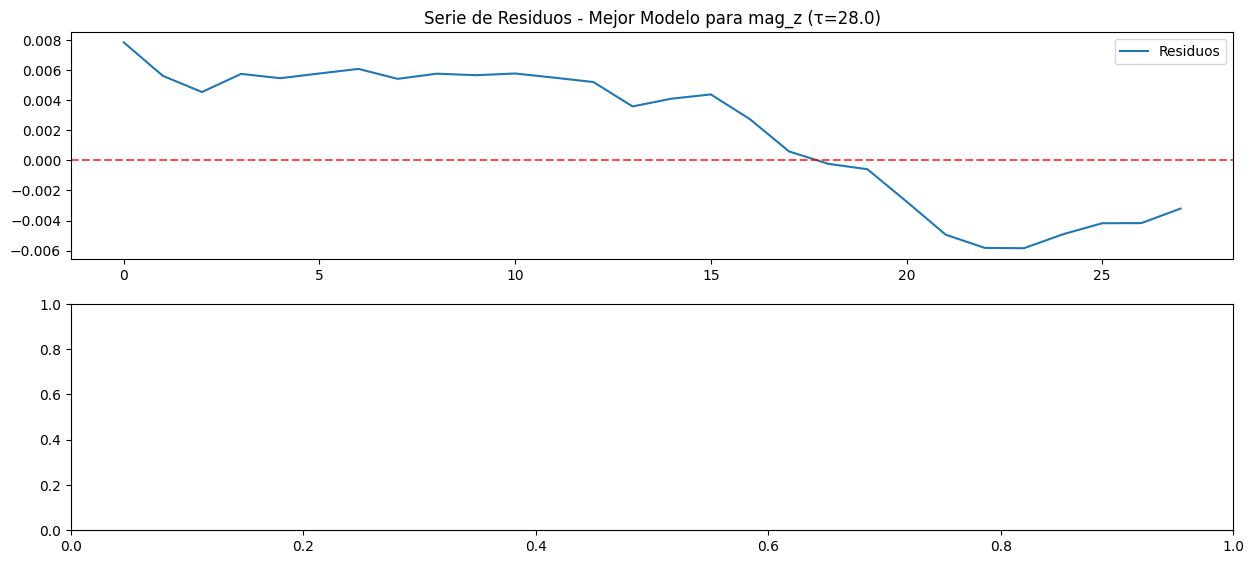

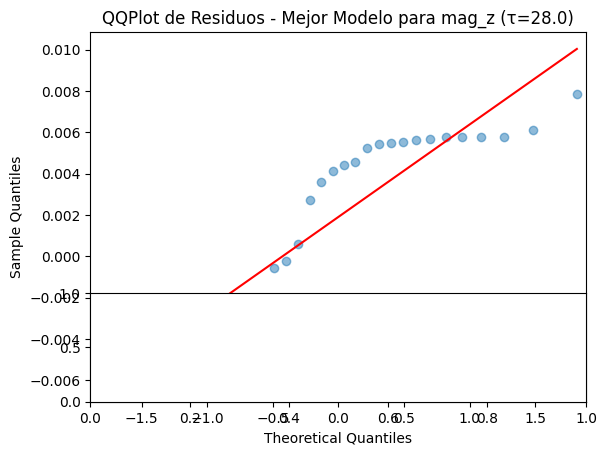

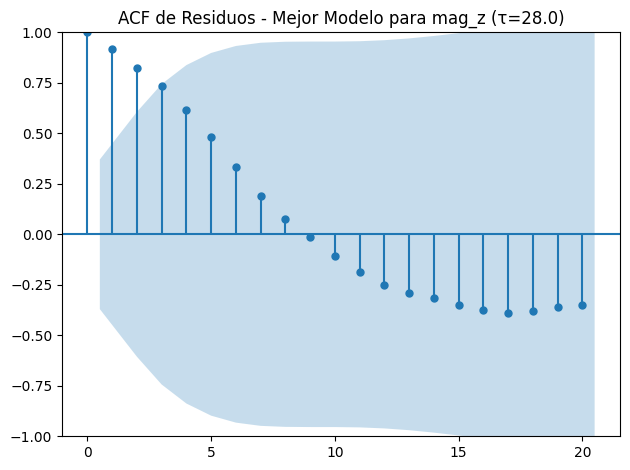

In [ ]:
for index, row in mejores_resultados_todassvr.iterrows():
    variable = row['variable']
    mejor_tau = row['Ventana']  
    mejor_pliegue = int(row['pliegue'])  
    print(f"\nGenerando gráfico de residuos para la variable: {variable}, τ={mejor_tau}, pliegue={mejor_pliegue}")

    X_train_best = divisiones[mejor_tau]['X_train'][mejor_pliegue - 1]
    y_train_best = divisiones[mejor_tau]['y_train'][mejor_pliegue - 1]
    X_val_best = divisiones[mejor_tau]['X_val'][mejor_pliegue - 1]
    y_val_best = divisiones[mejor_tau]['y_val'][mejor_pliegue - 1]
    X_test_best = divisiones[mejor_tau]['X_test'][mejor_pliegue - 1]
    y_test_best = divisiones[mejor_tau]['y_test'][mejor_pliegue - 1]

    modelo_best = SVR(kernel='rbf', C=1.0, epsilon=0.1)
    modelo_best.fit(X_train_best, y_train_best)

    y_pred_best = modelo_best.predict(X_val_best)
    residuos_best = y_val_best - y_pred_best
    residuos_best = residuos_best[~np.isnan(residuos_best)]  
    residuos_best = residuos_best[~np.isinf(residuos_best)]  
    residuos_best = np.array(residuos_best)

    graficar_diagnostico_residuos(
        residuos_best, 
        nombre_modelo=f"Mejor Modelo para {variable} (τ={mejor_tau})"
    )

Los residuos presentan valores predominantemente cercanos a cero, lo cual es deseable en un modelo bien ajustado. Sin embargo, en ciertas series se perciben fluctuaciones más pronunciadas.

Procesando errores para la variable: acc_x
Procesando errores para la variable: acc_y
Procesando errores para la variable: acc_z
Procesando errores para la variable: gyr_x
Procesando errores para la variable: gyr_y
Procesando errores para la variable: gyr_z
Procesando errores para la variable: mag_x
Procesando errores para la variable: mag_y
Procesando errores para la variable: mag_z


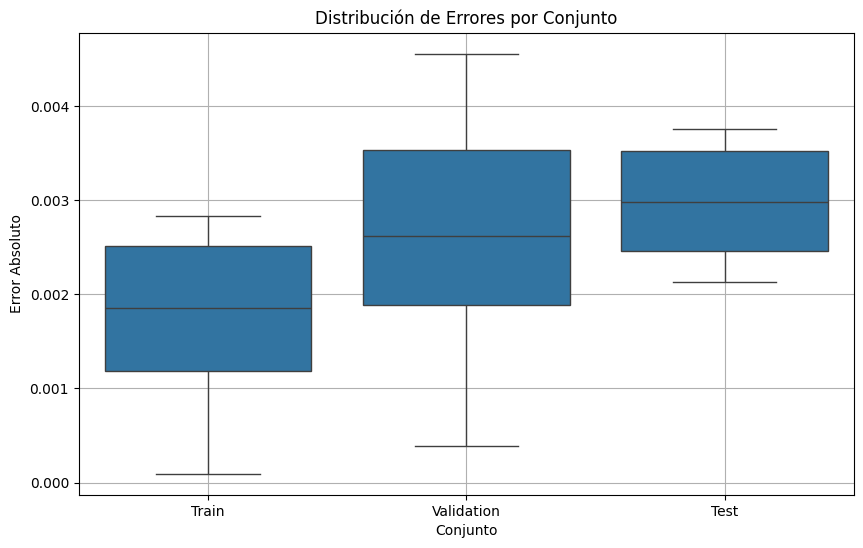

In [ ]:
errores_data = []
for variable in variables:
    print(f"Procesando errores para la variable: {variable}")
    
    y_train_pred = modelo_best.predict(X_train_best)
    y_val_pred = modelo_best.predict(X_val_best)
    y_test_pred = modelo_best.predict(X_test_best)

    errores_train = np.abs(y_train_best - y_train_pred)
    errores_val = np.abs(y_val_best - y_val_pred)
    errores_test = np.abs(y_test_best - y_test_pred)

    errores_data.extend([
        {'Set': 'Train', 'Error': error, 'Variable': variable} for error in errores_train
    ])
    errores_data.extend([
        {'Set': 'Validation', 'Error': error, 'Variable': variable} for error in errores_val
    ])
    errores_data.extend([
        {'Set': 'Test', 'Error': error, 'Variable': variable} for error in errores_test
    ])

df_errores = pd.DataFrame(errores_data)

# Graficar los boxplots
plt.figure(figsize=(10, 6))
sns.boxplot(x='Set', y='Error', data=df_errores)
plt.title('Distribución de Errores por Conjunto')
plt.xlabel('Conjunto')
plt.ylabel('Error Absoluto')
plt.grid(True)
plt.show()

En esta gráfica se observa una distribución de errores relativamente balanceada entre los conjuntos de entrenamiento, validación y prueba. El conjunto de entrenamiento presenta los errores más bajos, lo cual es esperable ya que el modelo se ajusta directamente a estos datos. En el conjunto de validación, los errores son ligeramente más altos, lo que indica que el modelo mantiene un desempeño adecuado al generalizar sobre datos no vistos durante el entrenamiento. El conjunto de prueba muestra una distribución de errores similar al de validación, lo que sugiere que el modelo está generalizando bien y no está sobreajustado. Este comportamiento refleja un desempeño robusto y estable del modelo en diferentes conjuntos de datos.